In [1]:
import numpy as np
def patch_asscalar(a): # hack because of updated numpydeprecations
    return a.item()
setattr(np, "asscalar", patch_asscalar)
def patch_alen(a): # hack because of updated numpydeprecations
    return a.len()
setattr(np, "alen", patch_alen)
import matplotlib.pyplot as plt
from astropy import units as u
import utils
import importlib
import pandas as pd
from mycolorpy import colorlist as mcp
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy import stats 
from scipy.integrate import trapezoid
from matplotlib import pyplot as plt, ticker as mticker
c = 2.99e8 * u.m / u.s # speed of light [m/s]
c = c.to(u.m/u.s).value
m = (9.1093837e-31 * u.kg).value # e- mass [kg]
mH2 = 3.347649043E-27 # H2 mass [kg]
k = 1.380649e-23 # bolztman constant [J/k]


def calc_q_ion(z, E, z_min, z_max, Nion_over_Ne, get_n_H2):
    # z in m
    # E in eV
    E = E.to(u.keV)
    mu =  -0.59175*np.log(E.value) + -0.031*np.log(E.value)**2 + 0.004*np.log(E.value)**3 + -21.06433
    sigma = -0.00563*np.log(E.value) + 0.00375*np.log(E.value)**2 + -0.00053*np.log(E.value)**3 + 0.20097
    z_grid = np.linspace(z_min,z_max,10000) * u.m
    R_grid = utils.construct_R_grid(z_grid.value, z_min, z_max, get_n_H2)
    N = utils.get_column_density(z, z_grid.value, R_grid)/mH2 * (u.m)**(-2) # #/m^2
    pdf = stats.moyal.pdf(-np.log10(N.value), mu, sigma)*(N*np.log(10))**(-1) 
    nH2 = get_n_H2(z) * (u.m**-3)
    q_ion = pdf*nH2 * (Nion_over_Ne)
    return q_ion# * (u.m**-1) 

def Nion_over_Ne_fit(E_keV):
    # E in keV
    a = 0.913336
    b = -0.05016688
    c = -0.00357498
    d = 3.02340139
    logE = np.log(E_keV)
    return np.exp(a*logE + + b*logE**2 + c*logE**3 + d) 

def Nevent_over_Ne(E_keV, A):
    # E in keV
    # A = scaling from ionization fit
    a = 0.913336
    b = -0.05016688
    c = -0.00357498
    d = 3.02340139
    logE = np.log(E_keV)
    return np.exp(A + (a*logE + + b*logE**2 + c*logE**3 + d))

def calc_q(z, E, z_min, z_max, Nevent_over_Ne, get_n_H2):
    # z in m
    # E in eV
    E = E.to(u.keV)
    mu =  -0.59175*np.log(E.value) + -0.031*np.log(E.value)**2 + 0.004*np.log(E.value)**3 + -21.06433
    sigma = -0.00563*np.log(E.value) + 0.00375*np.log(E.value)**2 + -0.00053*np.log(E.value)**3 + 0.20097
    z_grid = np.linspace(z_min,z_max,10000) * u.m
    R_grid = utils.construct_R_grid(z_grid.value, atm_type, z_min, z_max, get_n_H2)
    N = utils.get_column_density(z, z_grid.value, R_grid)/mH2 * (u.m)**(-2) # #/m^2
    pdf = stats.moyal.pdf(-np.log10(N.value), mu, sigma)*(N*np.log(10))**(-1) 
    nH2 = get_n_H2(z) * (u.m**-3)
    q = pdf*nH2 * (Nevent_over_Ne)
    return q# * (u.m**-1) 

### CDFs for Rutherford scattering

Text(0, 0.5, 'CDF')

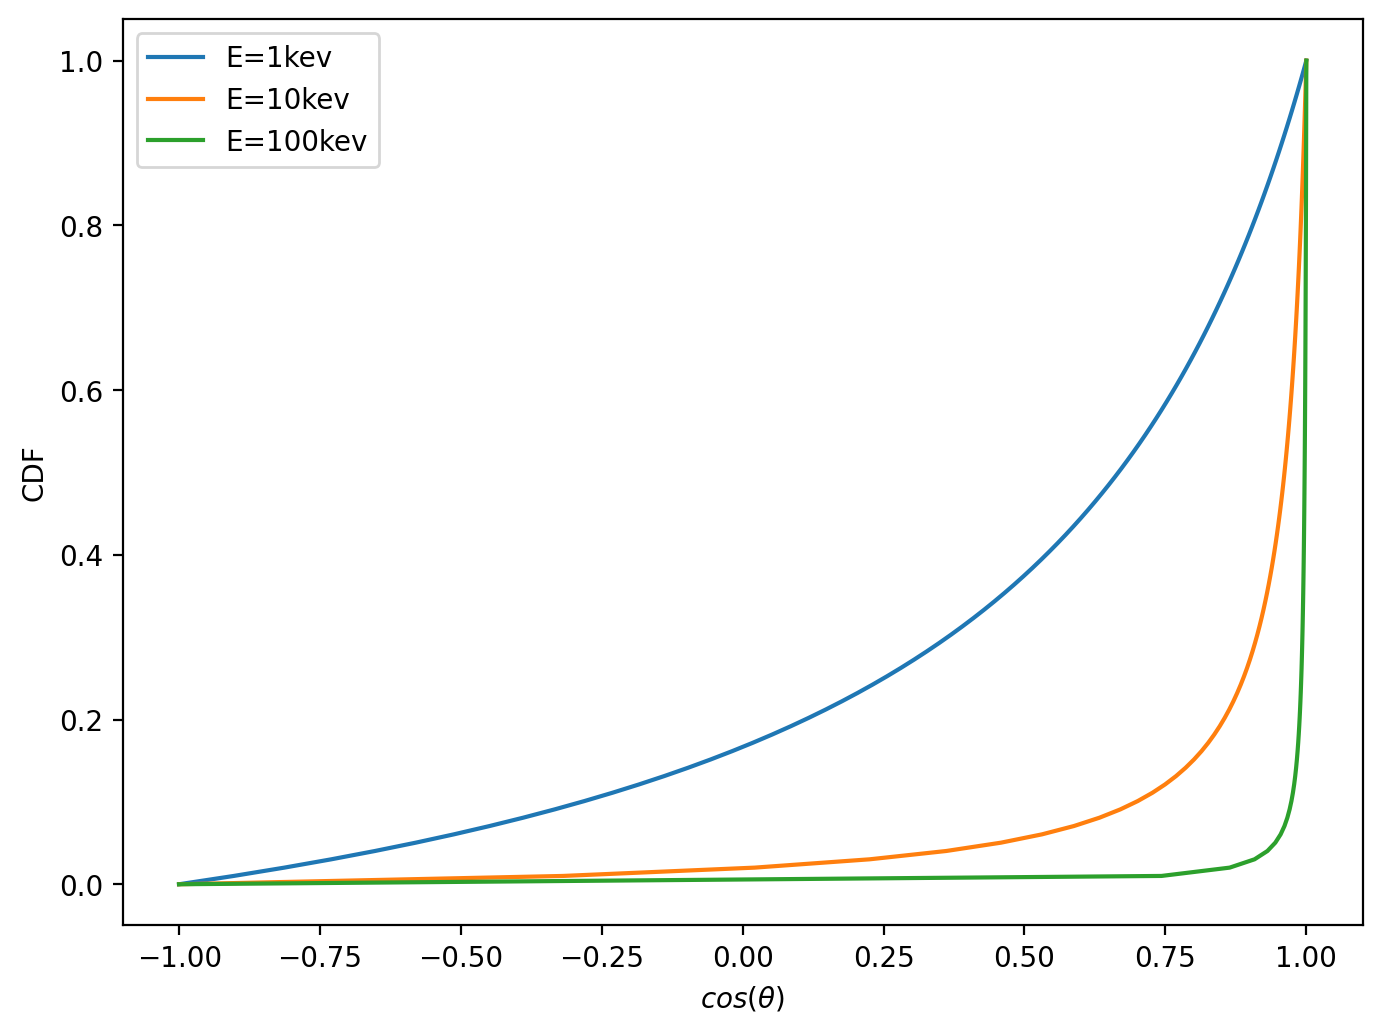

In [3]:

E_arr_kev = np.array([1,10,100])
E_arr = E_arr_kev * 1000 /  6.242e+18 
cdf_val = np.linspace(0,1,100)
plt.figure(figsize = [8,6], dpi = 200)
for i in range(len(E_arr)):
    E = E_arr[i]
    epsilon = E/(m*c**2) # parentheses are unclear in the paper
    gamma_c = 0.6*E**(-0.09)
    gamma = gamma_c * 6.22e-5 / (epsilon*(epsilon + 2))
    N = 1 / (4*gamma*(1+gamma))
    cos_theta = - 1/(N*(2*cdf_val + (1/(2*N*(1+gamma))))) + 1 + 2*gamma
    plt.plot(cos_theta,cdf_val, label = 'E='+str(E_arr_kev[i])+'kev')
plt.legend()
plt.xlabel(r'$cos(\theta)$')
plt.ylabel('CDF')

Text(0, 0.5, 'Probability')

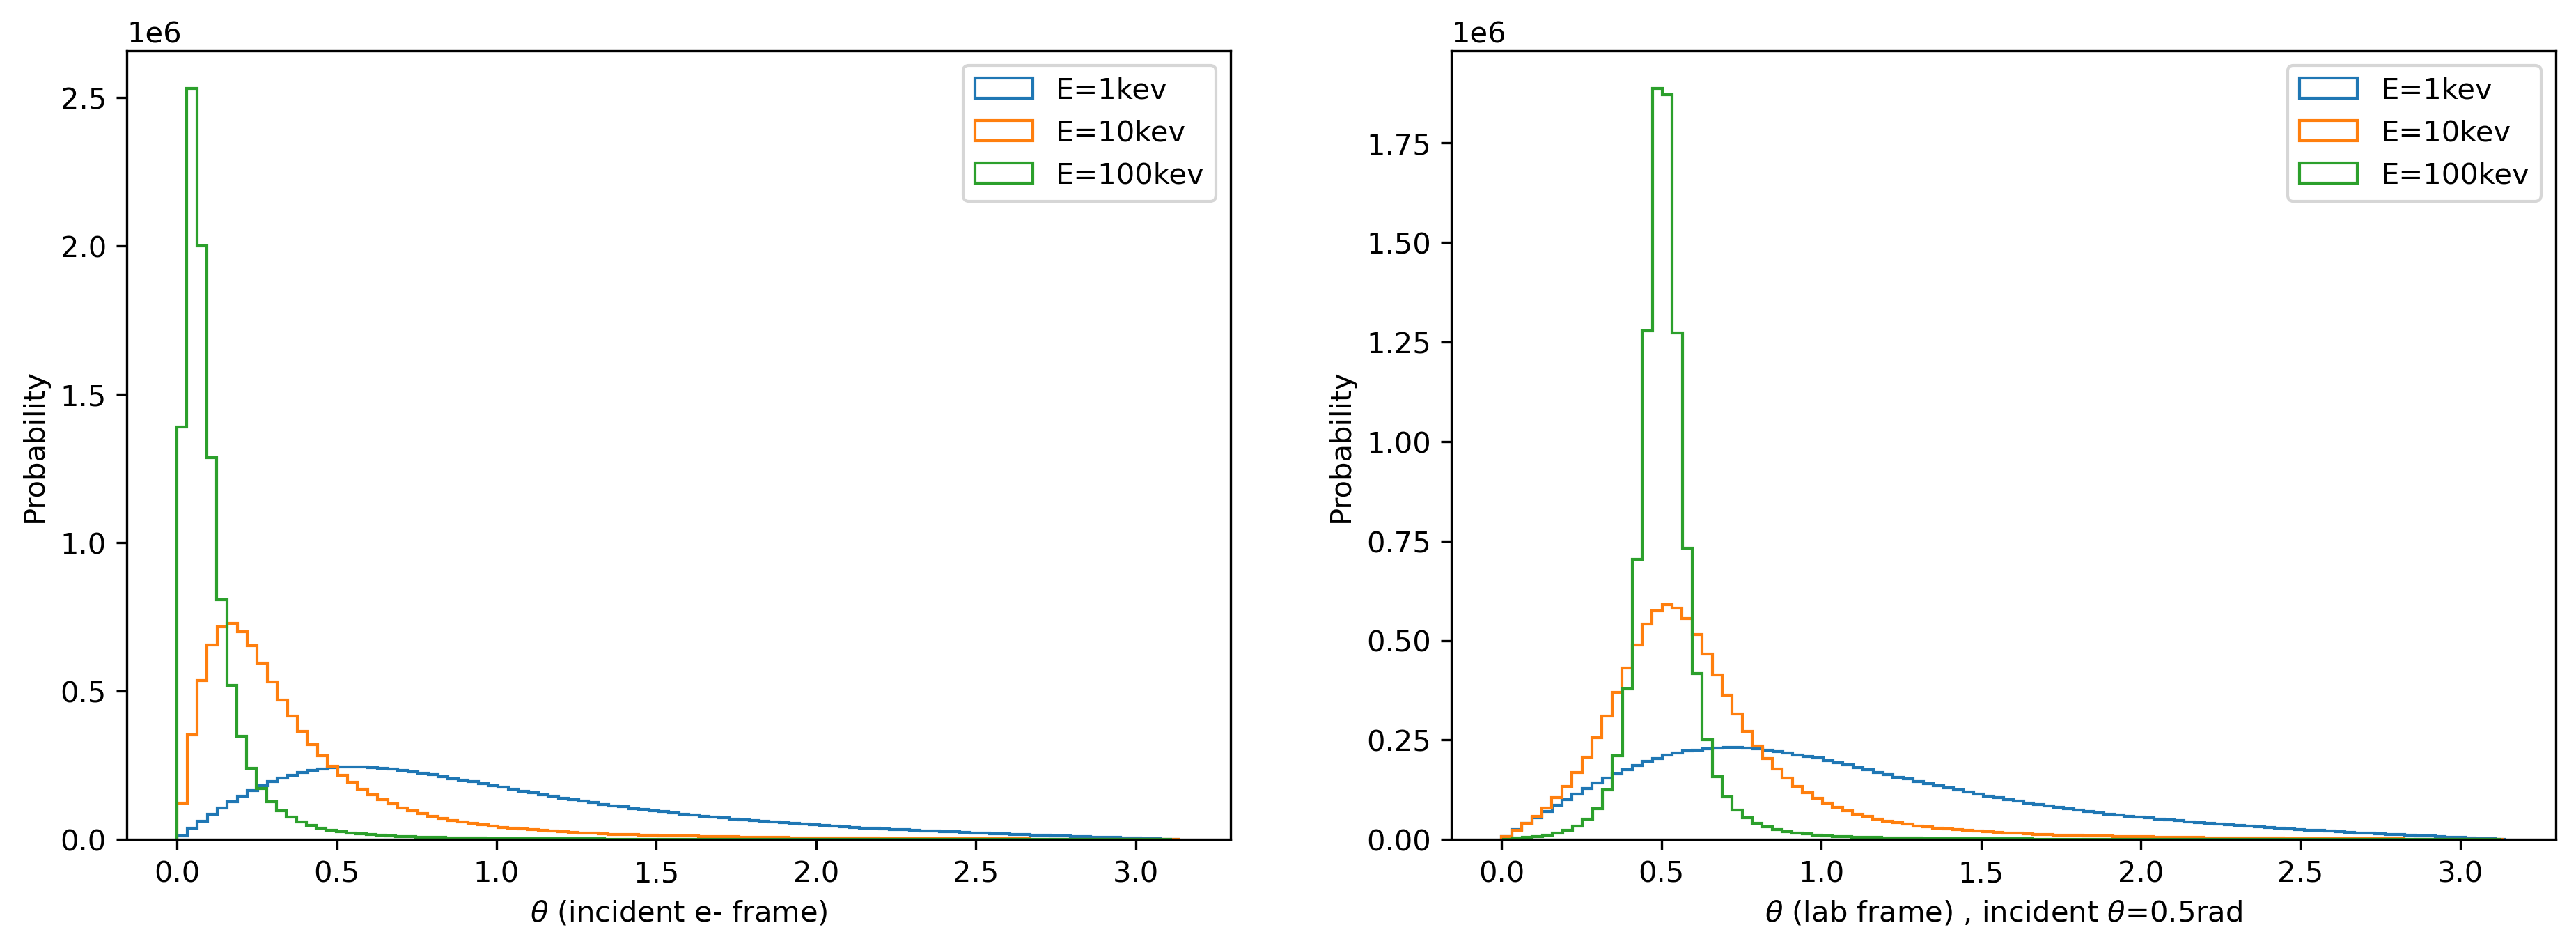

In [9]:
# just checking the actual function called in the simulation
v = 10 # just an arbitraty magnitude
E_arr_kev = np.array([1,10,100])
E_arr = E_arr_kev * 1000 /  6.242e+18 
m =  9.1093837e-31
inc_theta = 0.5 # radians
plt.figure(figsize = [15,5], dpi = 300)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for i in range(len(E_arr)):
    E = E_arr[i]
    N = 10000000
    cdf_vals = np.random.uniform(0,1,N)
    thetas = utils.pick_theta_v3(np.array([E]), m, cdf_vals) # incident electron frame
    phis = np.random.uniform(0, 2*np.pi, N) # incident electron frame
    v_scat_x = v*np.sin(thetas)*np.cos(phis) # x component in frame of incident e-
    v_scat_y = v*np.sin(thetas)*np.sin(phis) # y component in frame of incident e-
    v_scat_z = v*np.cos(thetas) # z component in frame of incident e-    
    v_scat_z_lab, v_scat_h_lab = utils.transform_collapsed(v_scat_x, v_scat_y, v_scat_z, dtheta = inc_theta)
    cos_thetas_lab = v_scat_z_lab / np.sqrt(v_scat_z_lab**2 + v_scat_h_lab**2)
    ax1.hist(thetas, label = 'E='+str(E_arr_kev[i])+'kev', bins = 100, histtype = 'step')#, density = True)
    ax2.hist(np.arccos(cos_thetas_lab), label = 'E='+str(E_arr_kev[i])+'kev', bins = 100, histtype = 'step')#, density = True)
ax1.legend()
ax1.set_xlabel(r'$\theta$ (incident e- frame)')
ax1.set_ylabel('Probability')
ax2.legend()
ax2.set_xlabel(r'$\theta$ (lab frame) , incident $\theta$=' + str(inc_theta) + 'rad')
ax2.set_ylabel('Probability')

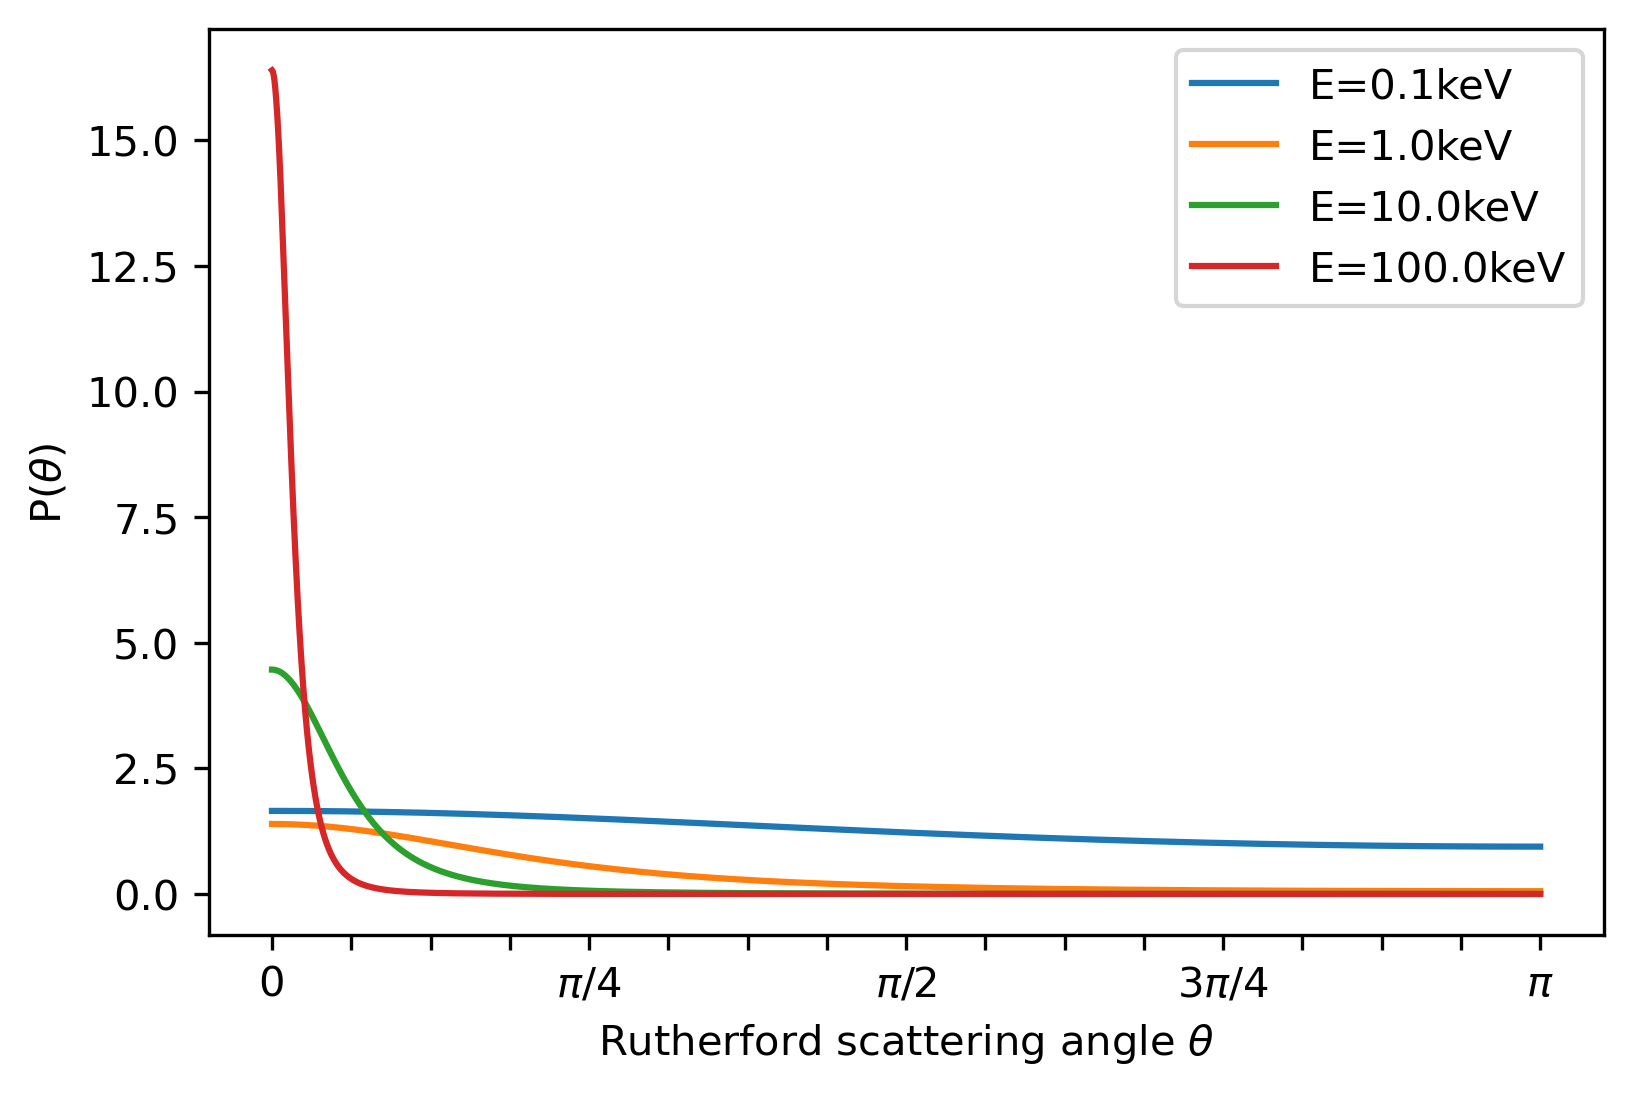

In [52]:
# plot the csf from lummerzhein
from basic_units import radians
E_arr_kev = np.array([0.1,1,10,100])
E_arr = E_arr_kev * 1000 /  6.242e+18 
plt.figure(dpi = 300) # default figsize [6.4, 4.8]
costheta = np.linspace(-1,1, 1000000)
for i in range(len(E_arr)):
    E = E_arr[i]
    epsilon = E/(m*c**2) # parentheses are unclear in the paper
    gamma_c = 0.6*E**(-0.09)
    gamma = gamma_c * 6.22e-5 / (epsilon*(epsilon + 2))
    #beta = 0 #???
    N = 1 / (4*gamma*(1+gamma))
    #T1 = 1 / (1 + 2*gamma + costheta**2)
    pdf = (1/N) * np.abs(1 / (1 + 2*gamma - costheta)**2)
    theta = np.arccos(costheta)
    integral = np.abs(np.trapz(theta, pdf))
    plt.plot(theta, pdf/integral, label = 'E='+str(E_arr_kev[i])+'keV')#, xunits = radians)
plt.legend()
#plt.xlabel(r'cos($\theta$)')# (incident e- frame)')
plt.xlabel(r'Rutherford scattering angle $\theta$')
plt.ylabel(r'P($\theta$)')
#plt.semilogy()
ax = plt.gca()
ax.set_xticks([0, np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4, 5*np.pi/16, 6*np.pi/16, 7*np.pi/16, np.pi/2, 9*np.pi/16, 10*np.pi/16, 11*np.pi/16, 3*np.pi/4, 13*np.pi/16, 14*np.pi/16, 15*np.pi/16, np.pi]*radians)
ax.set_xticklabels(['0', '', '', '', r'$\pi$/4', '', '', '', r'$\pi$/2', '', '', '', r'3$\pi$/4', '', '', '', r'$\pi$'])
ax.xaxis.grid(True, which='minor')



### Density Profiles

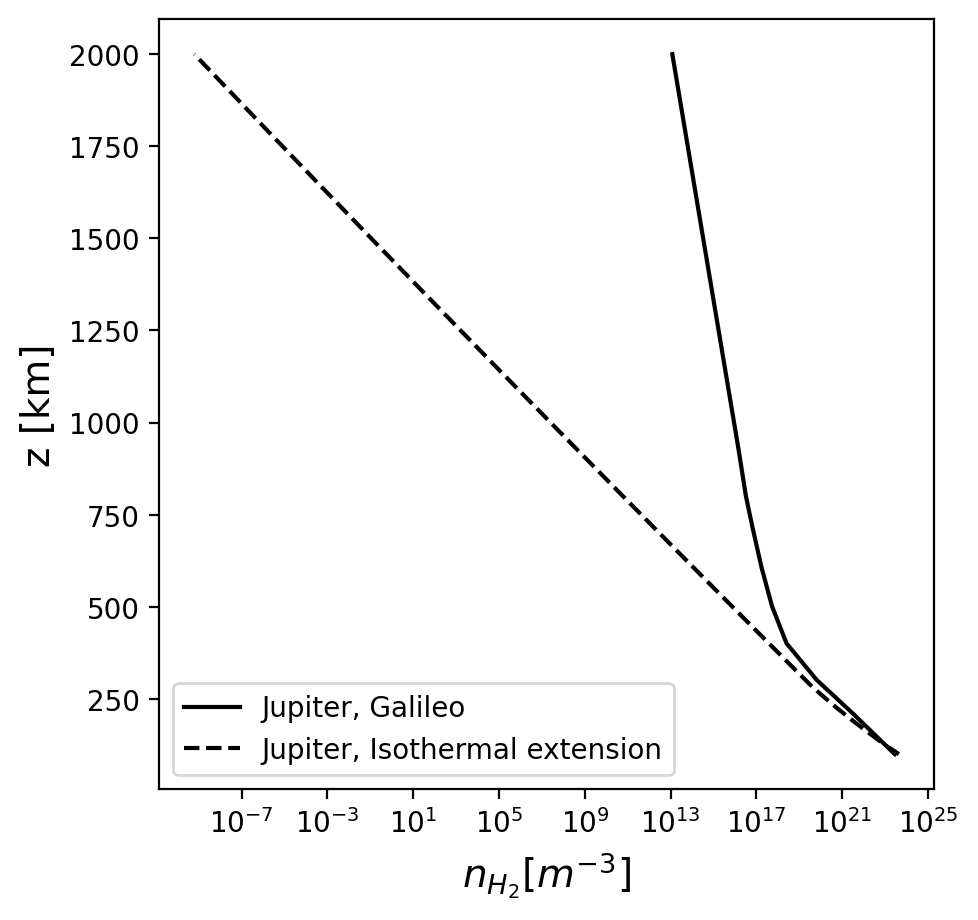

In [4]:
# plot density profiles
import matplotlib
from matplotlib.ticker import FormatStrFormatter

z_max_Jupiter = 2000e3
z_min_Jupiter = 100e3
z_max_T900_g5 = 37.612e3
z_min_T900_g5 = 10e3
z_max_T1400_g4 = 755.560e3
z_min_T1400_g4 = 250e3
z_max_T1400_g5 = 71.970e3
z_min_T1400_g5 = 15e3 
z_max_T900_g4 = 398.090e3
z_min_T900_g4 = 140e3 
z_max_T2000_g5 = 92.236e3
z_min_T2000_g5 =  25e3 
z_max_T482_g4point7 = 37.942e3
z_min_T482_g4point7 =  10e3

z_T1400_g4 = np.linspace(z_min_T1400_g4, z_max_T1400_g4, 1000)  #m
z_T900_g5 = np.linspace(z_min_T900_g5, z_max_T900_g5, 1000)  #m
z_Jupiter = np.linspace(z_min_Jupiter, z_max_Jupiter, 1000)  #m
# z1 = np.logspace(-100, 500) * 1e3 #m
# z2 = np.logspace(-40, 25) * 1e3 #m
# z3 = np.logspace(0, 2000) * 1e3 #m
#z3 = np.logspace(1, np.log10(2000)) * 1e3 #m
sonora_filepath = './Sonora_data'
get_n_H2_Jupiter_iso, get_P_H2_Jupiter = utils.construct_profiles('Jupiter', 2000e3*1.2, sonora_filepath) # ISOTHERMAL EXTENSION FOR COMPARISON ONLY
get_n_H2_Jupiter_galileo, get_P_H2_Jupiter = utils.construct_profile_Jupiter('Jupiter', 2000e3*1.2, sonora_filepath) # WITH GALILEO DATA
get_n_H2_T1400_g4, get_P_H2_T1400_g4 = utils.construct_profiles('T1400_g4.0', 755.560e3*1.2, sonora_filepath)
get_n_H2_T900_g5, get_P_H2_T900_g5 = utils.construct_profiles('T900_g5.0', 37.612e3*1.2, sonora_filepath)
# P1 = utils.get_pressure_T1400_g4(z1)
# P2 = utils.get_pressure_T900_g5(z2)
# P3 = utils.get_pressure_Jupiter(z3)
# T1400_g4 = utils.n_H2_T1400_g4(z1) * mH2
# T900_g5 = utils.n_H2_T900_g5(z2) * mH2
# Jupiter = utils.n_H2_Jupiter(z3) * mH2
plt.figure(figsize = [5,5], dpi = 200)
#plt.ylabel('P [bar]', fontsize = 14)
plt.ylabel('z [km]', fontsize = 14)
#plt.xlabel('Pressure [Pa]', fontsize = 14)
plt.xlabel(r'$n_{H_2} [m^{-3}]$',  fontsize = 14)
# #plt.plot(T1400_g4, P1 / 1e5, label = r'$T_{eff}=1400K, log(g)=4$')
# plt.plot(Jupiter, P3 / 1e5, label = 'Jupiter')
# #plt.plot(T900_g5, P2 / 1e5, label = 'T-Dwarf') #r'$T_{eff}=900K, log(g)=5$')
# plt.plot(z1/1e3, T1400_g4/mH2, label = r'$T_{eff}=1400K, log(g)=4$')
#plt.plot(z3/1e3, Jupiter/mH2, label = 'Jupiter')
# plt.plot(z2/1e3, T900_g5/mH2, label = r'$T_{eff}=900K, log(g)=5$') #r'$T_{eff}=900K, log(g)=5$')
plt.plot(get_n_H2_Jupiter_galileo(z_Jupiter), z_Jupiter/1e3, color = 'k', ls = 'solid', label = 'Jupiter, Galileo')
plt.plot(get_n_H2_Jupiter_iso(z_Jupiter), z_Jupiter/1e3, color = 'k', ls = 'dashed', label = 'Jupiter, Isothermal extension')
#plt.plot(get_P_H2_Jupiter(z_Jupiter)/1e5, get_n_H2_Jupiter(z_Jupiter), label = 'Jupiter')
#plt.plot(get_P_H2_T1400_g4(z_T1400_g4)/1e5, get_n_H2_T1400_g4(z_T1400_g4), label = r'$T_{eff}=1400K, log(g)=4$')
#plt.plot(get_P_H2_T900_g5(z_T900_g5)/1e5, get_n_H2_T900_g5(z_T900_g5), label = r'$T_{eff}=900K, log(g)=5$') #r'$T_{eff}=900K, log(g)=5$')
ax = plt.gca()
# ax.axvspan(335, 500, alpha = 0.2, color = 'C0')
# ax.axvspan(250, 2000, alpha = 0.2, color = 'C1')
# ax.axvspan(10, 25, alpha = 0.2, color = 'C2')
# z_peak_Jup = 550e3#8e-7 * 1e5 # Pa
# z_peak_900K = 20e3#1e-6 * 1e5 # Pa
# nH2_peak_900K = utils.n_H2_T900_g5(np.array([z_peak_900K]))
# nH2_peak_Jup = utils.n_H2_Jupiter(np.array([z_peak_Jup]))
# print('number density at peak:')
# print('  Jup: ', nH2_peak_Jup)
# print('  900K:', nH2_peak_900K)

#ax.set_yscale('log')
#ax.set_xscale('log')

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
# ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#ax.minorticks_on()
# plt.tick_params(axis='y', which='minor')
# ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
#plt.tick_params(axis='y', which='minor')
plt.semilogx()
#plt.semilogy()
# import matplotlib
# y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
# ax.yaxis.set_major_locator(y_major)
# y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(-10, 1.0) * 0.1, numticks = 10)
# ax.yaxis.set_minor_locator(y_minor)
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#ax.invert_yaxis()
#ax.xaxis.grid(True, which='minor')

#plt.gca().set_yscale('symlog')
plt.legend()


In [5]:
z_grid_Jupiter = np.linspace(z_min_Jupiter,z_max_Jupiter, 1000)
R_grid_Jupiter = utils.construct_R_grid(z_grid_Jupiter, 'Jupiter', z_min_Jupiter, z_max_Jupiter, get_n_H2_Jupiter_Galileo)
N_Jupiter = utils.get_column_density(z_Jupiter, z_grid_Jupiter, R_grid_Jupiter)/mH2

z_grid_T900_g5 = np.linspace(z_min_T900_g5, z_max_T900_g5, 1000)
R_grid_T900_g5 = utils.construct_R_grid(z_grid_T900_g5, 'T900_g5', z_min_T900_g5, z_max_T900_g5, get_n_H2_T900_g5)
N_T900_g5 = utils.get_column_density(z_T900_g5, z_grid_T900_g5, R_grid_T900_g5)/mH2

z_grid_T1400_g4 = np.linspace(z_min_T1400_g4, z_max_T1400_g4, 1000)
R_grid_T1400_g4 = utils.construct_R_grid(z_grid_T1400_g4, 'T1400_g4', z_min_T1400_g4, z_max_T1400_g4, get_n_H2_T1400_g4)
N_T1400_g4 = utils.get_column_density(z_T1400_g4, z_grid_T1400_g4, R_grid_T1400_g4)/mH2

idx_TOA_sonora = np.where(get_P_H2_Jupiter(z_Jupiter) < (1e-6)*1e5)[0][0]
z_sonora_TOA = z_Jupiter[idx_TOA_sonora]
n_sonora_TOA = get_n_H2_Jupiter(z_sonora_TOA)
T_Jupiter = 150.78 # K
g_Jupiter = 24.79 # m/s^2
H_sonora_TOA = k*T_Jupiter/(mH2*g_Jupiter)
z_iso_Jupiter = np.linspace(z_sonora_TOA, z_max_Jupiter, 1000)
isothermal_N_Jupiter = (n_sonora_TOA*H_sonora_TOA) * (-np.exp(-(z_max_Jupiter - z_sonora_TOA)/H_sonora_TOA) + np.exp(-(z_iso_Jupiter - z_sonora_TOA)/H_sonora_TOA))


# plt.plot(N_Jupiter, get_P_H2_Jupiter(z_Jupiter)/1e5, '.', label = 'Jupiter, isothermal')
# plt.plot(N_T900_g5, get_P_H2_T900_g5(z_T900_g5)/1e5, '.', label = 'T=900K, g=5.0')
# plt.plot(N_T1400_g4, get_P_H2_T1400_g4(z_T1400_g4)/1e5, '.', label = 'T=1400K, g=4.0')
plt.figure(figsize = [15,6])
plt.subplot(121)
N_means_Jupiter = np.array([9.052654376411179e+29, 9.039926721141533e+29, 9.033328413751338e+29, 9.018851645104603e+29, 9.011679705305675e+29, 8.995383479572765e+29, 8.989143863866022e+29, 8.97804528678983e+29])
z_means_Jupiter = np.array([249.85053761871083, 298.8256188859777, 324.23386407325626, 380.0231760105178, 407.68420235597426, 470.59251906866734, 494.7000706560592, 537.6104771655699])*1e3
plt.plot(N_Jupiter[:-1], z_Jupiter[:-1]/1e3, label = 'Jupiter  (no Galileo, isothermal)')
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
plt.hlines(z_means_Jupiter/1e3, xmin = xlims[0], xmax = xlims[1], ls = 'dashed', alpha = 0.4, color = 'C0', label = 'Mean ionization heights by energy')
plt.vlines(utils.get_column_density(z_means_Jupiter, z_grid_Jupiter, R_grid_Jupiter)/mH2, ymin = ylims[0], ymax = ylims[1], ls = 'dotted', alpha = 0.4, color = 'C0', label = 'Mean ionization N by energy')
plt.plot(isothermal_N_Jupiter, z_iso_Jupiter/1e3, label = 'Jupiter  (no Galileo, isothermal), analytic', color = 'k', ls = 'dotted')
z_means_T900_g5 = np.array([13.386980015464955, 15.716947307573804, 16.7113277713098, 19.13185003698951, 20.401105300184643, 23.289581290500397, 24.353233337599427, 26.422274582979345])
plt.plot(N_T900_g5[:-1], z_T900_g5[:-1]/1e3, label = 'T=900K, g=5.0')
plt.hlines(z_means_T900_g5, xmin = xlims[0], xmax = xlims[1], ls = 'dashed', alpha = 0.4, color = 'C1', label = 'Mean ionization heights by energy')
z_means_T1400_g4 = np.array([325.8337539605412, 372.2556122465024, 392.58076298903666, 444.21427132492533, 469.9829082759132, 525.9280301399076, 546.7545134521257, 586.096048598352])
plt.plot(N_T1400_g4[:-1], z_T1400_g4[:-1]/1e3, label = 'T=1400K, g=4.0')
plt.hlines(z_means_T1400_g4, xmin = xlims[0], xmax = xlims[1], ls = 'dashed', alpha = 0.4, color = 'C2', label = 'Mean ionization heights by energy')
plt.semilogy()
plt.semilogx()
plt.xlabel(r'column number density of H$_2$ $N$ [m$^{-2}$]')
plt.ylabel('Altitude [km]')
plt.legend()

plt.subplot(122)
plt.plot(N_Jupiter[:-1], get_P_H2_Jupiter(z_Jupiter)[:-1]/1e5, label = 'Jupiter (no Galileo, isothermal)')
plt.plot(N_T900_g5[:-1], get_P_H2_T900_g5(z_T900_g5)[:-1]/1e5, label = 'T=900K, g=5.0')
plt.plot(N_T1400_g4[:-1], get_P_H2_T1400_g4(z_T1400_g4)[:-1]/1e5, label = 'T=1400K, g=4.0')
plt.semilogy()
plt.semilogx()
plt.xlabel(r'column number density of H$_2$ $N$ [m$^{-2}$]')
plt.ylabel('Pressure [bar]')
ax.invert_yaxis()
plt.legend()

NameError: name 'get_n_H2_Jupiter' is not defined

zmax_Jupiter = 2456952.358802677
zmax_T1400_g4 = 755560.7886725978
zmax_T1400_g5 = 71970.85822743073
zmax_T900_g4 = 398090.75128354336
zmax_T900_g5 = 37612.013999538205
zmax_T2000_g5 = 92236.27018682609
zmax_T482_g4point7 = 37942.52394835485


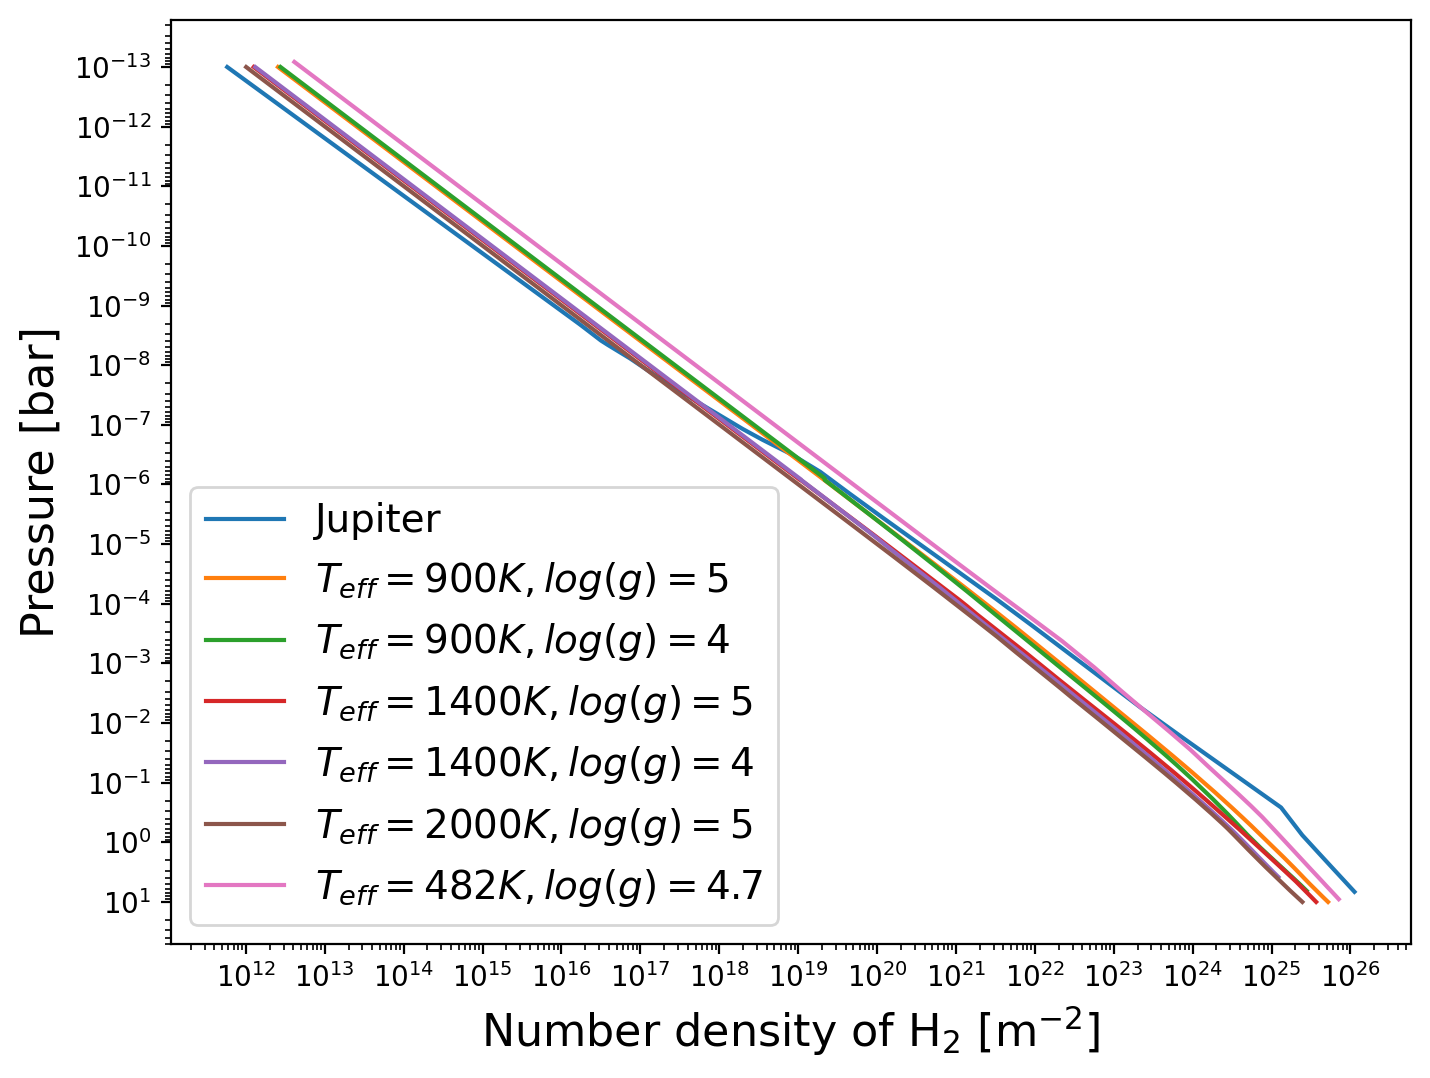

In [72]:
# plot density profiles
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker as mticker
sonora_filepath = './Sonora_data'
zmax_Jupiter = 2456952.358802677
zmax_T1400_g4 = 755560.7886725978
zmax_T1400_g5 = 71970.85822743073
zmax_T900_g4 = 398090.75128354336
zmax_T900_g5 = 37612.013999538205
zmax_T2000_g5 = 92236.27018682609
zmax_T482_g4point7 = 37942.52394835485
z_T1400_g4 = np.linspace(-100e3, zmax_T1400_g4, 5000)  #m
z_T900_g4 = np.linspace(-100e3, zmax_T900_g4, 5000)  #m
z_T900_g5 = np.linspace(-100e3, zmax_T900_g5, 5000)  #m
z_T1400_g5 = np.linspace(-100e3, zmax_T1400_g5, 5000)  #m
z_T2000_g5 = np.linspace(-100e3, zmax_T2000_g5, 5000)  #m
z_Jupiter = np.linspace(-100e3, zmax_Jupiter, 100)  #m
z_T482_g4point7 = np.linspace(-12e3, zmax_T482_g4point7 ) #m

nH2_Jupiter, PH2_Jupiter = utils.construct_profile_Jupiter('Jupiter', zmax_Jupiter, sonora_filepath)
nH2_T1400_g4, PH2_T1400_g4 = utils.construct_profiles('T1400_g4.0', zmax_T1400_g4, sonora_filepath)
nH2_T1400_g5, PH2_T1400_g5 = utils.construct_profiles('T1400_g5.0', zmax_T1400_g5, sonora_filepath)
nH2_T900_g4, PH2_T900_g4 = utils.construct_profiles('T900_g4.0', zmax_T900_g4, sonora_filepath)
nH2_T900_g5, PH2_T900_g5 = utils.construct_profiles('T900_g5.0', zmax_T900_g5, sonora_filepath)
nH2_T482_g4point7, PH2_T482_g4point7 = utils.construct_profiles('T482_g4.7', zmax_T482_g4point7, sonora_filepath)
nH2_T2000_g5, PH2_T2000_g5 = utils.construct_profiles('T2000_g5.0', zmax_T2000_g5, sonora_filepath)

print('zmax_Jupiter =', z_Jupiter[PH2_Jupiter(z_Jupiter)/1e5 < 1e-13][0])
print('zmax_T1400_g4 =', z_T1400_g4[PH2_T1400_g4(z_T1400_g4)/1e5 < 1e-13][0])
print('zmax_T1400_g5 =', z_T1400_g5[PH2_T1400_g5(z_T1400_g5)/1e5 < 1e-13][0])
print('zmax_T900_g4 =', z_T900_g4[PH2_T900_g4(z_T900_g4)/1e5 < 1e-13][0])
print('zmax_T900_g5 =', z_T900_g5[PH2_T900_g5(z_T900_g5)/1e5 < 1e-13][0])
print('zmax_T2000_g5 =', z_T2000_g5[PH2_T2000_g5(z_T2000_g5)/1e5 < 1e-13][0])
print('zmax_T482_g4point7 =', z_T482_g4point7[PH2_T482_g4point7(z_T482_g4point7)/1e5 < 1e-13][0])


fs = 16
plt.figure(figsize = [8,6], dpi = 200)
plt.ylabel('Pressure [bar]', fontsize = fs)
#plt.ylabel('Altitude [km]', fontsize = 14)
#plt.xlabel('Pressure [Pa]', fontsize = 14)
plt.xlabel(r'Number density of H$_{2}$ [m$^{-2}$]',  fontsize = fs)
# #plt.plot(T1400_g4, P1 / 1e5, label = r'$T_{eff}=1400K, log(g)=4$')
# plt.plot(Jupiter, P3 / 1e5, label = 'Jupiter')
# #plt.plot(T900_g5, P2 / 1e5, label = 'T-Dwarf') #r'$T_{eff}=900K, log(g)=5$')
# plt.plot(z1/1e3, T1400_g4/mH2, label = r'$T_{eff}=1400K, log(g)=4$')
# plt.plot(z3/1e3, Jupiter/mH2, label = 'Jupiter')
# plt.plot(z2/1e3, T900_g5/mH2, label = r'$T_{eff}=900K, log(g)=5$') #r'$T_{eff}=900K, log(g)=5$')

# plt.plot(z_Jupiter/1e3, PH2_Jupiter(z_Jupiter)/1e5, label = 'Jupiter')
# plt.plot(z_T1400_g4/1e3, PH2_T1400_g4(z_T1400_g4)/1e5, label = r'$T_{eff}=1400K, log(g)=4$')
# plt.plot(z_T900_g5/1e3, PH2_T900_g5(z_T900_g5)/1e5, label = r'$T_{eff}=900K, log(g)=5$') #r'$T_{eff}=900K, log(g)=5$')
# plt.plot(z_T900_g4/1e3, PH2_T900_g4(z_T900_g4)/1e5, label = r'$T_{eff}=900K, log(g)=4$')
# plt.plot(z_T1400_g5/1e3, PH2_T1400_g5(z_T1400_g5)/1e5, label = r'$T_{eff}=1400K, log(g)=5$')
# plt.plot(z_T2000_g5/1e3, PH2_T2000_g5(z_T2000_g5)/1e5, label = r'$T_{eff}=2000K, log(g)=5$')
# plt.plot(z_T482_g4point7/1e3, PH2_T482_g4point7(z_T482_g4point7)/1e5, label = r'$T_{eff}=482K, log(g)=4.7$')
P_lim = 1e6
plt.plot(nH2_Jupiter(z_Jupiter)[PH2_Jupiter(z_Jupiter)<P_lim], PH2_Jupiter(z_Jupiter)[PH2_Jupiter(z_Jupiter)<P_lim]/1e5, label = 'Jupiter')
plt.plot(nH2_T900_g5(z_T900_g5)[PH2_T900_g5(z_T900_g5)<P_lim], PH2_T900_g5(z_T900_g5)[PH2_T900_g5(z_T900_g5)<P_lim]/1e5, label = r'$T_{eff}=900K, log(g)=5$') #r'$T_{eff}=900K, log(g)=5$')
plt.plot(nH2_T900_g4(z_T900_g4)[PH2_T900_g4(z_T900_g4)<P_lim], PH2_T900_g4(z_T900_g4)[PH2_T900_g4(z_T900_g4)<P_lim]/1e5, label = r'$T_{eff}=900K, log(g)=4$')
plt.plot(nH2_T1400_g5(z_T1400_g5)[PH2_T1400_g5(z_T1400_g5)<P_lim], PH2_T1400_g5(z_T1400_g5)[PH2_T1400_g5(z_T1400_g5)<P_lim]/1e5, label = r'$T_{eff}=1400K, log(g)=5$')
plt.plot(nH2_T1400_g4(z_T1400_g4)[PH2_T1400_g4(z_T1400_g4)<P_lim], PH2_T1400_g4(z_T1400_g4)[PH2_T1400_g4(z_T1400_g4)<P_lim]/1e5, label = r'$T_{eff}=1400K, log(g)=4$')
plt.plot(nH2_T2000_g5(z_T2000_g5)[PH2_T2000_g5(z_T2000_g5)<P_lim], PH2_T2000_g5(z_T2000_g5)[PH2_T2000_g5(z_T2000_g5)<P_lim]/1e5, label = r'$T_{eff}=2000K, log(g)=5$')
plt.plot(nH2_T482_g4point7(z_T482_g4point7)[PH2_T482_g4point7(z_T482_g4point7)<P_lim], PH2_T482_g4point7(z_T482_g4point7)[PH2_T482_g4point7(z_T482_g4point7)<P_lim]/1e5, label = r'$T_{eff}=482K, log(g)=4.7$')
ax = plt.gca()
#plt.ylim(ylims[0],)
# ax.axvspan(335, 500, alpha = 0.2, color = 'C0')
# ax.axvspan(250, 2000, alpha = 0.2, color = 'C1')
# ax.axvspan(10, 25, alpha = 0.2, color = 'C2')
# z_peak_Jup = 550e3#8e-7 * 1e5 # Pa
# z_peak_900K = 20e3#1e-6 * 1e5 # Pa
# nH2_peak_900K = utils.n_H2_T900_g5(np.array([z_peak_900K]))
# nH2_peak_Jup = utils.n_H2_Jupiter(np.array([z_peak_Jup]))
# print('number density at peak:')
# print('  Jup: ', nH2_peak_Jup)
# print('  900K:', nH2_peak_900K)

## ax.set_yscale('log')
## ax.set_xscale('log')

#locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
# ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

#ax.minorticks_on()
# plt.tick_params(axis='y', which='minor')
# ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
#plt.tick_params(axis='y', which='minor')
#plt.semilogx()
plt.semilogy()
# import matplotlib
# y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
# ax.yaxis.set_major_locator(y_major)
#y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(-10, 1.0) * 0.1, numticks = 10)
#ax.yaxis.set_minor_locator(y_minor)
#ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ylims = ax.get_ylim()
#plt.ylim(1e-13, 1e5)
ax.invert_yaxis()
#ax.xaxis.grid(True, which='minor')
#plt.gca().set_yscale('symlog')
plt.legend(fontsize = fs*(14/16))
xlims = ax.get_xlim()
ax = plt.gca()
#plt.ylim([1e0,1e-12])
#ax.set_ymargin(0.1) 
#ax.margins(y=0.1)
#ax.set_yscale('symlog')
#plt.xlim([xlims[0], 2000])

ax.set_xscale('log')
ax.xaxis.get_major_locator().set_params(numticks=99)
ax.xaxis.get_minor_locator().set_params(numticks=99, subs=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

ax.yaxis.get_major_locator().set_params(numticks=99)
ax.yaxis.get_minor_locator().set_params(numticks=99, subs=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

plt.savefig('./paper_plots/density_profiles.pdf', format = 'pdf', bbox_inches="tight")

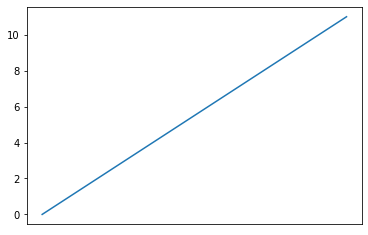

In [19]:
y = np.arange(12)
x = 10.0**y
fig, ax=plt.subplots()
ax.plot(x,y)
ax.set_xscale("log")
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,1.0, ))
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10 )) 
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


### Cross sections

In [2]:
importlib.reload(utils)
E_rot_excitation = 0.0438 # [eV] * u.eV # 50 * u.eV # [eV] energy lost to excitation in excitation interaction, from MCCC database "threshold energy"
E_vib_excitation = 8.77596948e-01 # [eV] * u.eV # "threshold energy" from MCCC database
E_C_excitation = 1.22910e1 # [eV] * u.eV # "threshold energy" from MCCC database
E_B_excitation = 1.11829e1 # [eV] * u.eV # "threshold energy" from MCCC database
E_a_excitation = 1.17934e1 # [eV] * u.eV # "threshold energy" from MCCC database
E_b_excitation = 4.47713e0 # [eV] * u.eV # "threshold energy" from MCCC database
E_c_excitation = 1.21569e1 # [eV] * u.eV # "threshold energy" from MCCC database
#E_d_excitation = 1.38553e1 * u.eV # "threshold energy" from MCCC database
E_e_excitation = 1.32260E+01 # [eV] * u.eV # "threshold energy" from MCCC database
E_threshold = 1.60218e-19*6.241509e18 #[eV] # 1 eV in J, energy for which ionization cross section equation doesn't hold
E_ion = 15.43 # [eV] * u.eV # eV to ionize H2 (or is it twice this?). This is "binding energy" on NIST, is that same thing?

In [3]:
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 5))),
     ('densely dotted',        (0, (1, 1))),

     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

/projects/anzu2965/SPI/beam_sim/utils.py:1885: RuntimeWarning: invalid value encountered in power
  sigma = a0 * (x-1)**(-a1**2) * np.exp(-a2/(x-1)**a3) * np.heaviside(x-1, 0)


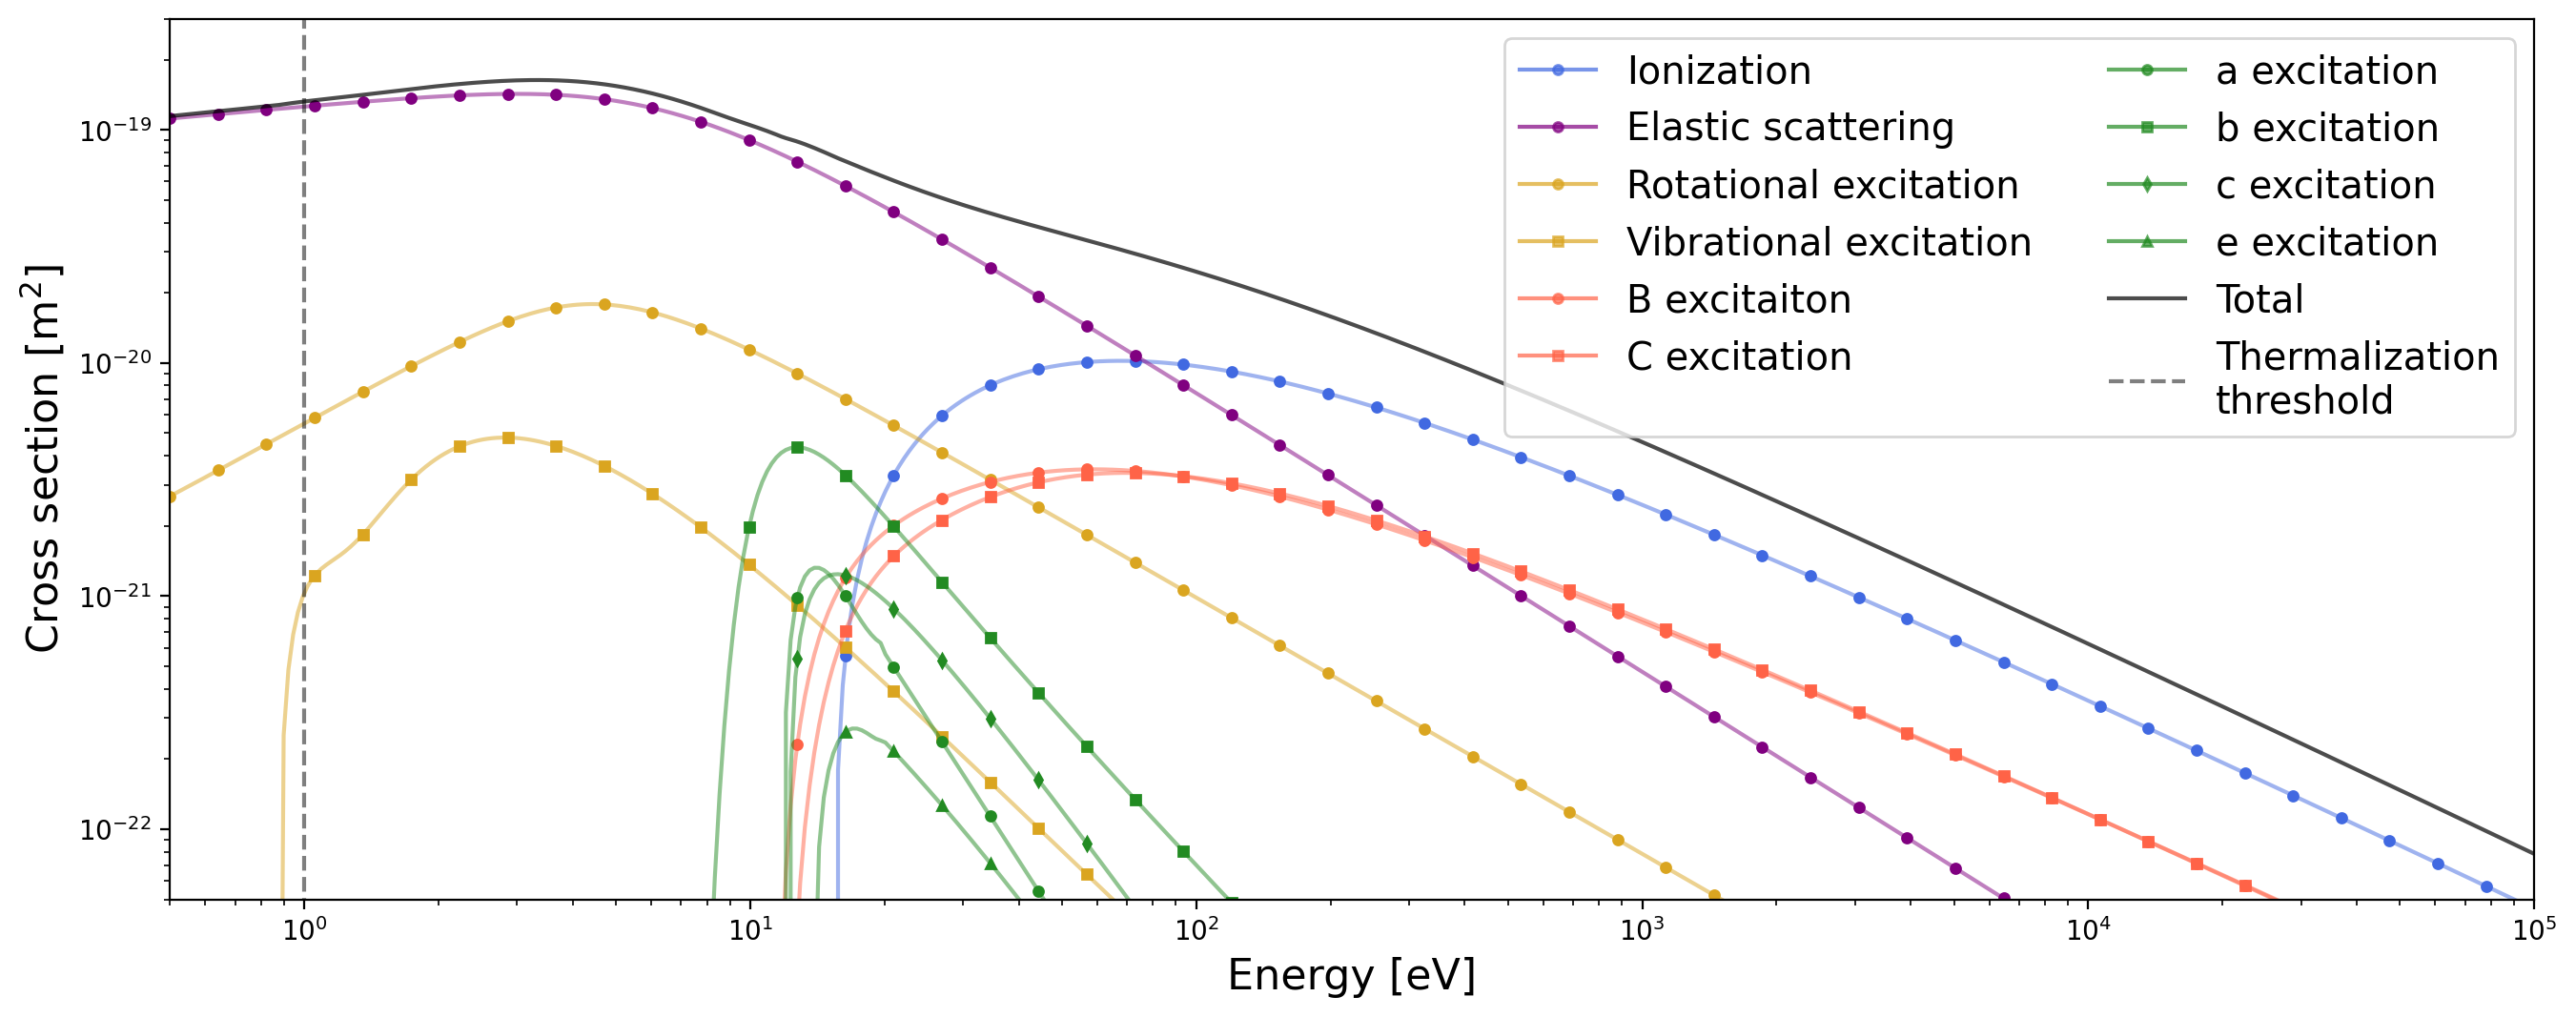

In [11]:
fs = 16

E_min = 0.5
E_max = 1e5
E = np.logspace(np.log10(E_min),np.log10(E_max),500)  # eV
E_markers = np.logspace(np.log10(E_min),np.log10(E_max),50)  # eV
xsec1 = utils.ionization_xsec(E/6.242e+18) # convert enrgy to J
xsec2 = utils.rot_excitation_xsec(E/6.242e+18)
xsec3 = utils.elastic_scat_xsec(E/6.242e+18)
xsec4 = utils.B_excitation_xsec(E/6.242e+18)
xsec5 = utils.C_excitation_xsec(E/6.242e+18)
xsec6 = utils.vib_excitation_xsec(E/6.242e+18)
xsec7 = utils.b_excitation_xsec(E/6.242e+18)
xsec8 = utils.c_excitation_xsec(E/6.242e+18)
xsec9 = utils.e_excitation_xsec(E/6.242e+18)
xsec10 = utils.a_excitation_xsec(E/6.242e+18)
xsecs = [utils.ionization_xsec, utils.elastic_scat_xsec, utils.rot_excitation_xsec, utils.vib_excitation_xsec, utils.B_excitation_xsec, utils.C_excitation_xsec, utils.a_excitation_xsec, utils.b_excitation_xsec, utils.c_excitation_xsec, utils.e_excitation_xsec]
labels = ['Ionization', 'Elastic scattering', 'Rotational excitation', 'Vibrational excitation', 'B excitaiton', 'C excitation', 'a excitation', 'b excitation', 'c excitation', 'e excitation' ]
xsec_tot = xsec1 + xsec2 + xsec3 + xsec4 + xsec5 + xsec6 + xsec7 + xsec8 + xsec9 + xsec10
plt.figure(figsize= [16,6], dpi = 200)
# ax = plt.gca()
# n = 
# ax.set_prop_cycle('color',[cmap[int(i)] for i in np.linspace(0, n-1, n)])
colors = ['royalblue', 'purple', 'goldenrod', 'goldenrod', 'tomato', 'tomato', 'forestgreen', 'forestgreen', 'forestgreen', 'forestgreen']
markers = ['.', '.', '.', 's', '.', 's', '.', 's', 'd', '^']
#ms = [5, 5, 5, 3, 5, 3, 5, 3, 3, 3] * 50
ms = np.array([6, 6, 6, 3, 6, 3, 6, 3, 3, 3, 6]) * 1.2
alpha = 0.7
#plt.plot([],[], label = 'Interaction Type', ls = None, color = 'white')
for i in range(len(xsecs)):
    plt.plot(E, xsecs[i](E/6.242e+18), color = colors[i], alpha = 0.5)
    plt.plot(E_markers, xsecs[i](E_markers/6.242e+18), markers[i], color = colors[i], markersize = ms[i])
    plt.plot([],[], markers[i], ls = 'solid', color = colors[i], markersize = ms[i], label = labels[i], alpha = alpha)
# plt.plot(E, xsec1, label = 'Ionization', ls = 'solid', color = colors[0])# color = colors[0], ls = 'solid')
# plt.plot(E_markers, utils.ionization_xsec(E_markers/6.242e+18), '.', color = colors[0])# color = colors[0], ls = 'solid')
# plt.plot(E, xsec3, label = 'Elastic scattering', ls = 'solid', color = colors[1])#, ls = (0, (5, 10)))
# plt.plot(E_markers, utils.elastic_scat_xsec(E_markers/6.242e+18), '.', color = colors[1])# color = colors[0], ls = 'solid')
# plt.plot(E, xsec2, label = 'Rotational excitation', ls = 'solid', color = colors[2])#, ls = 'dotted')
# plt.plot(E_markers, utils.rot_excitation_xsec(E_markers/6.242e+18), '.', color = colors[2])
# plt.plot(E, xsec6, label = 'Vibrational excitation', ls = 'solid', color = colors[2])#, ls = 'dashdot')
# plt.plot(E_markers, utils.vib_excitation_xsec(E_markers/6.242e+18), 's', markersize = ms, color = colors[2])
# plt.plot(E, xsec4, label = 'B excitation', color = colors[3], ls = 'solid')# ls = (0, (3, 5, 1, 5, 1, 5)))
# plt.plot(E_markers, utils.B_excitation_xsec(E_markers/6.242e+18), '.', color = colors[3])
# plt.plot(E, xsec5, label = 'C excitation', color = colors[3], ls = 'solid')# ls = (0, (3, 1, 1, 1, 1, 1)))
# plt.plot(E_markers, utils.C_excitation_xsec(E_markers/6.242e+18), 's', markersize = ms, color = colors[3])
# plt.plot(E, xsec10, label = 'a excitation', color = colors[4], ls = 'solid')# ls = (0, (5, 1)))
# plt.plot(E_markers, utils.a_excitation_xsec(E_markers/6.242e+18), '.', color = colors[4])
# plt.plot(E, xsec7, label = 'b excitation', color = colors[4], ls = 'solid')# ls = (0, (1, 1)))
# plt.plot(E_markers, utils.b_excitation_xsec(E_markers/6.242e+18), 's', markersize = ms, color = colors[4])
# plt.plot(E, xsec8, label = 'c excitation', color = colors[4], ls = 'solid')# ls = (5, (10, 3)))
# plt.plot(E_markers, utils.c_excitation_xsec(E_markers/6.242e+18), 'd', color = colors[4])
# plt.plot(E, xsec9, label = 'e excitation', color = colors[4], ls = 'solid')# ls = 'dashed')
# plt.plot(E_markers, utils.e_excitation_xsec(E_markers/6.242e+18), '^', color = colors[4])
plt.plot(E, xsec_tot, label = 'Total', color = 'k', ls = 'solid', alpha = alpha)
plt.semilogx()
plt.semilogy()
ylims = plt.gca().get_ylim()
a = 0.5
thresholds_style = 'dashed'
# plt.vlines([E_ion], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[0]) 
# plt.vlines([E_rot_excitation], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[2]) 
# plt.vlines([E_vib_excitation], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[3])
# plt.vlines([E_B_excitation], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[4])
# plt.vlines([E_C_excitation], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[5])
# plt.vlines([E_a_excitation], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[6])
# plt.vlines([E_b_excitation], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[7])
# plt.vlines([E_c_excitation], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[8])
# plt.vlines([E_e_excitation], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = colors[9])
plt.vlines([E_threshold], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = 'k', label = 'Thermalization\nthreshold')
#plt.arrow(E_rot_excitation,ylims[1],4,4,width=0.2)
ax = plt.gca()
arrowmin = 2e-24
arrowmax = 5e-24
lw=1
# ax.annotate("", xytext=(E_rot_excitation, arrowmin), xy=(E_rot_excitation,arrowmax),
#             arrowprops=dict(arrowstyle="->", linestyle='dotted',color = colors[2],linewidth=lw))
# ax.annotate("", xytext=(E_vib_excitation, arrowmin), xy=(E_vib_excitation,arrowmax),
#             arrowprops=dict(arrowstyle="->", color = colors[2], ls = 'dashdot',linewidth=lw))
# ax.annotate("", xytext=(E_B_excitation, arrowmin), xy=(E_B_excitation,arrowmax),
#             arrowprops=dict(arrowstyle="->", color = colors[3], ls = (0, (3, 5, 1, 5, 1, 5)),linewidth=lw))
# ax.annotate("", xytext=(E_C_excitation, arrowmin), xy=(E_C_excitation,arrowmax),
#             arrowprops=dict(arrowstyle="->", color = colors[3], ls = (0, (3, 1, 1, 1, 1, 1)),linewidth=lw))
# ax.annotate("", xytext=(E_a_excitation, arrowmin), xy=(E_a_excitation,arrowmax),
#             arrowprops=dict(arrowstyle="->", color = colors[4], ls = (0, (5, 1)) ,linewidth=lw))
# ax.annotate("", xytext=(E_b_excitation, arrowmin), xy=(E_b_excitation,arrowmax),
#             arrowprops=dict(arrowstyle="->", color = colors[4], ls = (0, (1, 1)),linewidth=lw))
# ax.annotate("", xytext=(E_c_excitation, arrowmin), xy=(E_c_excitation,arrowmax),
#             arrowprops=dict(arrowstyle="->", color = colors[4], ls = (5, (10, 3)),linewidth=lw))
# ax.annotate("", xytext=(E_e_excitation, arrowmin), xy=(E_e_excitation,arrowmax),
#             arrowprops=dict(arrowstyle="->", color = colors[4], ls = 'dashed',linewidth=lw))
#plt.vlines([E_threshold], ymin = ylims[0], ymax = ylims[1], alpha = 1.0, lw = 2, ls = 'dotted', color = 'k', label = 'removed from simulation')
plt.ylim([5e-23, 3e-19])
plt.xlim([E_min, E_max])
plt.xlabel('Energy [eV]', fontsize = fs)
plt.ylabel(r'Cross section [m$^2$]', fontsize = fs)
#plt.plot([], [], alpha = a, color = 'k', marker='|', label = 'Thermalization')#ls = thresholds_style)
leg = plt.legend(fontsize = fs*0.9, ncol = 2, framealpha = 0.8)#, title = 'Interaction Type')


plt.savefig('./paper_plots/cross_sections_v4.pdf', format = 'pdf', bbox_inches="tight")

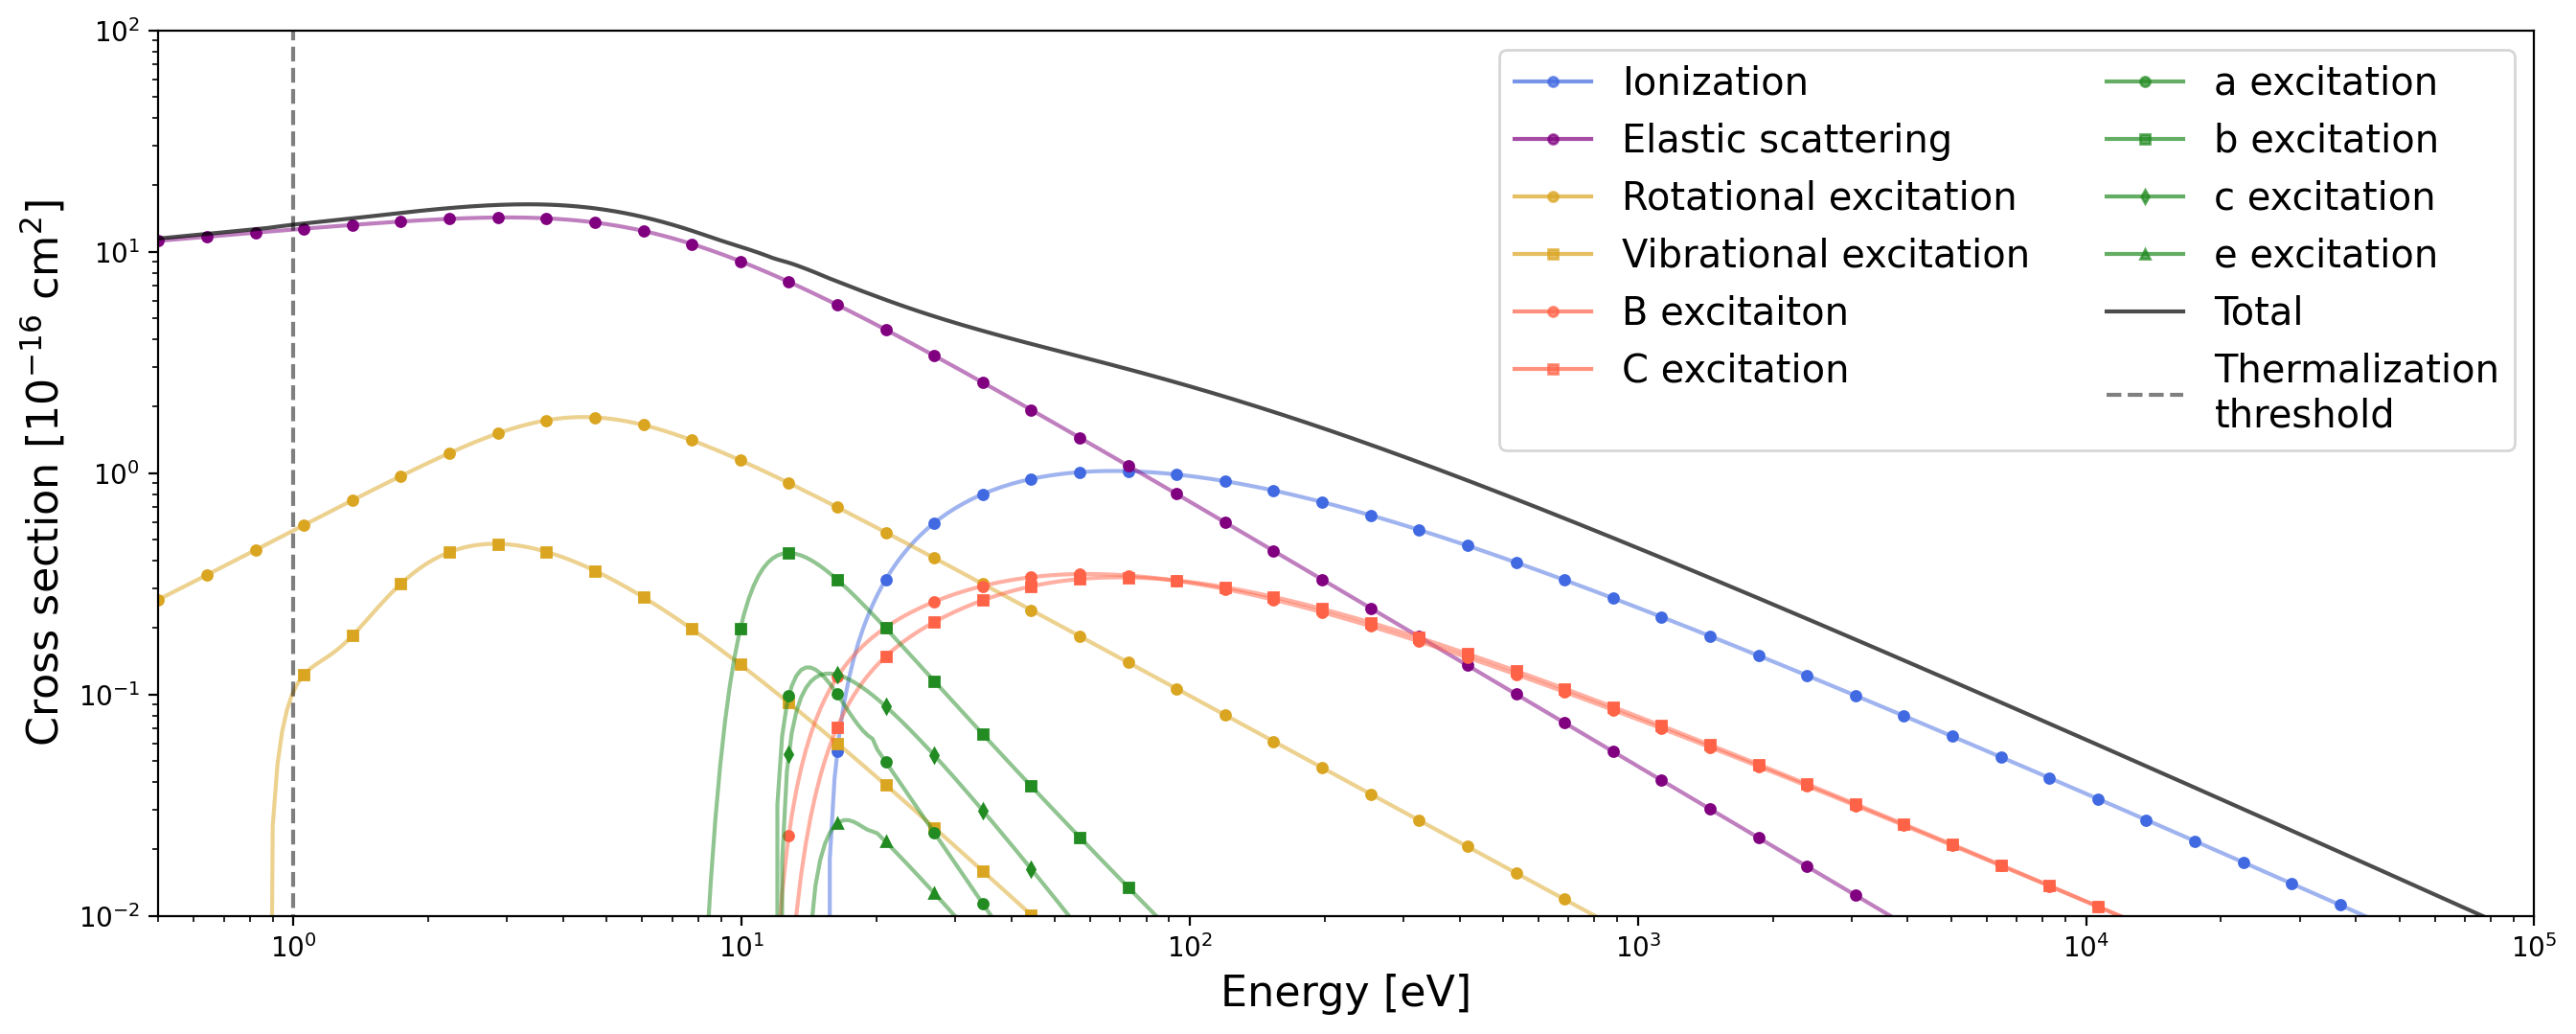

In [9]:
fs = 16

E_min = 0.5
E_max = 1e5
E = np.logspace(np.log10(E_min),np.log10(E_max),500)  # eV
E_markers = np.logspace(np.log10(E_min),np.log10(E_max),50)  # eV
xsec1 = utils.ionization_xsec(E/6.242e+18) # convert enrgy to J
xsec2 = utils.rot_excitation_xsec(E/6.242e+18)
xsec3 = utils.elastic_scat_xsec(E/6.242e+18)
xsec4 = utils.B_excitation_xsec(E/6.242e+18)
xsec5 = utils.C_excitation_xsec(E/6.242e+18)
xsec6 = utils.vib_excitation_xsec(E/6.242e+18)
xsec7 = utils.b_excitation_xsec(E/6.242e+18)
xsec8 = utils.c_excitation_xsec(E/6.242e+18)
xsec9 = utils.e_excitation_xsec(E/6.242e+18)
xsec10 = utils.a_excitation_xsec(E/6.242e+18)
xsecs = [utils.ionization_xsec, utils.elastic_scat_xsec, utils.rot_excitation_xsec, utils.vib_excitation_xsec, utils.B_excitation_xsec, utils.C_excitation_xsec, utils.a_excitation_xsec, utils.b_excitation_xsec, utils.c_excitation_xsec, utils.e_excitation_xsec]
labels = ['Ionization', 'Elastic scattering', 'Rotational excitation', 'Vibrational excitation', 'B excitaiton', 'C excitation', 'a excitation', 'b excitation', 'c excitation', 'e excitation' ]
xsec_tot = xsec1 + xsec2 + xsec3 + xsec4 + xsec5 + xsec6 + xsec7 + xsec8 + xsec9 + xsec10
plt.figure(figsize= [16,6], dpi = 200)
colors = ['royalblue', 'purple', 'goldenrod', 'goldenrod', 'tomato', 'tomato', 'forestgreen', 'forestgreen', 'forestgreen', 'forestgreen']
markers = ['.', '.', '.', 's', '.', 's', '.', 's', 'd', '^']
#ms = [5, 5, 5, 3, 5, 3, 5, 3, 3, 3] * 50
ms = np.array([6, 6, 6, 3, 6, 3, 6, 3, 3, 3, 6]) * 1.2
alpha = 0.7
#plt.plot([],[], label = 'Interaction Type', ls = None, color = 'white')
for i in range(len(xsecs)):
    plt.plot(E, xsecs[i](E/6.242e+18) * 1e4 / 1e-16 , color = colors[i], alpha = 0.5)
    plt.plot(E_markers, xsecs[i](E_markers /6.242e+18) * 1e4 / 1e-16 , markers[i], color = colors[i], markersize = ms[i])
    plt.plot([],[], markers[i], ls = 'solid', color = colors[i], markersize = ms[i], label = labels[i], alpha = alpha)
plt.plot(E, xsec_tot * 1e4 / 1e-16 , label = 'Total', color = 'k', ls = 'solid', alpha = alpha)
plt.semilogx()
plt.semilogy()
ylims = plt.gca().get_ylim()
a = 0.5
thresholds_style = 'dashed'
plt.vlines([E_threshold], ymin = ylims[0], ymax = ylims[1], alpha = a, ls = thresholds_style, color = 'k', label = 'Thermalization\nthreshold')
#plt.arrow(E_rot_excitation,ylims[1],4,4,width=0.2)
ax = plt.gca()
arrowmin = 2e-24
arrowmax = 5e-24
lw=1
plt.xlim([E_min, E_max])
plt.ylim([1e-2,1e2])
plt.ylim()
plt.xlabel('Energy [eV]', fontsize = fs)
plt.ylabel(r'Cross section [10$^{-16}$ cm$^2$]', fontsize = fs)
#plt.plot([], [], alpha = a, color = 'k', marker='|', label = 'Thermalization')#ls = thresholds_style)
leg = plt.legend(fontsize = fs*0.9, ncol = 2, framealpha = 0.8)#, title = 'Interaction Type')


#plt.savefig('./paper_plots/cross_sections_cm_v3.pdf', format = 'pdf', bbox_inches="tight")

### Ionization energy partition

fraction of cross section below 10eV for E=0.1keV: 0.6344346098950174
fraction of cross section below 10eV for E=1.0keV: 0.5611702741513432
fraction of cross section below 10eV for E=10.0keV: 0.5561516216873638
fraction of cross section below 10eV for E=100.0keV: 0.5553116420579876
fraction of cross section below 10eV for E=500.0keV: 0.5549279600376963


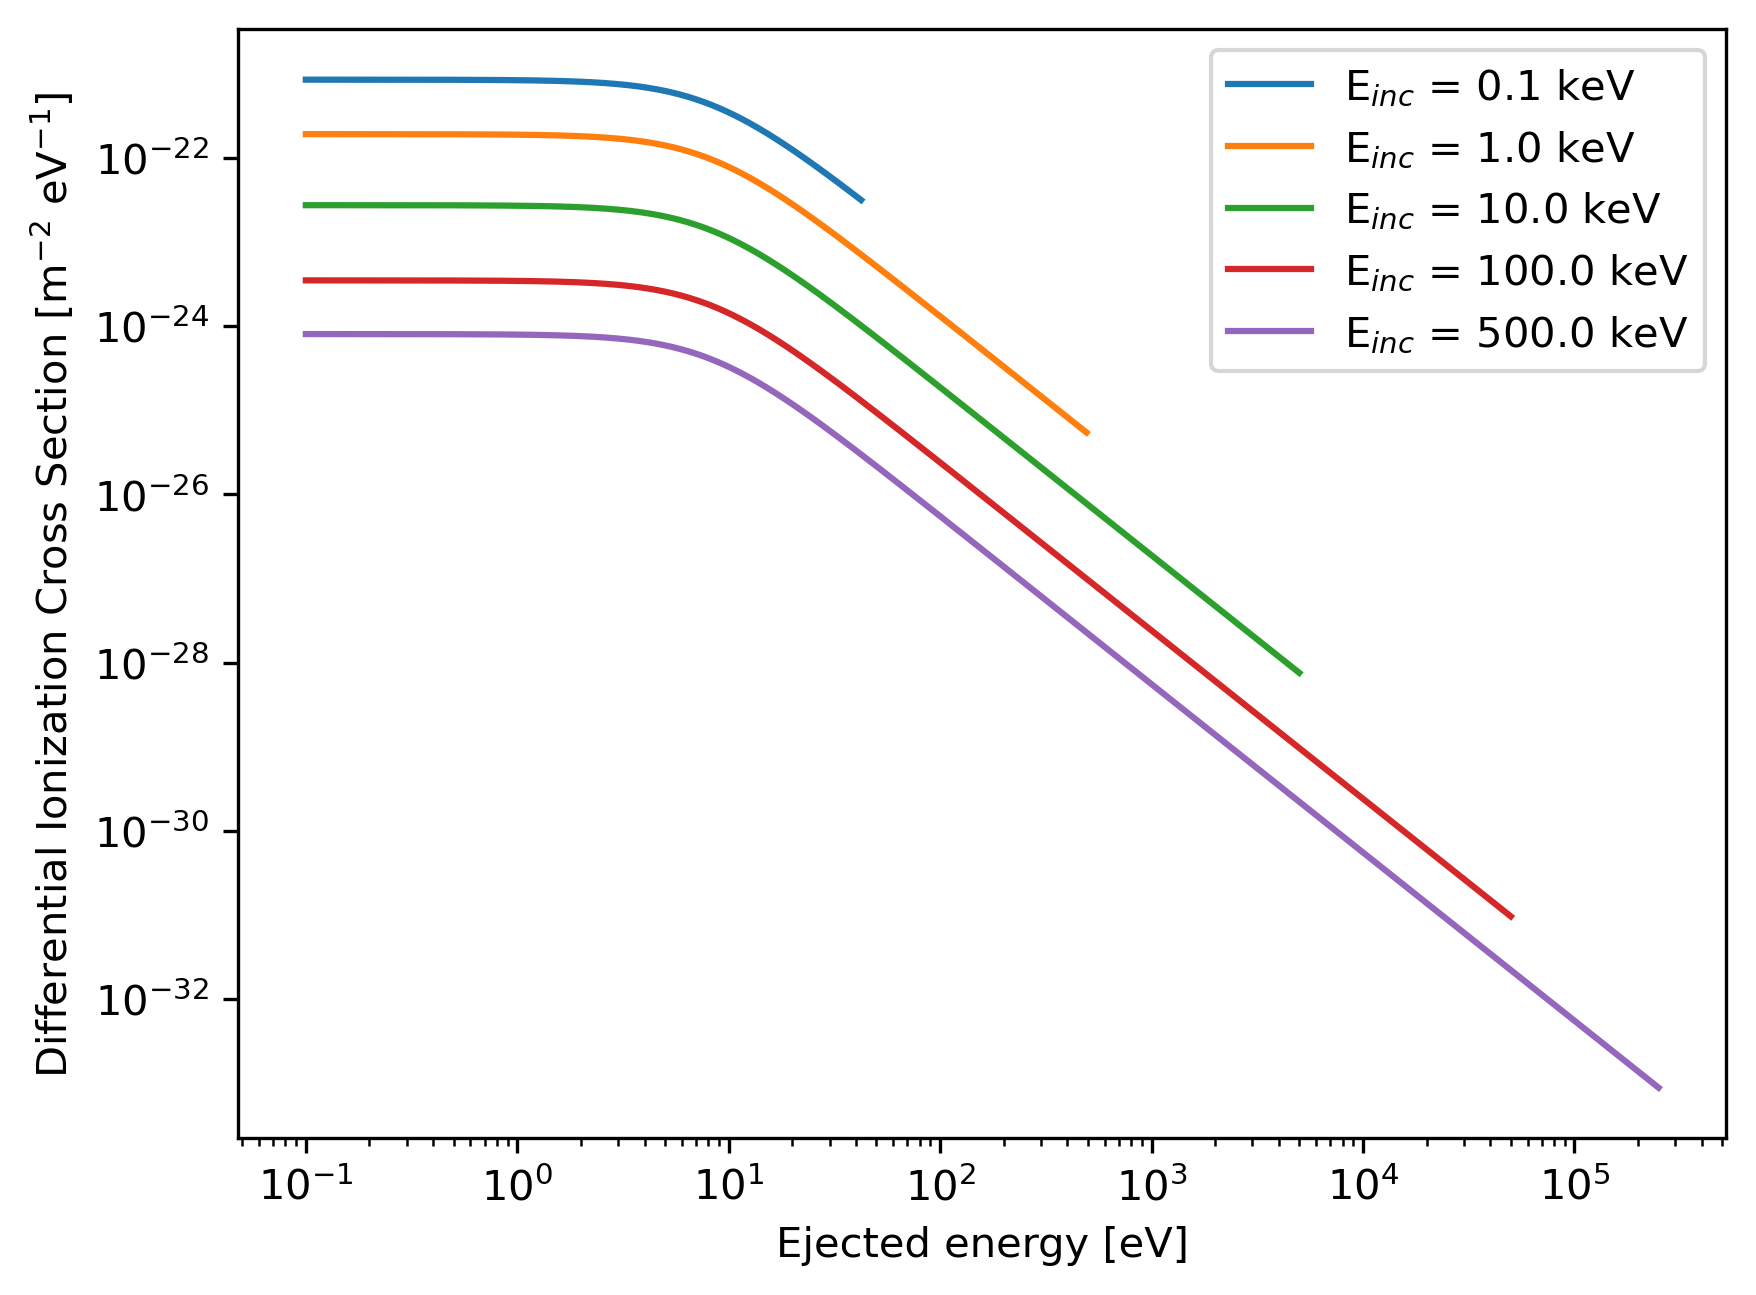

In [26]:
# Vahedi
B = 8.3 # ev
E_ion = 15.43 # eV to ionize H2 (or is it twice this?). This is "binding energy" on NIST, is that same thing?

def diff_xsec_Vahedi(E_inc, E_ej):
    sigma_ion = utils.ionization_xsec(np.array([E_inc * 1.60218e-19])) # I think they mean total ionization cross section? Obviously they would                                            # not have used the NIST xsec, but using it here, really just a normalization
    A = sigma_ion * B / np.arctan((E_inc - E_ion)/(2*B))
    return  A / (E_ej**2 + B**2)

plt.figure(dpi= 300) # default figsize [6.4, 4.8]
E_inc_arr = np.array([0.1,1,10,100,500]) * 1000  # ev
for E_inc in E_inc_arr: # ev
    E_ej = np.logspace(-1, np.log10((E_inc - E_ion) / 2) ,5000) # eV
    diff_xsec = diff_xsec_Vahedi(E_inc, E_ej)
    cross_section_total = np.trapz(diff_xsec, E_ej)
    cross_section_less_than_10 = np.trapz(diff_xsec[E_ej<10], E_ej[E_ej<10])
    print('fraction of cross section below 10eV for E='+str(E_inc/1000)+'keV: ' + str(cross_section_less_than_10/cross_section_total))
    plt.plot(E_ej, diff_xsec, label = r'E$_{inc}$ = ' + str(E_inc / 1000) + ' keV')
    plt.xlabel('Ejected energy [eV]')
    plt.ylabel(r'Differential Ionization Cross Section [m$^{-2}$ eV$^{-1}$]')
    plt.legend()
    plt.semilogy()
    plt.semilogx()

In [22]:
E_ej

array([1.00000000e-01, 1.00262842e-01, 1.00526374e-01, ...,
       4.97305166e+04, 4.98612290e+04, 4.99922850e+04])

fraction below 10eV for E=0.1keV: 0.6276412255282451
fraction below 10eV for E=1.0keV: 0.5486891
fraction below 10eV for E=10.0keV: 0.4886382488638249
fraction below 10eV for E=100.0keV: 0.4855224971044994


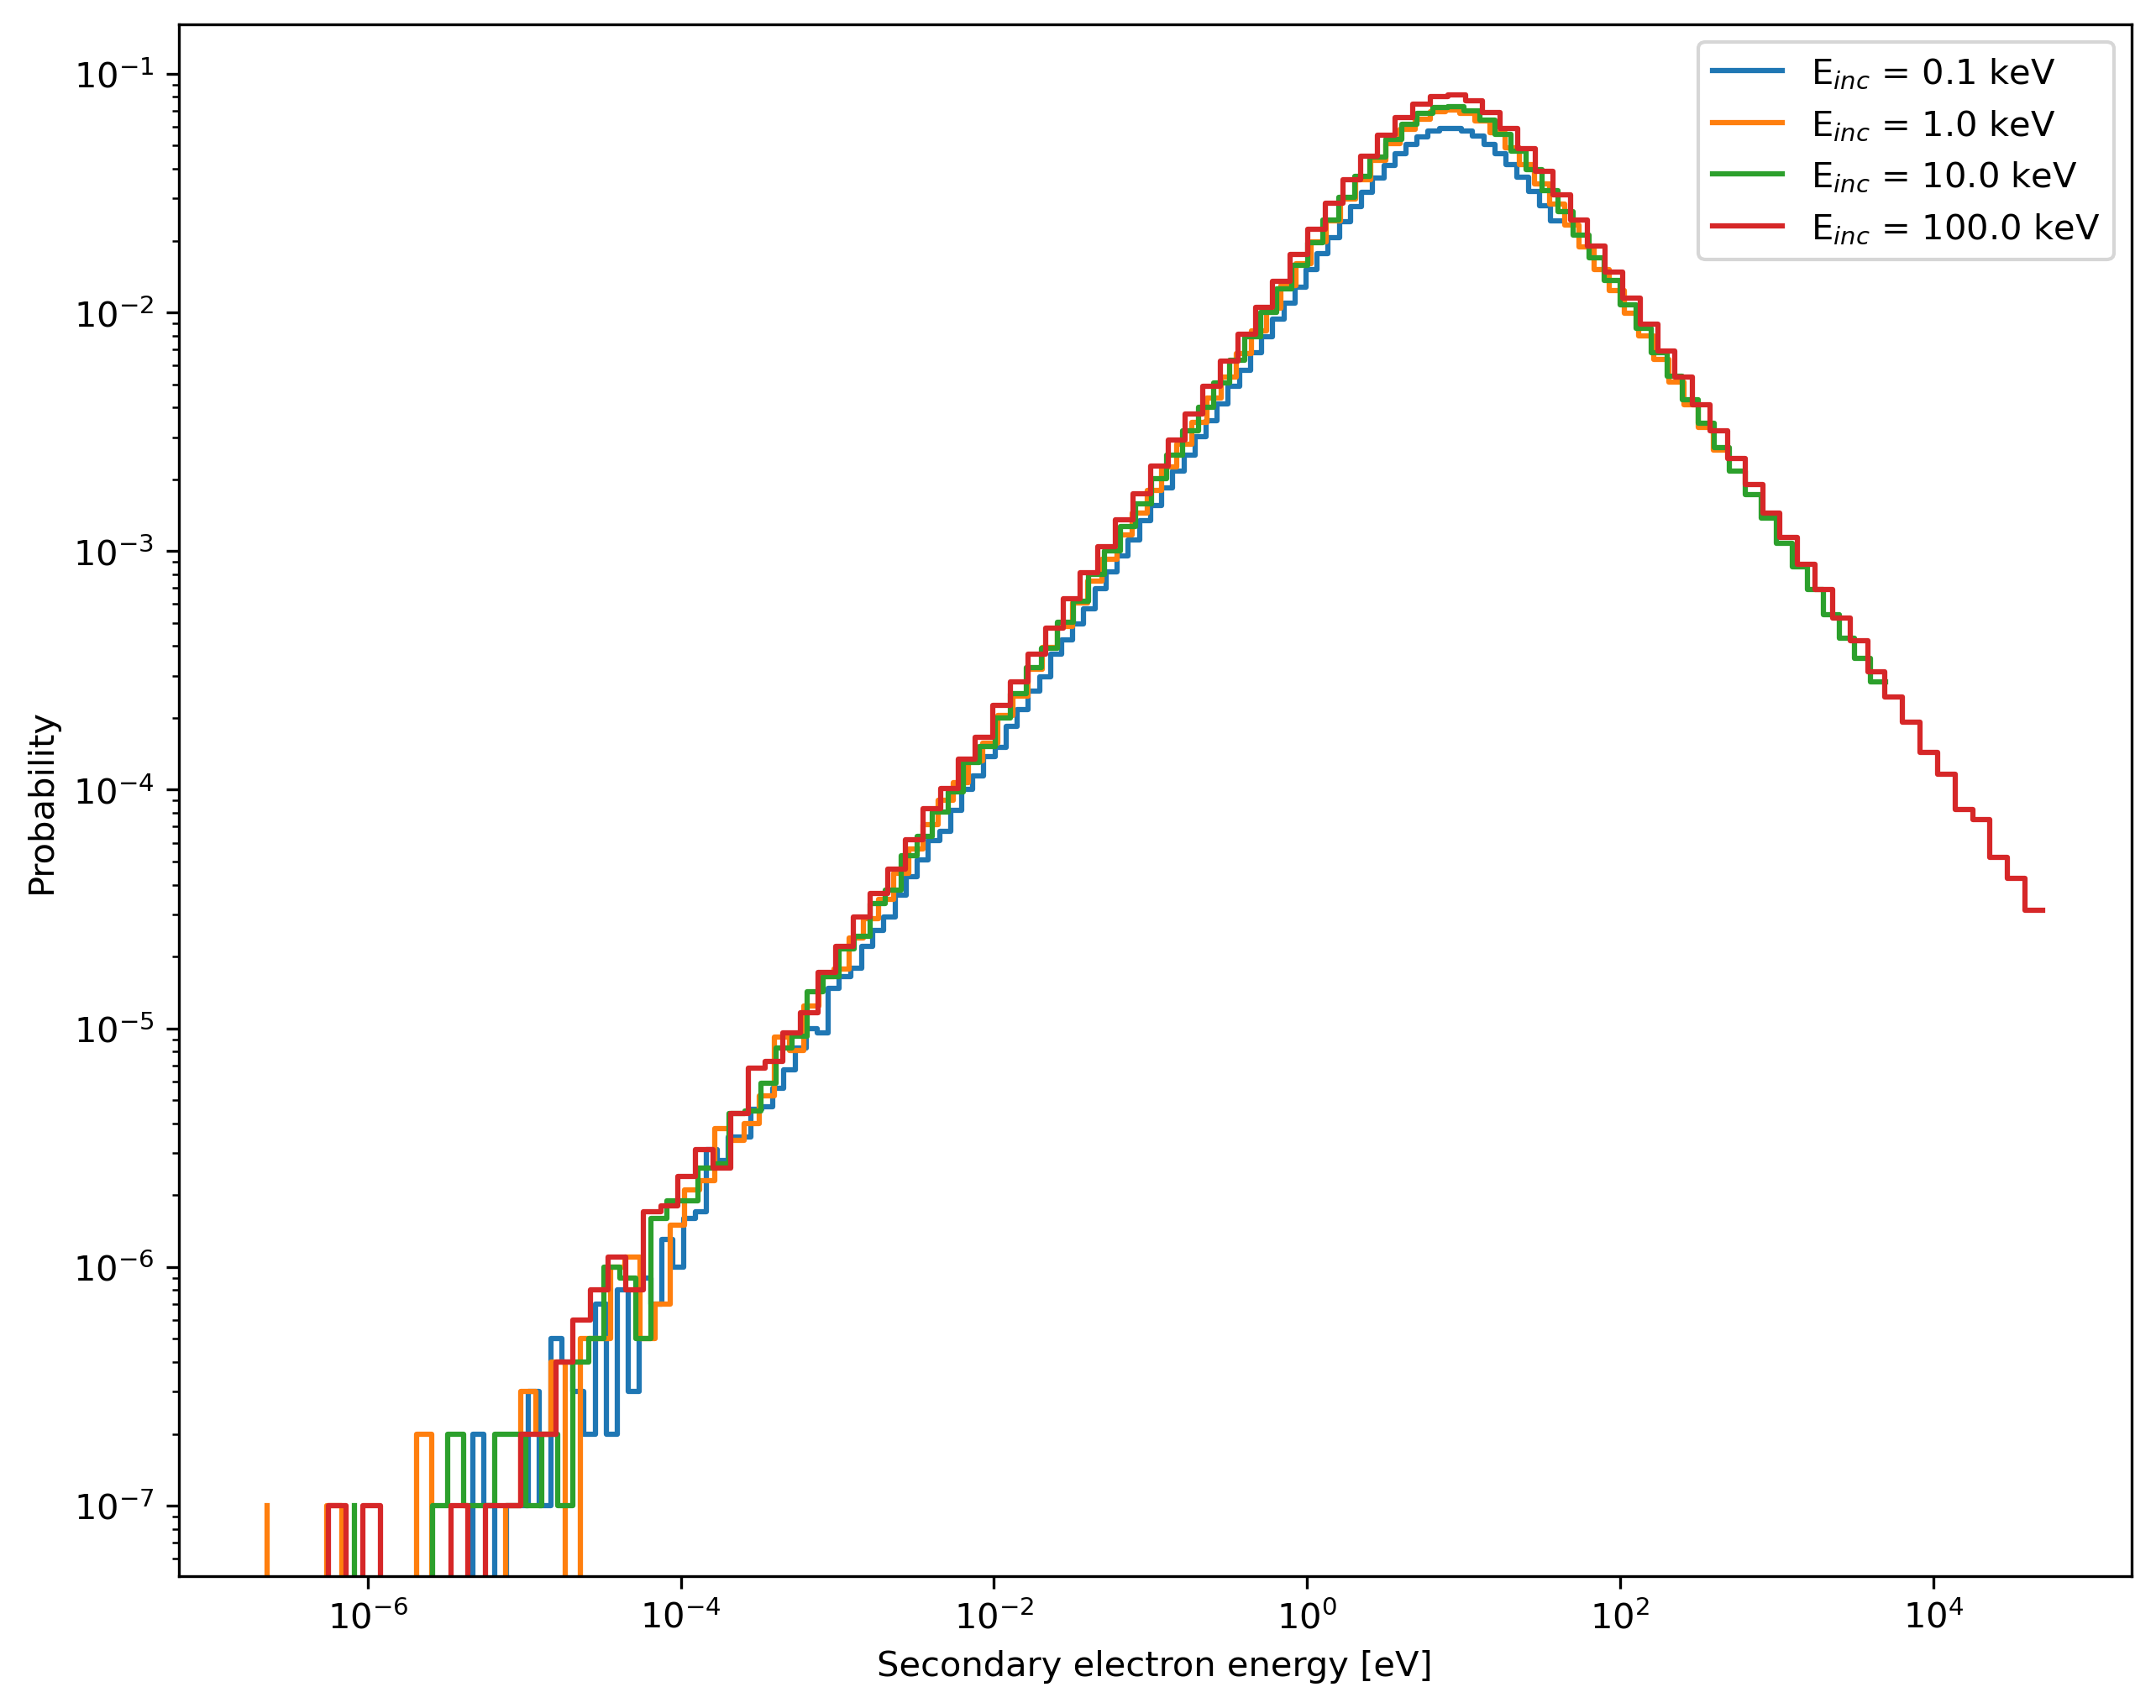

In [19]:
E_inc = np.array([0.1,1,10,100]) # kev
E_ion = 15.43 * 1.6022E-19 # ev to joules     (1 eV = 1.602176633E-19 J)

plt.figure(figsize = [10,8], dpi = 300)
for i in range(len(E_inc)):
    E = np.ones(10000000) * E_inc[i] * 1.6022E-16 # kev to joules
    E_ej = utils.vahedi_ejected_energy(E, E_ion) # Joules
    bins = np.logspace(np.log10(np.min(E_ej)), np.log10(np.max(E_ej)), 100)  # Joules
    #bins = np.linspace(np.min(E_ej), np.max(E_ej), 100)
    counts, bins = np.histogram(E_ej, bins = bins)#, density = True)  # bins in Joules
    integral = np.sum(counts)# np.abs(np.trapz(bins[1:]/1.6022E-19, counts))
    idx_10 = np.where(bins[1:]/1.6022E-19 > 10)[0][0]
    integral_less_than_10 = np.sum(counts[:idx_10]) #np.abs(np.trapz(bins[1:][:idx_10]/1.6022E-19, counts[:idx_10]))
    print('fraction below 10eV for E='+str(E_inc[i])+'keV: ' + str(integral_less_than_10/integral))
    plt.step(bins[1:]/1.6022E-19, counts/integral, label = r'E$_{inc}$ = ' + str( E_inc[i]) + ' keV')

plt.xlabel('Secondary electron energy [eV]')
plt.ylabel('Probability')
plt.semilogx()
plt.semilogy()
plt.legend()

### Column density above stopping height

In [ ]:
# TO DO: actually calculate the stopping heights by reading hte csv 

m = 1.342244475360605
b = -4.756312776461838


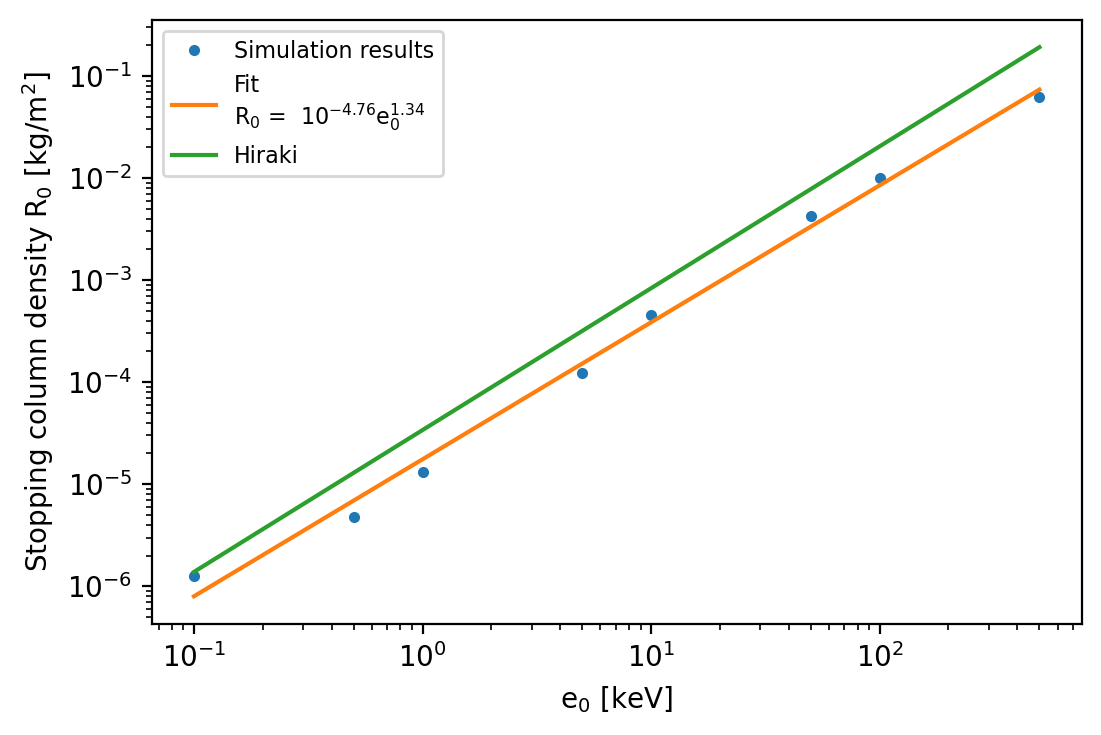

In [8]:
# for now just total eyeball
from scipy.integrate import quad 
from scipy.optimize import curve_fit
TOA = 2000e3
E0 = np.array([0.1,0.5,1.0,5.0,10,50,100,500])
mH2 = 3.347649043E-27 # H2 mass [kg]
#heights = [1180e3, 990e3, 820e3, 580e3, 400e3, 260e3, 250e3, 245e3] hardcore eyballing
heights = [1159173.4330822572, 983412.3385055563, 849066.2158713802, 543735.4361972251, 414767.369010999, 315307.514719894, 289096.08270490577, 239966.14111007916]
#heights = [1202230.3592209513, 1012332.8261788458, 897986.4410497699, 566577.5543459974, 442164.8410867904, 325632.74692826613, 297327.9335841821, 244059.17679866674]
R0 = []
Hiraki_curve = 3.39e-5 * E0**1.39

def linear_func(x, m, b): 
    return m*x+b

for height in heights: 
    N, err = quad(utils.n_H2_Jupiter, height, TOA)
    R0 += [N*mH2] 

R0 = np.array(R0)
popt, pcov = curve_fit(linear_func, np.log10(E0), np.log10(R0))
fit_curve =  10**linear_func(np.log10(E0), *popt)
print('m =', popt[0])
print('b =', popt[1])

plt.figure(dpi = 200)
plt.plot(E0, R0,'.', label = 'Simulation results')
#plt.plot(E0, fit_curve, label = 'Fit\n' + r'log(R$_0$ [kg/m$^2$]) = ' + str(round(popt[0],2)) + r'log(e$_0$ [keV]) + ' + str(round(popt[1],2)))
plt.plot(E0, E0**popt[0]*10**popt[1], label = 'Fit\n' +  r'R$_0$ = ' +  r' 10$^{' + str(round(popt[1],2)) + r'}$e$_0^{' + str(round(popt[0],2)) + '}$')

plt.plot(E0, Hiraki_curve, label = 'Hiraki')
plt.semilogx()
plt.semilogy()
plt.xlabel(r'e$_0$ [keV]')
plt.ylabel(r'Stopping column density R$_0$ [kg/m$^2$]')
plt.legend(fontsize = 8)

### Column density as a function of z

[]

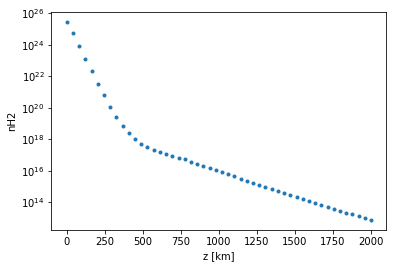

In [21]:
# should be the integral of this
plt.figure()
plt.plot(z3/1e3, Jupiter, '.')
plt.xlabel('z [km]')
plt.ylabel('nH2')
plt.semilogy()
# np.trapz(z3, Jupiter) = 8e29, which matches below, just as a check

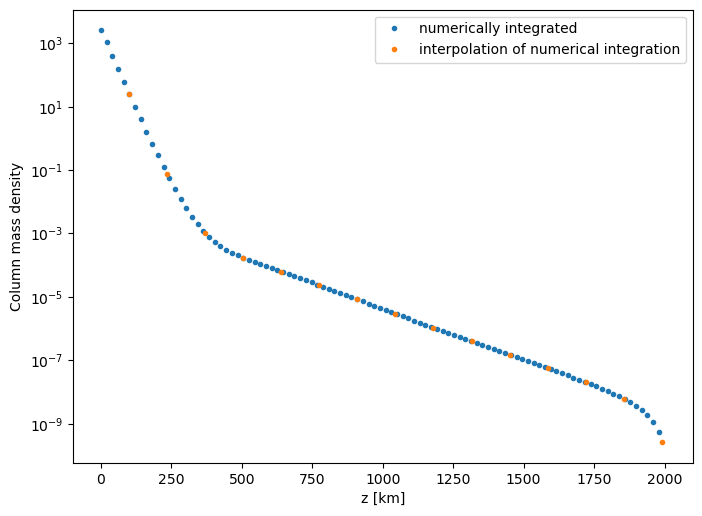

In [33]:
atm_type = 'Jupiter'
mH2 = 3.347649043E-27 # H2 mass [kg]
z_grid = np.linspace(0,2000,100)*1e3
R_grid = utils.construct_R_grid(z_grid, atm_type) # mass column density
z = np.linspace(100,1990, 15)*1e3
R = utils.get_column_density(z,  z_grid, R_grid)
plt.figure(figsize = [8,6], dpi = 100)
plt.plot(z_grid/1e3, R_grid, '.',  label = 'numerically integrated')
plt.plot(z/1e3, R, '.',  label = 'interpolation of numerical integration')
plt.xlabel('z [km]')
plt.ylabel('Column mass density')
plt.semilogy()
plt.legend()


### Hiraki parameterization curve

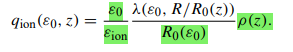

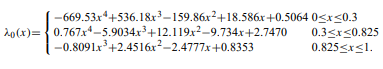

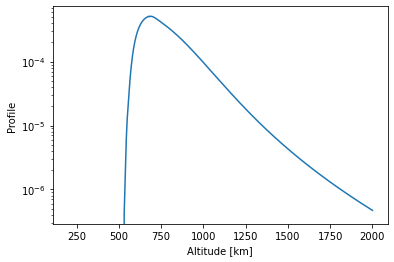

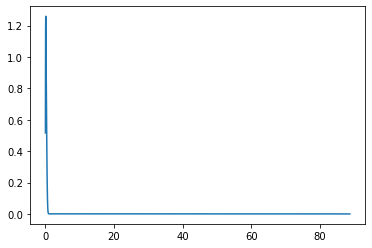

In [47]:
from scipy.integrate import quad 
mH2 = 3.347649043E-27 # kg

z_min = 200e3
z_max = 2000e3
z = np.linspace(z_min,z_max,1000)
dz = z[1] - z[0]
R = np.zeros(len(z))
for i in range(len(R)):
    zi = z[i]
    N, err = quad(utils.n_H2_Jupiter_Hiraki, zi, z_max) # #/m^2
    Ri = N*mH2 # column density kg/m^2
    R[i] = Ri
    
e0 = 10e3 # ev
e_ion = 30#15.43 # ev from Hiraki
rho = utils.n_H2_Jupiter_Hiraki(z)*mH2 
R0 = 3.39e-5 * (e0/1000)**1.39 # Hiraki
#R0 = quad(utils.n_H2_Jupiter_Hiraki, 550e3, z_max)[0]*mH2 # by eye (same order of magnitude as Hiraki)
k = 0.13 + 0.89*(1-1.1*np.tanh(np.log10(e0/1000) -1))
def get_lam0(x):
    lam0 = np.zeros(len(x))
    r1 = (x>=0) * (x<=0.3)
    r2 = (x>0.3) * (x<=0.825)
    r3 = (x>0.825) * (x<=1)
    lam0[r1] = -669.53*x[r1]**4 + 536.18*x[r1]**3 - 159.86*x[r1]**2 + 18.586*x[r1] + 0.506
    lam0[r2] = 0.767*x[r2]**4 - 5.9034*x[r2]**3 + 12.119*x[r2]**2 - 9.734*x[r2] + 2.7470
    lam0[r3] = -0.8091*x[r3]**3 + 2.4516*x[r3]**2 - 2.4777*x[r3] + 0.8353     
    return lam0

lam = get_lam0(R/R0) * k
q = (e0/e_ion)*(rho/R0)*lam # #/m
profile = q#*dz 
plt.plot(z/1000,profile)
plt.semilogy()
plt.xlabel('Altitude [km]')
plt.ylabel('Profile')

plt.figure()
plt.plot(R/R0, lam)

In [40]:
e0/e_ion

333.3333333333333

### mu(E) and sigma(E)

In [2]:
energies = np.array([500, 100, 50, 10, 5, 1, 0.5, 0.1])
atm_types = []

mus_list = []
sigmas_list = []
mus_sd_list = []
sigmas_sd_list = []
T_list = []
logg_list = []

# T=900K, g=5.0
atm_types += ['T=900K, g=5.0']
T_list += [900]
logg_list += [5.0]
T900_g5_mus = np.array([-24.9134, -23.9831, -23.5727, -22.587, -22.1045, -21.0298, -20.6447, -19.9272])
T900_g5_sigmas = np.array([0.1797, 0.206, 0.2098, 0.199, 0.1951, 0.1978, 0.2059, 0.2493])
T900_g5_mus_sd = np.array([0.0004, 0.0006, 0.0007, 0.0008, 0.001, 0.0023, 0.0032, 0.0084])
T900_g5_sigmas_sd = np.array([0.0002, 0.0003, 0.0003, 0.0004, 0.0005, 0.0012, 0.0016, 0.0043])
mus_list += [T900_g5_mus]
sigmas_list += [T900_g5_sigmas]
mus_sd_list += [T900_g5_mus_sd]
sigmas_sd_list += [T900_g5_sigmas_sd]

# T=1400K, g=5.0
atm_types += ['T=1400K, g=5.0']
T_list += [1400]
logg_list += [5.0]
T1400_g5_mus = np.array([-24.9043, -23.9805, -23.5732, -22.5925, -22.1013, -21.0473, -20.6373, -19.9226])
T1400_g5_sigmas = np.array([0.1858, 0.2066, 0.2119, 0.1971, 0.1976, 0.2167, 0.216, 0.2392])
T1400_g5_mus_sd = np.array([0.0005, 0.0006, 0.0007, 0.0008, 0.0011, 0.0024, 0.0033, 0.0082])
T1400_g5_sigmas_sd = np.array([0.0003, 0.0003, 0.0003, 0.0004, 0.0006, 0.0012, 0.0017, 0.0043])
mus_list += [T1400_g5_mus]
sigmas_list += [T1400_g5_sigmas]
mus_sd_list += [T1400_g5_mus_sd]
sigmas_sd_list += [T1400_g5_sigmas_sd]

# T=2000K, g=5.0
atm_types += ['T=2000K, g=5.0']
T_list += [2000]
logg_list += [5.0]
T2000_g5_mus = np.array([-24.9125, -23.9977, -23.5779, -22.5783, -22.0981, -21.033, -20.6595, -19.9519])
T2000_g5_sigmas = np.array([0.1804, 0.203, 0.2092, 0.1967, 0.1942, 0.1969, 0.2041, 0.2328])
T2000_g5_mus_sd = np.array([0.0004, 0.0006, 0.0006, 0.0008, 0.0011, 0.0023, 0.0032, 0.008])
T2000_g5_sigmas_sd = np.array([0.0002, 0.0003, 0.0003, 0.0004, 0.0005, 0.0012, 0.0017, 0.0041])
mus_list += [T2000_g5_mus]
sigmas_list += [T2000_g5_sigmas]
mus_sd_list += [T2000_g5_mus_sd]
sigmas_sd_list += [T2000_g5_sigmas_sd]

# T482K, g=4.7
atm_types += ['T=482K, g=4.7']
T_list += [482]
logg_list += [4.7]
T482_g4point7_mus = np.array([-24.909, -23.9841, -23.5816, -22.6047, -22.1139, -21.0397, -20.6461, -19.9444])
T482_g4point7_sigmas = np.array([0.1804, 0.1986, 0.2044, 0.1977, 0.197, 0.206, 0.2111, 0.24])
T482_g4point7_mus_sd = np.array([0.0005, 0.0006, 0.0006, 0.0008, 0.0011, 0.0023, 0.0032, 0.008])
T482_g4point7_sigmas_sd = np.array([0.0003, 0.0003, 0.0003, 0.0004, 0.0005, 0.0012, 0.0017, 0.0041])
mus_list += [T482_g4point7_mus]
sigmas_list += [T482_g4point7_sigmas]
mus_sd_list += [T482_g4point7_mus_sd]
sigmas_sd_list += [T482_g4point7_sigmas_sd]

# T=900K, g=4.0
atm_types += ['T=900K, g=4.0']
T_list += [900]
logg_list += [4.0]
T900_g4_mus = np.array([-24.8984, -23.9807, -23.5717, -22.5924, -22.0988, -21.0391, -20.6483, -19.932])
T900_g4_sigmas = np.array([0.1832, 0.2027, 0.2058, 0.1965, 0.1965, 0.1994, 0.2077, 0.2402])
T900_g4_mus_sd = np.array([0.0005, 0.0006, 0.0006, 0.0008, 0.0011, 0.0022, 0.0031, 0.008])
T900_g4_sigmas_sd = np.array([0.0003, 0.0003, 0.0003, 0.0004, 0.0006, 0.0012, 0.0016, 0.0042])
mus_list += [T900_g4_mus]
sigmas_list += [T900_g4_sigmas]
mus_sd_list += [T900_g4_mus_sd]
sigmas_sd_list += [T900_g4_sigmas_sd]

# T=1400K, g=4.0
atm_types += ['T=1400K, g=4.0']
T_list += [1400]
logg_list += [4.0]
T1400_g4_mus = np.array([-24.9128, -23.9798, -23.5762, -22.5895, -22.0933, -21.0432, -20.6582, -19.9491])
T1400_g4_sigmas = np.array([0.183, 0.2081, 0.2081, 0.2042, 0.1961, 0.1976, 0.2118, 0.2366])
T1400_g4_mus_sd = np.array([0.0005, 0.0006, 0.0006, 0.0009, 0.0011, 0.0022, 0.0032, 0.0079])
T1400_g4_sigmas_sd = np.array([0.0002, 0.0003, 0.0003, 0.0004, 0.0006, 0.0012, 0.0017, 0.0041])
mus_list += [T1400_g4_mus]
sigmas_list += [T1400_g4_sigmas]
mus_sd_list += [T1400_g4_mus_sd]
sigmas_sd_list += [T1400_g4_sigmas_sd]

# Jupiter moyal distribution
atm_types += ['Jupiter'] # NB: is isothermal extension version of jupiter use for this fitting
T_list += [125]
logg_list += [3.4]
Jupiter_mus = np.array([-24.8702, -23.9817, -23.5518, -22.5844, -22.1097, -21.0313, -20.6314, -19.9339])
Jupiter_sigmas = np.array([0.1908, 0.1992, 0.2103, 0.1963, 0.2027, 0.199, 0.211, 0.235])
Jupiter_mus_sd = np.array([0.0005, 0.0006, 0.0007, 0.0008, 0.001, 0.0022, 0.0033, 0.0078])
Jupiter_sigmas_sd = np.array([0.0003, 0.0003, 0.0004, 0.0004, 0.0005, 0.0011, 0.0016, 0.004])
mus_list += [Jupiter_mus]
sigmas_list += [Jupiter_sigmas]
mus_sd_list += [Jupiter_mus_sd]
sigmas_sd_list += [Jupiter_sigmas_sd]


# mus_list = np.array(mus_list)
# sigmas_list = np.array(sigmas_list)
# mus_sd_list = np.array(mus_sd_list)
# sigmas_sd_list = np.array(sigmas_sd_list)
# fit_mus_list = np.array(fit_mus_list)
# fit_sigmas_list = np.array(fit_sigmas_list)
# mu_means_list = np.array(mu_means_list)
# sigma_means_list = np.array(sigma_means_list)
logg_list = np.array(logg_list)
T_list = np.array(T_list)

# construct dataframe 
df = pd.DataFrame()
all_T = []
all_logg = []
all_E = []
all_mu = []
all_sigma = []
all_atm_types = []
for i in range(len(T_list)):
    all_T.extend([T_list[i]]*len(energies))
    all_logg.extend([logg_list[i]]*len(energies))
    all_atm_types.extend([atm_types[i]]*len(energies))
    all_E.extend(energies)
    all_mu.extend(mus_list[i])
    all_sigma.extend(sigmas_list[i])
    
df['E [keV]'] = all_E
df['T [K]'] = all_T
df['logg'] = all_logg
df['mu'] = all_mu
df['sigma'] = all_sigma
df['atm_type'] = all_atm_types

df['ID'] = df['atm_type']
df.loc[df['atm_type'] == 'Jupiter, isothermal', 'ID'] = 1
df.loc[df['atm_type'] == 'T=900K, g=5.0', 'ID'] = 2
df.loc[df['atm_type'] == 'T=900K, g=4.0', 'ID'] = 3
df.loc[df['atm_type'] == 'T=1400K, g=5.0', 'ID'] = 4
df.loc[df['atm_type'] == 'T=1400K, g=4.0', 'ID'] = 5
df.loc[df['atm_type'] == 'T=2000K, g=5.0', 'ID'] = 6
df.loc[df['atm_type'] == 'T=482K, g=4.7', 'ID'] = 7

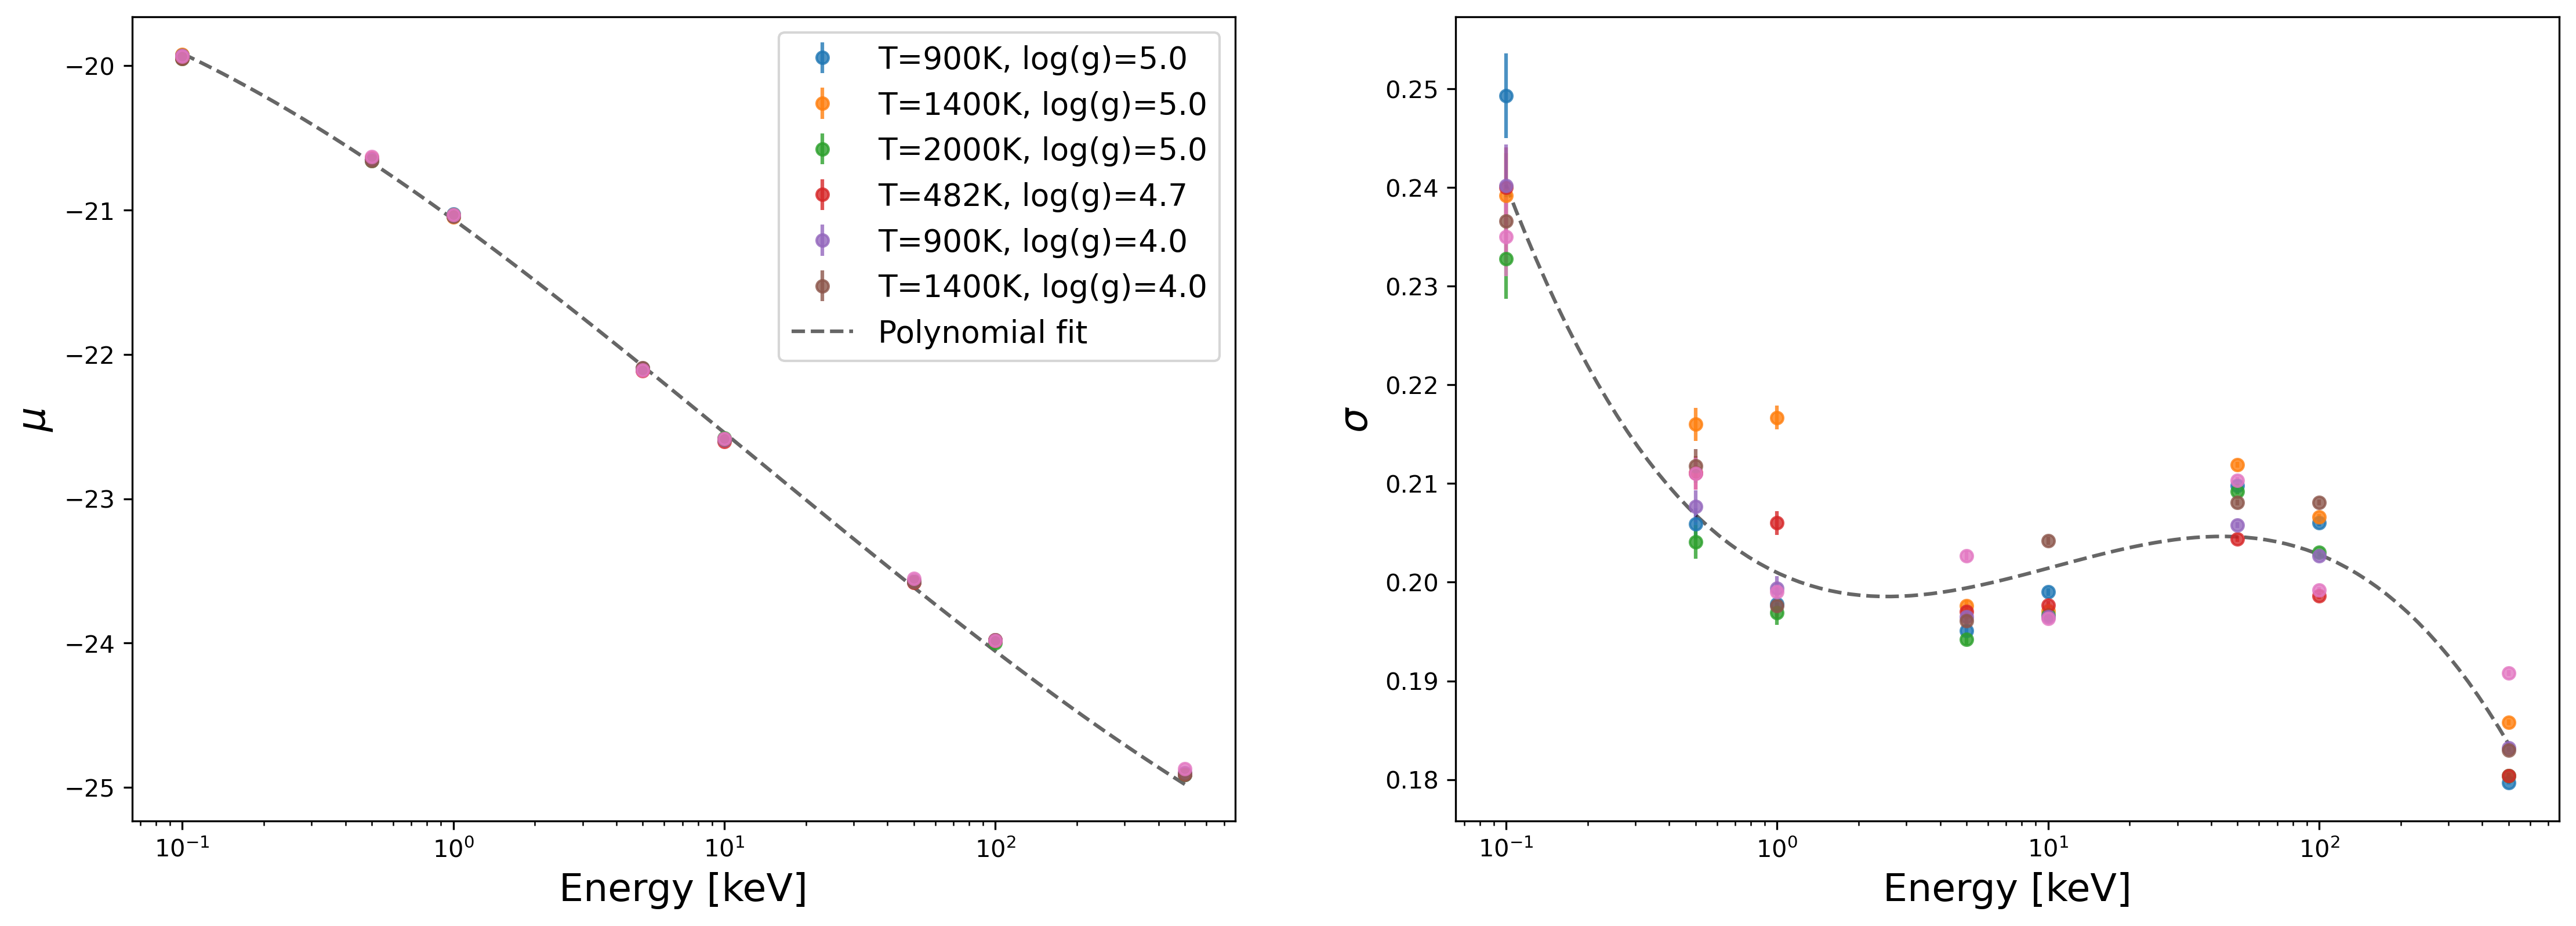

In [5]:
n=8
fs = 16
cmap = mcp.gen_color(cmap="plasma",n=n)
lws = [7,6,5,4,3,2,1]
E_arr = np.logspace(-1,2.7,100)

def mu(E):
    # E in keV
    return -0.59175*np.log(E) + -0.031*np.log(E)**2 + 0.004*np.log(E)**3 + -21.06433

def sigma(E):
    # E in keV
    return -0.00563*np.log(E) + 0.00375*np.log(E)**2 + -0.00053*np.log(E)**3 + 0.20097

plt.figure(figsize = [18,6], dpi = 300)
plt.subplot(121)
ax = plt.gca()
#ax.set_prop_cycle('color',[cmap[int(i)] for i in np.linspace(0, n-1, n)])
#shapes = ['.', '^', '*', 's', 'D', 'x', 'd']
#ms = 5
#markersizes = [ms, 0.8*ms, ms, 0.8*ms, 0.7*ms, ms, ms]
shapes = ['.', '.', '.', '.', '.', '.', '.']
ms = 10
markersizes = [ms,ms,ms,ms,ms,ms,ms]
for i in range(len(mus_list)):
    #p=plt.errorbar(energies, -mus_list[i], yerr=mus_sd_list[i], label = atm_types[i], fmt = '.')#marker = '.')#, lw = lws[i])#, fmt = 'none', ls = '-') 
    p=plt.errorbar(energies, mus_list[i], yerr=mus_sd_list[i], label = atm_types[i].replace('g', 'log(g)'), fmt = shapes[i], ms = markersizes[i], alpha = 0.8)
plt.plot(E_arr, mu(E_arr), label = 'Polynomial fit', color = 'k', ls = 'dashed', alpha = 0.6)
plt.xlabel('Energy [keV]',fontsize=fs)
plt.ylabel(r'$\mu$',fontsize=fs)
plt.semilogx()
#plt.semilogy()
#plt.legend(fontsize=fs*0.8)
# reordering the labels 
handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,2,3,4,5,6,0] 
plt.legend([handles[i] for i in order], [labels[i] for i in order],fontsize=fs*0.8)

plt.subplot(122)
ax = plt.gca()
#ax.set_prop_cycle('color',[cmap[int(i)] for i in np.linspace(0, n-1, n)])
for i in range(len(mus_list)):
    p=plt.errorbar(energies, sigmas_list[i], yerr=sigmas_sd_list[i], label = atm_types[i].replace('g', 'log(g)'), fmt = shapes[i], ms = markersizes[i], alpha = 0.8)#, lw = lws[i])#, fmt = 'none', ls = '-') 
plt.plot(E_arr, sigma(E_arr), label = 'Polynomial fit', color = 'k', ls = 'dashed', alpha = 0.6)
plt.xlabel('Energy [keV]',fontsize=fs)
plt.ylabel(r'$\sigma$',fontsize=fs)
plt.semilogx()
#plt.semilogy()
# reordering the labels 
handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,2,3,4,5,6,0] 
#plt.legend([handles[i] for i in order], [labels[i] for i in order],fontsize=fs*0.8)

plt.savefig('./paper_plots/mu_and_sigma_v4.pdf', format = 'pdf', bbox_inches="tight")

### Mu and sigma transformed to be for Moyal(-lnN) instead of Moyal(-log10N)

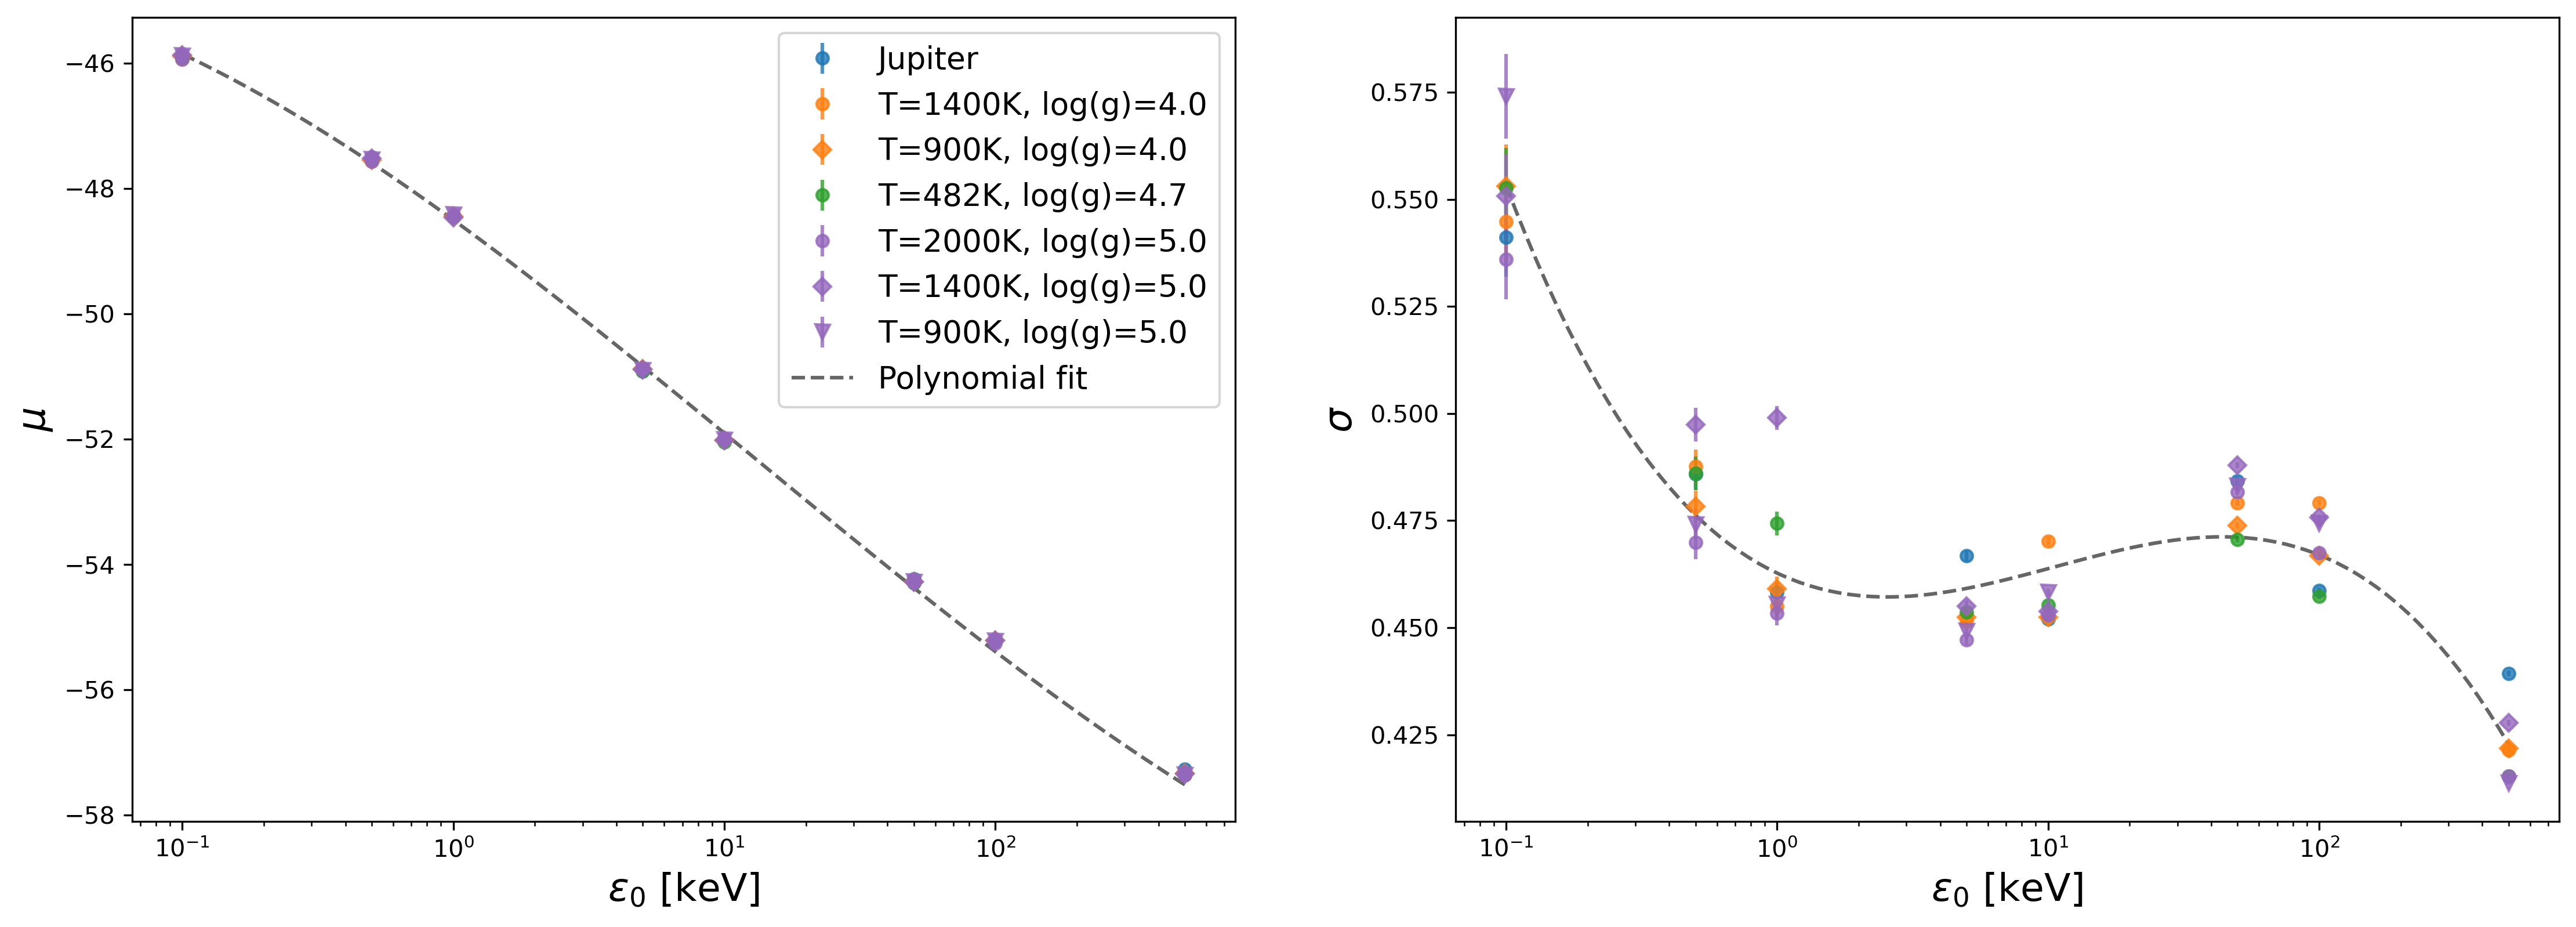

In [5]:
n=8
fs = 16
cmap = mcp.gen_color(cmap="plasma",n=n)
lws = [7,6,5,4,3,2,1]
E_arr = np.logspace(-1,2.7,100)

def mu_prime(E):
    # E in keV
    return (-0.59175*np.log(E) + -0.031*np.log(E)**2 + 0.004*np.log(E)**3 + -21.06433) * np.log(10)

def sigma_prime(E):
    # E in keV
    return (-0.00563*np.log(E) + 0.00375*np.log(E)**2 + -0.00053*np.log(E)**3 + 0.20097) * np.log(10)

plt.figure(figsize = [18,6], dpi = 300)
plt.subplot(121)
ax = plt.gca()
#ax.set_prop_cycle('color',[cmap[int(i)] for i in np.linspace(0, n-1, n)])
#shapes = ['.', '^', '*', 's', 'D', 'x', 'd']
#ms = 5
#markersizes = [ms, 0.8*ms, ms, 0.8*ms, 0.7*ms, ms, ms]
 #labels = ['Jupiter', 'T=1400K, log(g)=4.0', 'T=900K, log(g)=4.0', 'T=482K, log(g)=4.7', 'T=2000K, log(g)=5.0', 'T=1400K, log(g)=5.0', 'T=900K, log(g)=5.0']
colors = ['C4', 'C4', 'C4', 'C2', 'C1', 'C1', 'C0']
markers = ['v', 'D','.', '.','D','.', '.',]#, 'h']
ms = 10
markersize = [0.6*ms, 0.5*ms, ms, ms,0.5*ms,ms, ms]
#shapes = ['.', '.', '.', '.', '.', '.', '.']
#ms = 10
#markersizes = [ms,ms,ms,ms,ms,ms,ms]
for i in range(len(mus_list))[::-1]:
    #p=plt.errorbar(energies, -mus_list[i], yerr=mus_sd_list[i], label = atm_types[i], fmt = '.')#marker = '.')#, lw = lws[i])#, fmt = 'none', ls = '-') 
    p=plt.errorbar(energies, mus_list[i] * np.log(10), yerr=mus_sd_list[i] * np.log(10), label = atm_types[i].replace('g', 'log(g)'), color = colors[i], fmt = markers[i], ms = markersize[i], alpha = 0.8)
plt.plot(E_arr, mu_prime(E_arr), label = 'Polynomial fit', color = 'k', ls = 'dashed', alpha = 0.6)
plt.xlabel(r'$\varepsilon_0$ [keV]',fontsize=fs)
plt.ylabel(r'$\mu$',fontsize=fs)
plt.semilogx()
#plt.semilogy()
#plt.legend(fontsize=fs*0.8)
# reordering the labels 
handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,2,3,4,5,6,7,0] 
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=fs*0.8)

plt.subplot(122)
ax = plt.gca()
#ax.set_prop_cycle('color',[cmap[int(i)] for i in np.linspace(0, n-1, n)])
for i in range(len(mus_list))[::-1]:
    label = atm_types[i].replace('g', 'log(g)')
    p=plt.errorbar(energies, sigmas_list[i] * np.log(10), yerr=sigmas_sd_list[i] * np.log(10), label = label, color = colors[i], fmt = markers[i], ms = markersize[i], alpha = 0.8)#, lw = lws[i])#, fmt = 'none', ls = '-') 
plt.plot(E_arr, sigma_prime(E_arr), label = 'Polynomial fit', color = 'k', ls = 'dashed', alpha = 0.6)
plt.xlabel(r'$\varepsilon_0$ [keV]',fontsize=fs)
plt.ylabel(r'$\sigma$',fontsize=fs)
plt.semilogx()
#plt.semilogy()
# reordering the labels 
handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,2,3,4,5,6,7,0] 
#plt.legend([handles[i] for i in order], [labels[i] for i in order],fontsize=fs*0.8)

plt.savefig('./paper_plots/mu_and_sigma_transformed_v4.pdf', format = 'pdf', bbox_inches="tight")

### Plot of fitting beta_ion

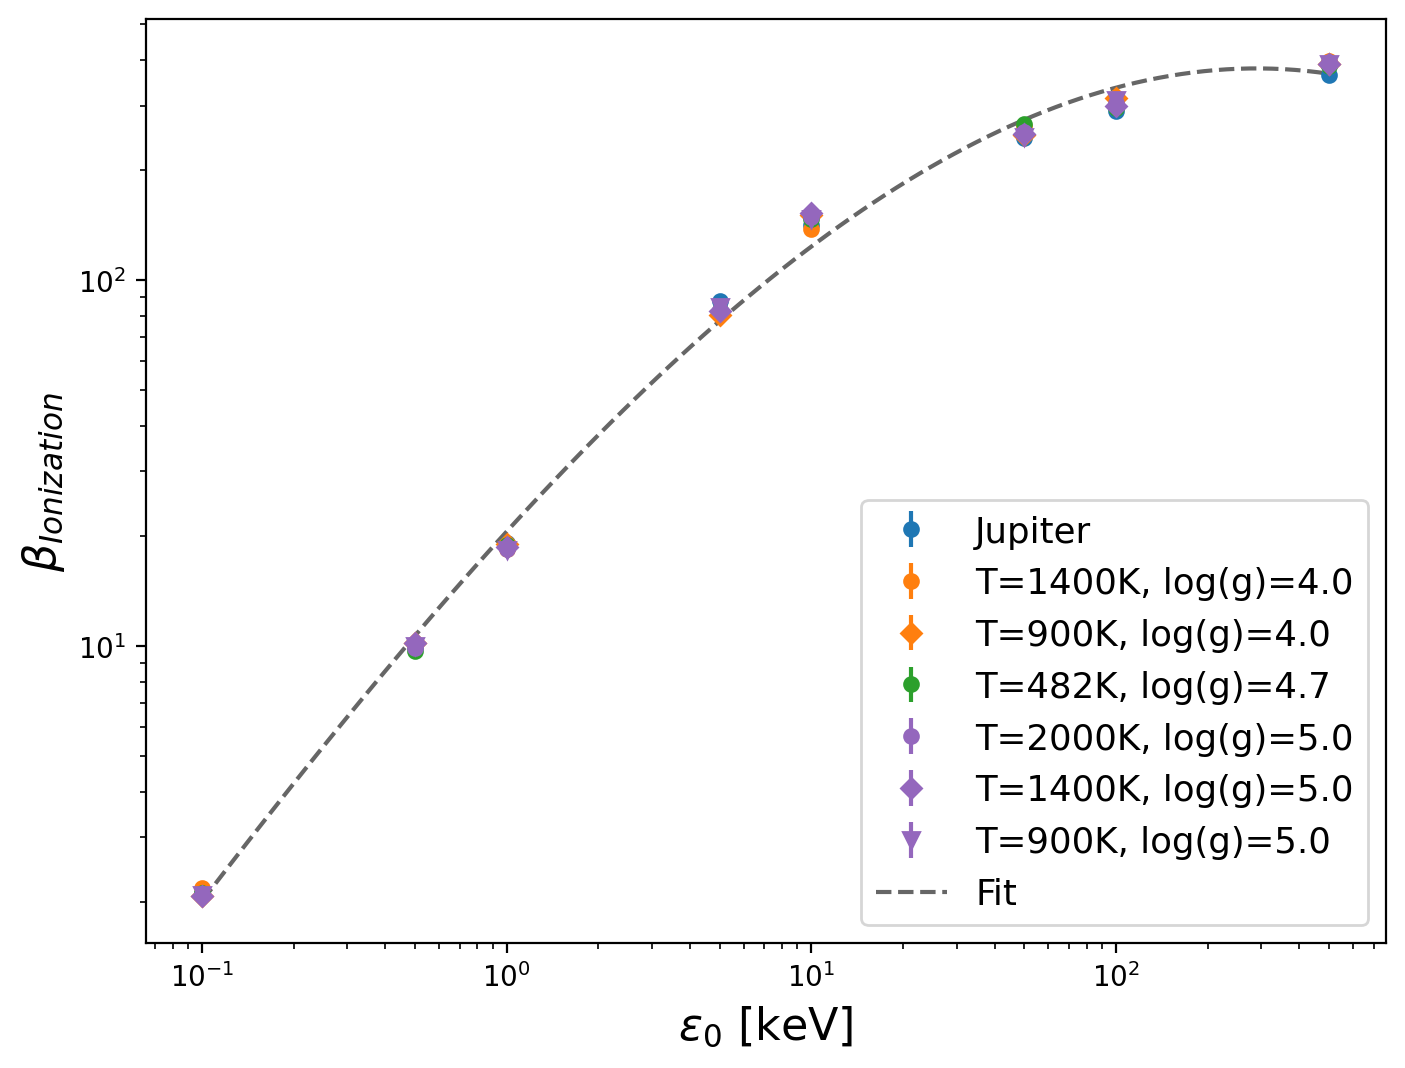

In [51]:
Ne = 1000
num_ionizations_T900_g5 = [389265, 309860, 245432, 147027, 84511, 18253, 10007, 2086]
num_ionizations_T1400_g5 = [389713, 299362, 250616, 152492, 82183, 18652, 10176, 2080]
num_ionizations_T1400_g4 = [396369, 309908, 264365, 138063, 81309, 18428, 10050, 2175]
num_ionizations_T482_g4point7 = [384339, 295228, 266669, 147089, 83008, 18917, 9696, 2120]
num_ionizations_T2000_g5 = [395435, 305033, 254593, 148844, 82820, 18448, 9902, 2087]
num_ionizations_Jupiter = [363251, 290076, 243919, 141823, 87626, 19174, 9939, 2112] # isothermal
num_ionizations_T900_g4 = [388701, 314639, 249580, 151044, 80284, 18987, 10201, 2078]
Nions = [num_ionizations_T900_g5, num_ionizations_T1400_g5, num_ionizations_T2000_g5, num_ionizations_T482_g4point7, num_ionizations_T900_g4, num_ionizations_T1400_g4, num_ionizations_Jupiter]
Nions_flat = [x/Ne for xs in Nions for x in xs]
energies = np.array([500, 100, 50, 10, 5, 1, 0.5, 0.1])
atm_types = ['T=900K, log(g)=5.0', 'T=1400K, log(g)=5.0','T=2000K, log(g)=5.0','T=482K, log(g)=4.7','T=900K, log(g)=4.0','T=1400K, log(g)=4.0','Jupiter'] # isothermal jupiter
colors = ['C4', 'C4', 'C4', 'C2', 'C1', 'C1', 'C0']
markers = ['v', 'D','.', '.','D','.', '.',]#, 'h']
markersize = [0.6*ms, 0.5*ms, ms, ms,0.5*ms,ms, ms]

def Nion_over_Ne_fit(E_keV):
    # E in keV
    a = 0.913336
    b = -0.05016688
    c = -0.00357498
    d = 3.02340139
    logE = np.log(E_keV)
    return np.exp(a*logE + + b*logE**2 + c*logE**3 + d) 

plt.figure(figsize = [8,6], dpi = 200)
fs = 16
for i in range(len(Nions))[::-1]:
    #plt.plot(energies, np.array(Nions[i])/Ne, '.', color = colors[i], marker = markers[i], markersize = markersize[i], label = atm_types[i])#, color = cmap[i])
    #p=plt.errorbar(                                    yerr=sigmas_sd_list[i] * np.log, label = atm_types[i].replace('g', 'log(g)'), color = colors[i], fmt = markers[i], ms = markersize[i], alpha = 0.8)#, lw = lws[i])#, fmt = 'none', ls = '-') 
    plt.errorbar(energies, np.array(Nions[i])/Ne, yerr = np.array(np.sqrt(Nions[i]))/Ne, color = colors[i], fmt = markers[i], markersize = markersize[i], label = atm_types[i])#, color = cmap[i])
    plt.xlabel(r'$\varepsilon_0$ [keV]', fontsize = fs)
    plt.ylabel(r'$\beta_{Ionization}$', fontsize = fs)

E_arr = np.logspace(-1,2.7,100)
plt.plot(E_arr, Nion_over_Ne_fit(E_arr), color = 'k', ls = 'dashed', label = 'Fit', alpha = 0.6)
plt.semilogx()
plt.semilogy()
plt.legend(fontsize = 0.8*fs)

handles, labels = plt.gca().get_legend_handles_labels() 
order = [1,2,3,4,5,6,7,0] 
plt.legend([handles[i] for i in order], [labels[i] for i in order],fontsize=fs*0.8)
plt.savefig('./paper_plots/beta_v1.pdf', format = 'pdf', bbox_inches="tight")

### Comparing Jupiter Hiraki parameterization to sim results w/ Hiraki density profile

In [12]:
results_dir = './Run_Outputs/Jupiter_Hiraki_profile'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_Jupiter_v18_03.06.2025.22.49.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_Jupiter_v18_03.06.2025.22.10.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_Jupiter_v18_03.06.2025.22.07.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_Jupiter_v18_03.06.2025.22.17.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_Jupiter_v18_03.06.2025.22.04.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_Jupiter_v18_03.06.2025.22.05.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_Jupiter_v18_03.06.2025.22.28.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_Jupiter_v18_03.06.2025.23.14.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

(1e-07, 0.01)

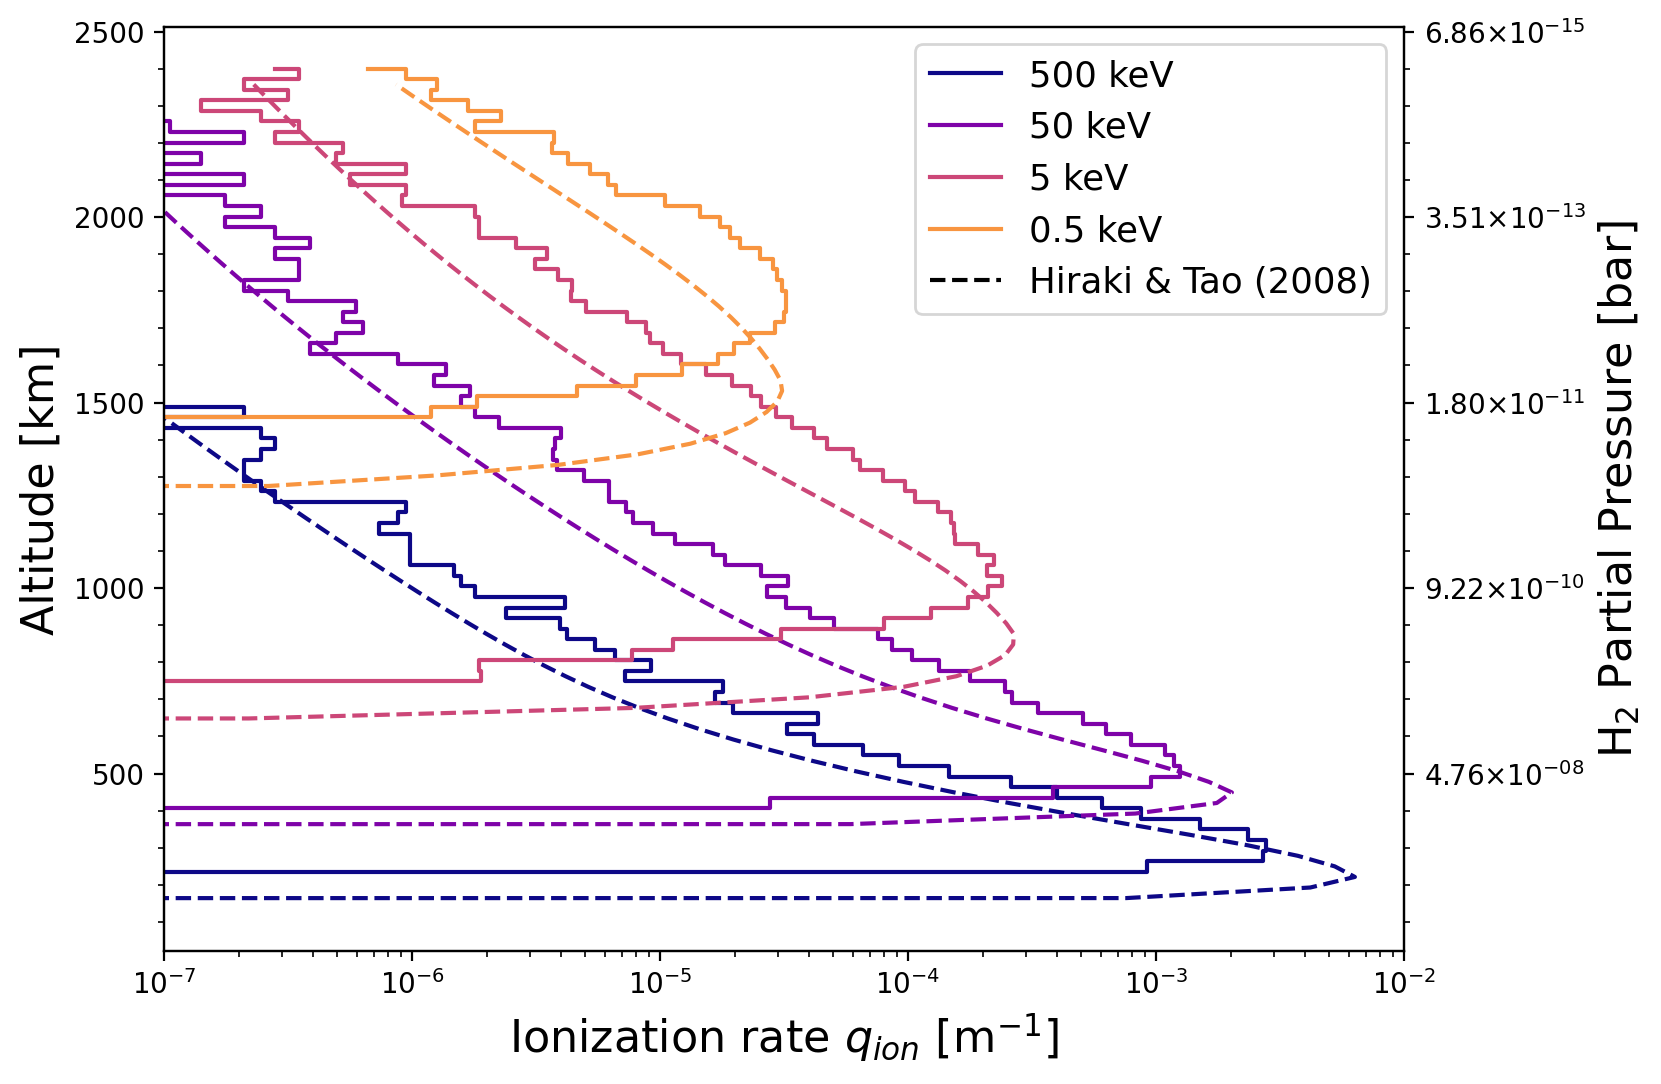

In [17]:
plt.figure(figsize = [8,6], dpi = 200)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
z_min = 150e3
z_max = 2400e3
nbins = 80
Ne = 1000

get_nH2 = utils.n_H2_Jupiter_Hiraki
get_P_H2 = utils.get_pressure_Jupiter

for i in range(len(energies)):
    if energies[i] in [0.5, 5,50,500]:
        bins_arr = np.linspace(z_min, z_max, nbins)
        binwidth = bins_arr[1] - bins_arr[0]
        counts, bins = np.histogram(z_ions[i], bins = bins_arr) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        binwidth = (bins[1]-bins[0])
        bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
        q = counts/binwidth
        plt.step(q, bins[1:]/1000, color = colors[i], label = str(energies[i]) + ' keV')
       # plt.step([], [], color = colors[i], label = str(energies[i]) + ' keV')
        e0 = float(energies[i])*1000
        Hiraki_q = utils.get_Hiraki_parameterization_curve(bincenters, z_min, z_max, e0, get_nH2)#, stopping_height)
        plt.plot(Hiraki_q, bincenters/1000, color = colors[i], ls = 'dashed')
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel('Altitude [km]', fontsize = fs)
ytick_locs = ax1.get_yticks() # returns locs in data coords
P = get_P_H2(ytick_locs*1000) / 1e5 # then convert to bars
ax2 = ax1.twinx()
ax2.set_yticks(ytick_locs)
formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
formatted_P = formatting_function(P)
label_P = [P.replace('E',r'$\times 10^{')+'}$' for P in formatted_P]
ax2.set_yticklabels(label_P)
ax2.set_ybound(ax1.get_ybound())
ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax2.minorticks_on()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.plot([],[],ls = 'dashed', color = 'k', label = 'Hiraki & Tao (2008)')
ax1.minorticks_on()
ax1.legend(fontsize = 0.8*fs)
plt.xlim([1e-7, 1e-2])

#plt.savefig('./paper_plots/Hiraki_profile_sim_vs_Hiraki_parameterization_v2.pdf', format = 'pdf', bbox_inches="tight")

### Plot of Jupiter across energies, Galileo

In [19]:
atm_type = 'Jupiter'
results_dir = '/projects/anzu2965/SPI/beam_sim/Run_Outputs/Jupiter_Galileo' 
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.37.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

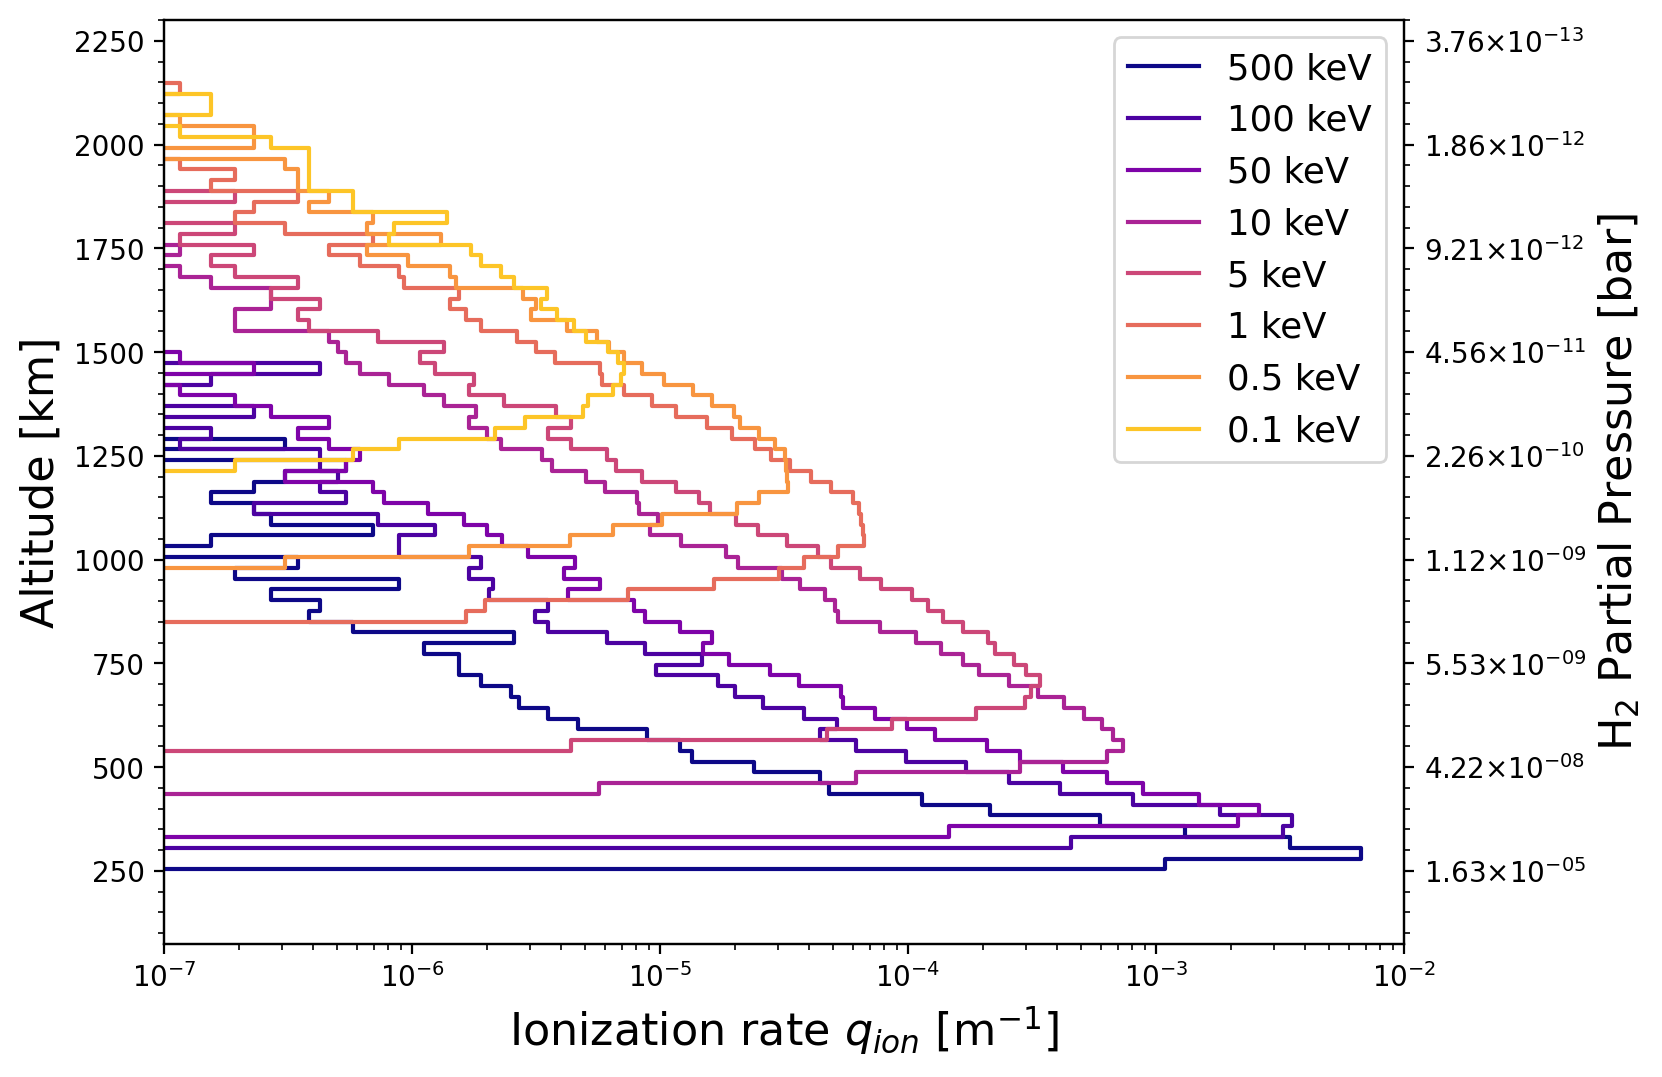

In [8]:
plt.figure(figsize = [8,6], dpi = 200)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
z_min = 150e3
z_max = 2200e3
nbins = 80
Ne = 1000
sonora_filepath = './Sonora_data'
atm_type = 'Jupiter'

get_n_H2, get_P_H2 = utils.construct_profile_Jupiter(atm_type, z_max, sonora_filepath)

for i in range(len(energies)):
    #if energies[i] in [0.5, 5,50,500]:
    bins_arr = np.linspace(z_min, z_max, nbins)
    binwidth = bins_arr[1] - bins_arr[0]
    counts, bins = np.histogram(z_ions[i], bins = bins_arr) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
    counts = counts / Ne
    binwidth = (bins[1]-bins[0])
    bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
    q = counts/binwidth
    plt.step(q, bins[1:]/1000, color = colors[i], label = str(energies[i]) + ' keV')
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel('Altitude [km]', fontsize = fs)
ytick_locs = ax1.get_yticks() # returns locs in data coords
P = get_P_H2(ytick_locs*1000) / 1e5 # then convert to bars
ax2 = ax1.twinx()
ax2.set_yticks(ytick_locs)
formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
formatted_P = formatting_function(P)
label_P = [P.replace('E',r'$\times 10^{')+'}$' for P in formatted_P]
ax2.set_yticklabels(label_P)
ax2.set_ybound(ax1.get_ybound())
ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax2.minorticks_on()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
ax1.legend(fontsize = 0.8*fs)
plt.xlim([1e-7, 1e-2])

plt.savefig('./paper_plots/Jupiter_Galileo_v2.pdf', format = 'pdf', bbox_inches="tight")

#### now in column density space

calculating uncertainties in histogram bins with:
     100  folds,  3541  per fold, of 354102  total interactions.
calculating uncertainties in histogram bins with:
     100  folds,  2881  per fold, of 288114  total interactions.
calculating uncertainties in histogram bins with:
     100  folds,  2438  per fold, of 243897  total interactions.
calculating uncertainties in histogram bins with:
     100  folds,  1436  per fold, of 143665  total interactions.
calculating uncertainties in histogram bins with:
     100  folds,  831  per fold, of 83198  total interactions.
calculating uncertainties in histogram bins with:
     100  folds,  192  per fold, of 19204  total interactions.
calculating uncertainties in histogram bins with:
     100  folds,  99  per fold, of 9951  total interactions.
calculating uncertainties in histogram bins with:
     100  folds,  22  per fold, of 2217  total interactions.


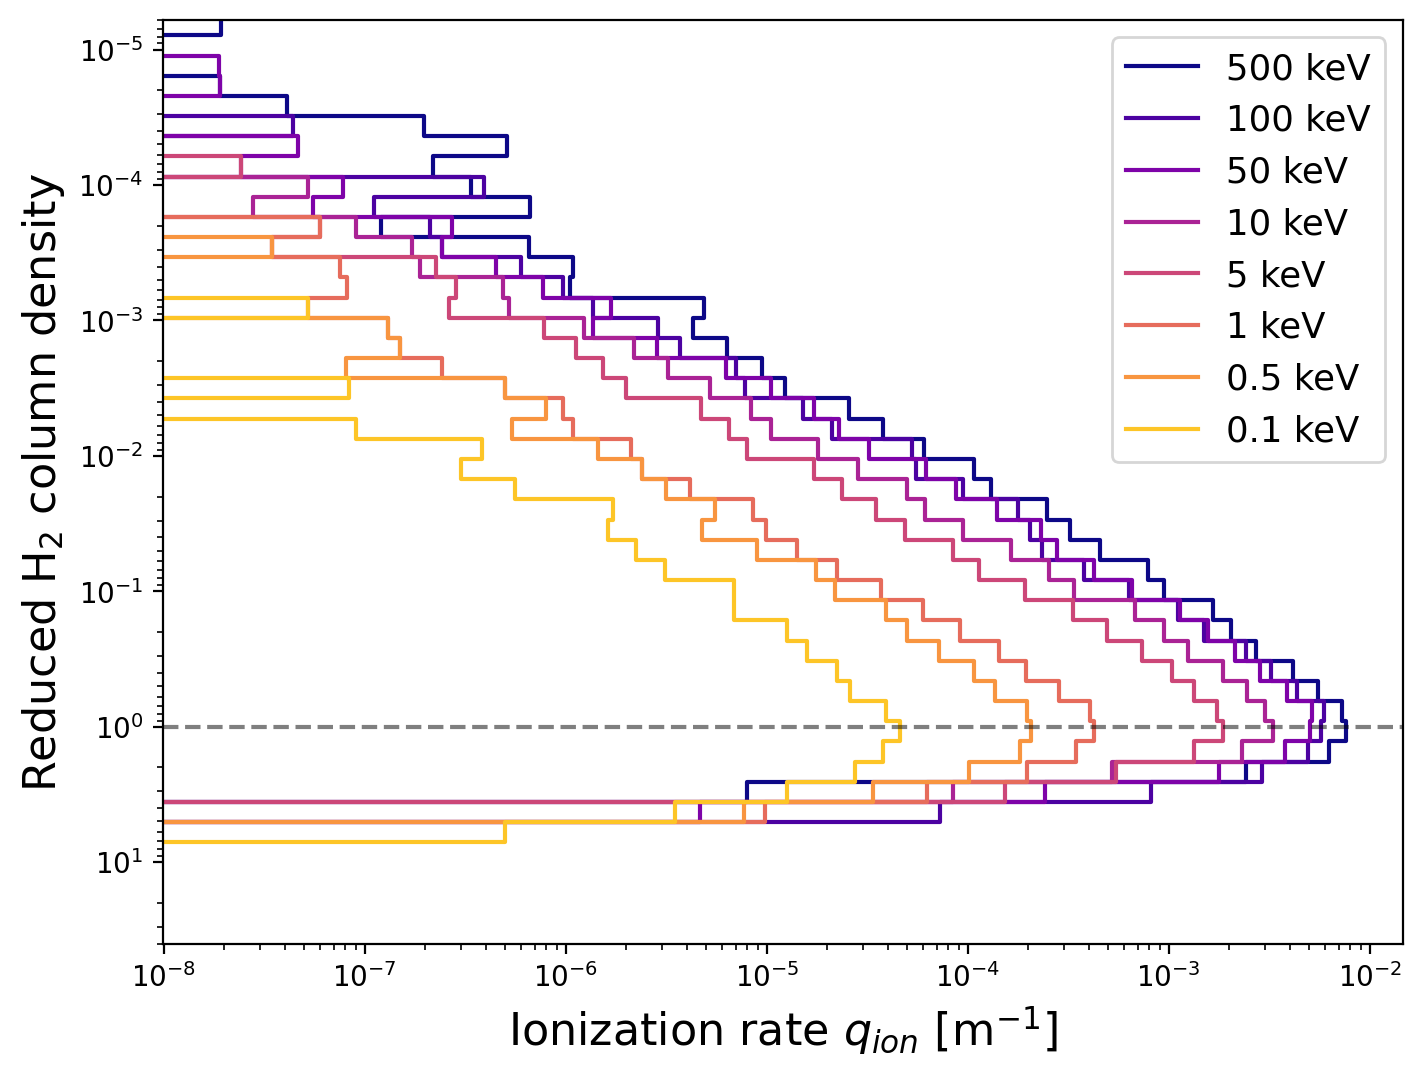

In [22]:
plt.figure(figsize = [8,6], dpi = 200)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
z_min = 150e3
z_max = 2200e3
NoverN0_min = 1e-6
NoverN0_max = 20e0
nbins = 50
Ne = 1000
mH2 = 3.347649043E-27 # H2 mass [kg]
atm_type = 'Jupiter'
npoints = 500

sonora_filepath = './Sonora_data'
get_n_H2, get_P_H2 = utils.construct_profile_Jupiter(atm_type, z_max, sonora_filepath)
z_grid = np.linspace(0,z_max,100)
N_grid = utils.construct_R_grid(z_grid, z_min, z_max, get_n_H2)

for i in range(len(energies)):
    #if energies[i] in [0.5, 5,50,500]:
    bins_sd, peak_loc_sd, peak_loc_mean, peak_val_sd, peak_val_mean = utils.get_uncertainties_general(z_ions[i], 100, bins_arr, Ne, atm_type, z_min, z_max, get_n_H2, str(energies[i]), make_plot = False, make_subset_plot = False, return_kde_curve_median_and_sd = False, plot_each_kde = False, npoints = 500)
    N_peak = utils.get_column_density(peak_loc_mean, z_grid, N_grid)/mH2
    N_ions = utils.get_column_density(z_ions[i], z_grid, N_grid)/mH2
    bins_arr_N = np.logspace(np.log10(NoverN0_min), np.log10(NoverN0_max), nbins)
    bins_arr_z = utils.get_z_from_column_density(bins_arr_N, z_grid, N_grid)[::-1] # convert R bins to z for normalizing by binwidth
    counts, bins = np.histogram(N_ions/N_peak, bins = bins_arr_N) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
    counts = counts / Ne
    binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1] #bins_z[1:] - bins_z[:-1]
#     bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
    q = counts/binwidths_z[::-1]  # this is raw counts / Ntot / binwidth [m]
    plt.step(q, bins_arr_N[1:], color = colors[i], label = str(energies[i]) + ' keV', where = 'post') # really should be where = 'pre' for bins[1:], but this is what matched kde curve

ax1 = plt.gca()
ax1.invert_yaxis()
ax1.set_xscale('log')
ax1.set_ylabel(r'Reduced H$_2$ column density', fontsize = fs)
#ytick_locs = ax1.get_yticks() # returns locs in data coords
#P = get_P_H2(ytick_locs*1000) / 1e5 # then convert to bars
#ax2 = ax1.twinx()
#ax2.set_yticks(ytick_locs)
#formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
#formatted_P = formatting_function(P)
#label_P = [P.replace('E','$^{')+'}$' for P in formatted_P]
#ax2.set_yticklabels(label_P)
#ax2.set_ybound(ax1.get_ybound())
#ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
#ax2.minorticks_on()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
ax1.legend(fontsize = 0.8*fs)
#plt.xlim([1e-7, 1e-2])
plt.semilogy()
xlims = ax1.get_xlim()
ylims = ax1.get_ylim()
plt.ylim([40, 6e-6])
plt.hlines([1], xmin = xlims[0], xmax = xlims[1], alpha = 0.5, ls = 'dashed', color = 'k')
plt.savefig('./paper_plots/Jupiter_Galileo_NoverN0_v3.pdf', format = 'pdf', bbox_inches="tight")

### Comparison of Jupiter to T-dwarf for a few energies

In [6]:
results_dir = '/projects/anzu2965/SPI/beam_sim/Run_Outputs/Jupiter_Galileo' 
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.37.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_Jup = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

atm_type = 'T900_g5.0'
results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.01.h5'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_900K_g5 = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

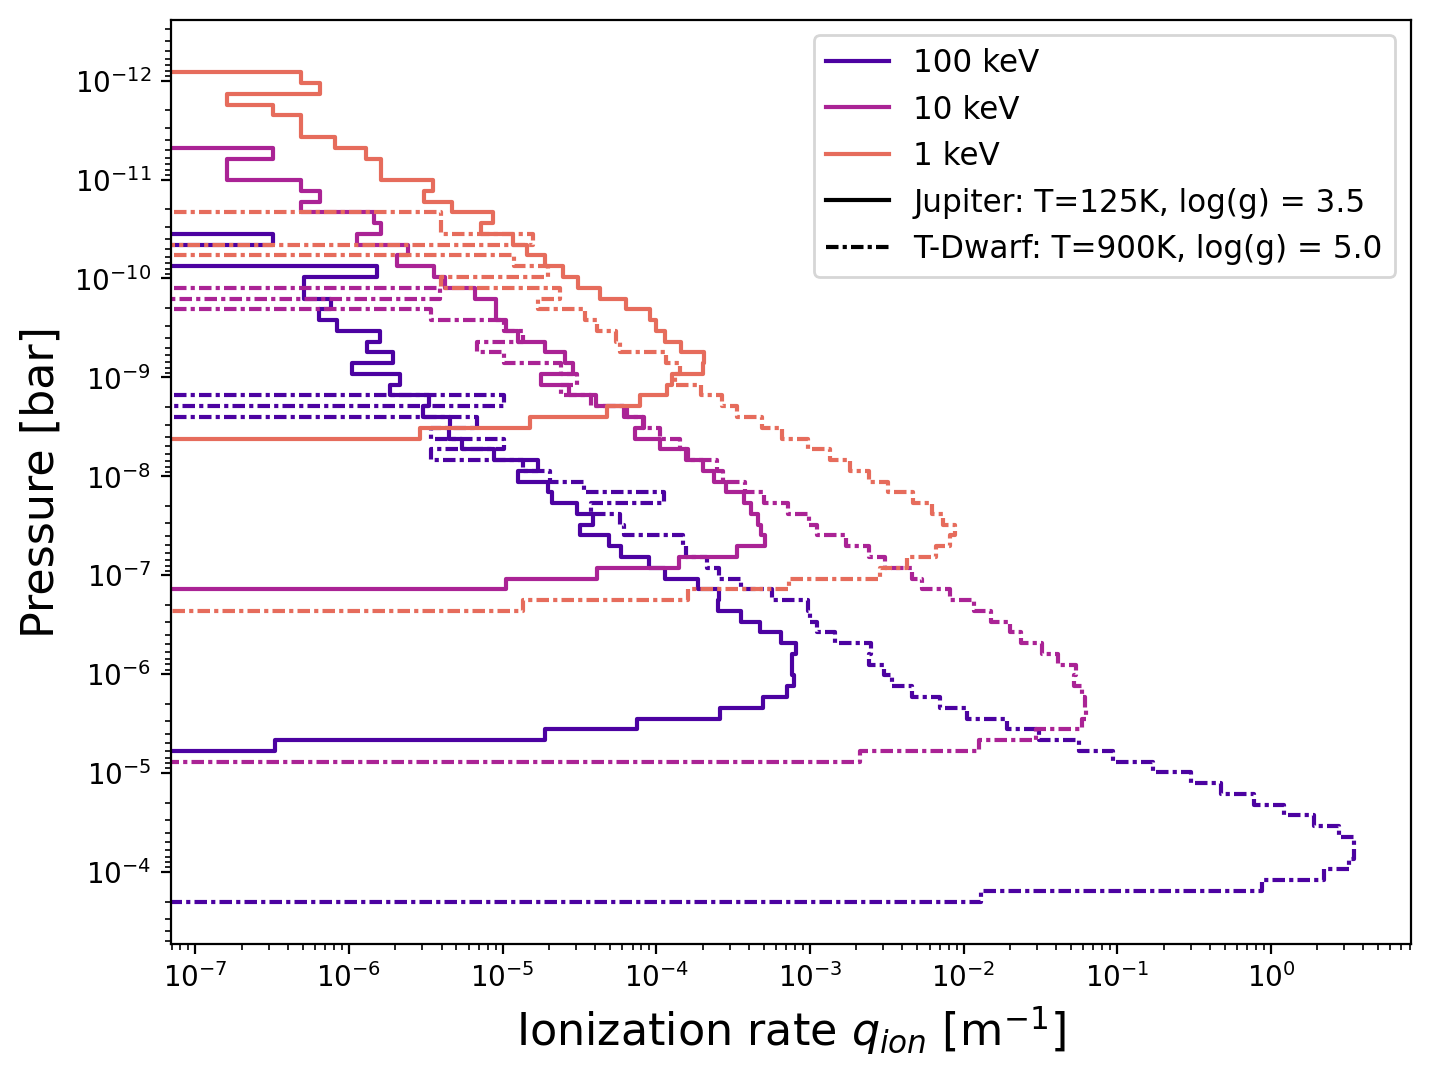

In [40]:
plt.figure(figsize = [8,6], dpi = 200)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
z_min_Jupiter = 150e3
z_max_Jupiter = 2200e3
z_min_900K_g5 = 10e3
z_max_900K_g5 = 30e3
P_min = 5e-13
P_max = 2e-4
nbins = 80
Ne = 1000
mH2 = 3.347649043E-27 # H2 mass [kg]
sonora_filepath = './Sonora_data'

get_n_H2_Jupiter, get_P_H2_Jupiter = utils.construct_profile_Jupiter('Jupiter', z_max_Jupiter, sonora_filepath)
get_n_H2_900K_g5, get_P_H2_900K_g5 = utils.construct_profiles('T900_g5.0', z_max_900K_g5, sonora_filepath)

z_grid_Jupiter = np.linspace(z_min_Jupiter, z_max_Jupiter, 1000)
P_grid_Jupiter = get_P_H2_Jupiter(z_grid_Jupiter) / 1e5
z_of_P_spline_Jupiter = spline(P_grid_Jupiter[::-1], z_grid_Jupiter[::-1], k=1)

z_grid_900K_g5 = np.linspace(z_min_900K_g5, z_max_900K_g5, 1000)
P_grid_900K_g5 = get_P_H2_900K_g5(z_grid_900K_g5) / 1e5
z_of_P_spline_900K_g5 = spline(P_grid_900K_g5[::-1], z_grid_900K_g5[::-1], k=1)

for i in range(len(energies)):
    if energies[i] in [1, 10, 100]:
        P_ions = get_P_H2_Jupiter(z_ions_Jup[i]) / 1e5 # then convert to bars
       # P_min = np.nanmin(P_ions)
       # P_max = np.nanmax(P_ions)
        bins_arr_P = np.logspace(np.log10(P_min), np.log10(P_max), nbins)
        counts, bins = np.histogram(P_ions, bins = bins_arr_P) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        bins_arr_z = z_of_P_spline_Jupiter(bins_arr_P)[::-1] # convert P bins to z for normalizing by binwidth
        binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1]
        q = counts/binwidths_z
        plt.step(q, bins_arr_P[1:], color = colors[i], label = str(energies[i]) + ' keV')
        
        P_ions = get_P_H2_900K_g5(z_ions_900K_g5[i]) / 1e5 # then convert to bars
       # P_min = np.nanmin(P_ions)
       # P_max = np.nanmax(P_ions)
        bins_arr_P = np.logspace(np.log10(P_min), np.log10(P_max), nbins)
        counts, bins = np.histogram(P_ions, bins = bins_arr_P) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        bins_arr_z = z_of_P_spline_900K_g5(bins_arr_P)[::-1] # convert P bins to z for normalizing by binwidth
        binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1]
        q = counts/binwidths_z
        plt.step(q, bins_arr_P[1:], color = colors[i], ls = (0, (3, 1, 1, 1)))# (0, (1, 1))) #abel = str(energies[i]) + ' keV')
        
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel('Pressure [bar]', fontsize = fs)
ax1.invert_yaxis()
# ytick_locs = ax1.get_yticks() # returns locs in data coords
# P = get_P_H2(ytick_locs*1000) / 1e5 # then convert to bars
# ax2 = ax1.twinx()
# ax2.set_yticks(ytick_locs)
# formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
# formatted_P = formatting_function(P)
# label_P = [P.replace('E','$^{')+'}$' for P in formatted_P]
# ax2.set_yticklabels(label_P)
# ax2.set_ybound(ax1.get_ybound())
# ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
# ax2.minorticks_on()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
ax1.semilogy()
#ax1.yaxis.grid(True, which='minor')
# import matplotlib.ticker as ticker
# nticks = 250
# maj_loc = ticker.LogLocator(numticks=nticks)
# min_loc = ticker.LogLocator(subs='all', numticks=nticks)
# ax1.yaxis.set_major_locator(maj_loc)
# ax1.yaxis.set_minor_locator(min_loc)
# from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# ax1.yaxis.set_minor_locator(MultipleLocator(5))
# from matplotlib.ticker import LogLocator
# ax1.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax1.xaxis.set_major_locator(ticker.LogLocator(numticks=999))
ax1.xaxis.set_minor_locator(ticker.LogLocator(numticks=999, subs="auto"))
ax1.minorticks_on()
#plt.xlim([5e-7, 1e-2])
# plt.tick_params(axis='y', which='minor')
# from matplotlib.ticker import FormatStrFormatter
# ax1.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
plt.plot([],[], ls = 'solid', color = 'k', label = 'Jupiter: T=125K, log(g) = 3.5')
plt.plot([],[], ls =  (0, (3, 1, 1, 1)), color = 'k', label = 'T-Dwarf: T=900K, log(g) = 5.0')
ax1.legend(fontsize = 0.7*fs) 
plt.savefig('./paper_plots/Jupiter_Tdwarf_comparison_v2.pdf', format = 'pdf', bbox_inches="tight")

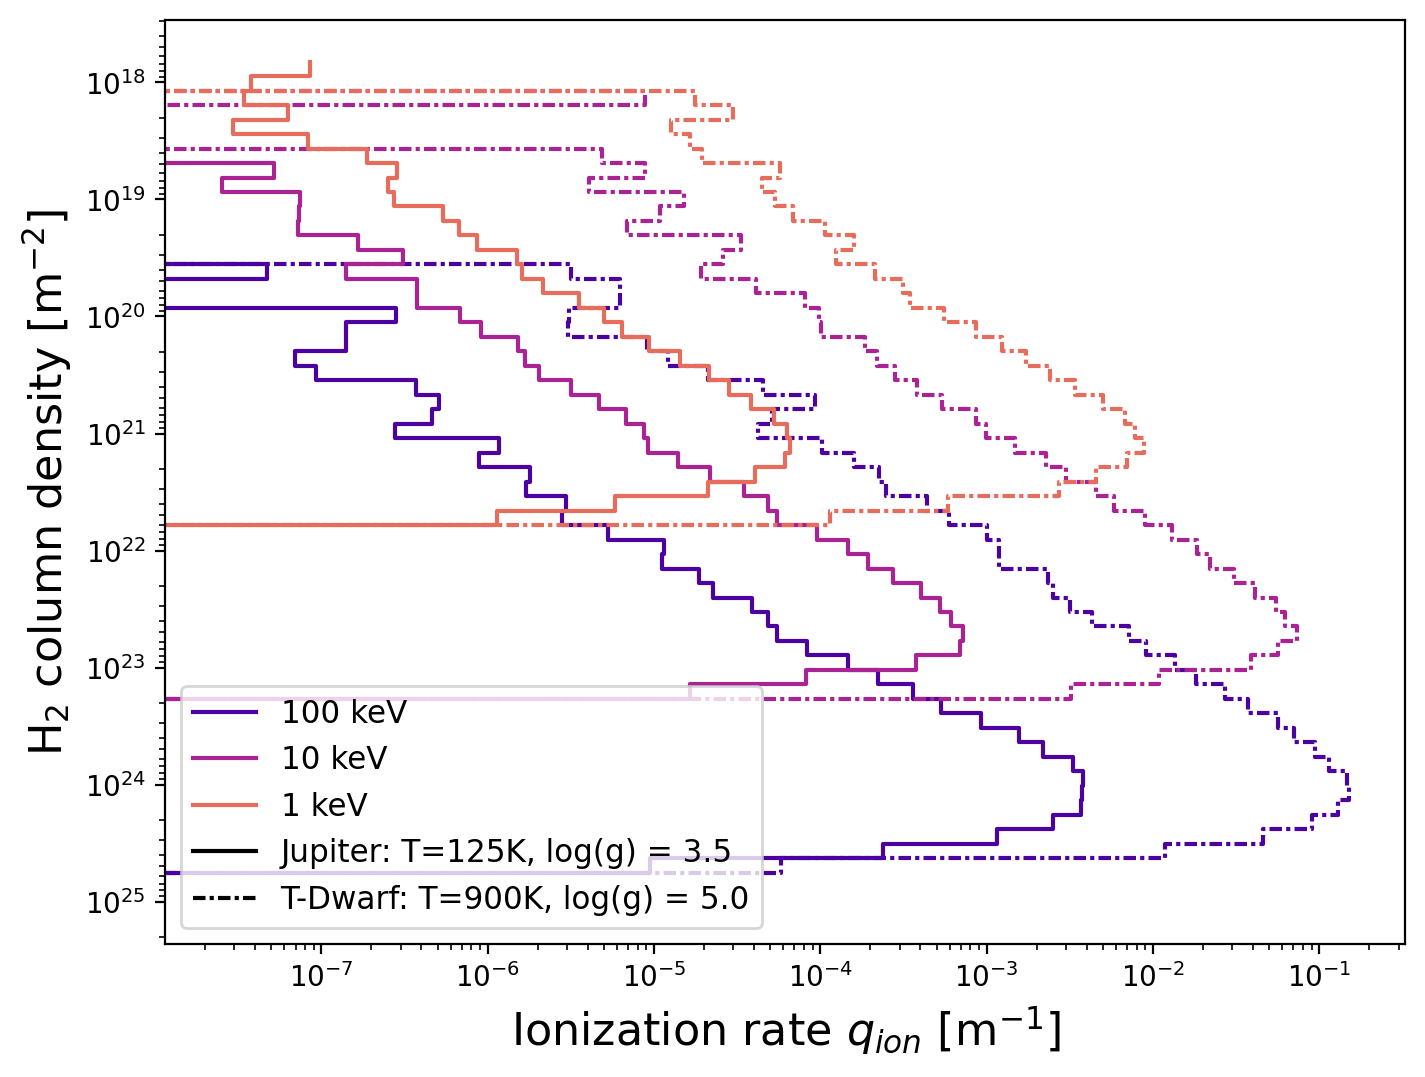

In [41]:
plt.figure(figsize = [8,6], dpi = 200)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
z_min_Jupiter = 150e3
z_max_Jupiter = 2200e3
z_min_900K_g5 = 10e3
z_max_900K_g5 = 30e3
N_min = 5e17
N_max = 1e25
P_min = 5e-13
P_max = 5e-4
nbins = 60
Ne = 1000
mH2 = 3.347649043E-27 # H2 mass [kg]
sonora_filepath = './Sonora_data'

get_n_H2_Jupiter, get_P_H2_Jupiter = utils.construct_profile_Jupiter('Jupiter', z_max_Jupiter, sonora_filepath)
get_n_H2_900K_g5, get_P_H2_900K_g5 = utils.construct_profiles('T900_g5.0', z_max_900K_g5, sonora_filepath)

# z_grid_Jupiter = np.linspace(z_min_Jupiter, z_max_Jupiter, 1000)
# P_grid_Jupiter = get_P_H2_Jupiter(z_grid_Jupiter) / 1e5
# z_of_P_spline_Jupiter = spline(P_grid_Jupiter[::-1], z_grid_Jupiter[::-1], k=1)

z_grid_Jupiter = np.linspace(0,z_max_Jupiter,100)
N_grid_Jupiter = utils.construct_R_grid(z_grid_Jupiter, z_min_Jupiter, z_max_Jupiter, get_n_H2_Jupiter)

z_grid_900K_g5 = np.linspace(0,z_max_900K_g5,100)
N_grid_900K_g5 = utils.construct_R_grid(z_grid_900K_g5, z_min_900K_g5, z_max_900K_g5, get_n_H2_900K_g5)

# z_grid_900K_g5 = np.linspace(z_min_900K_g5, z_max_900K_g5, 1000)
# P_grid_900K_g5 = get_P_H2_900K_g5(z_grid_900K_g5) / 1e5
# z_of_P_spline_900K_g5 = spline(P_grid_900K_g5[::-1], z_grid_900K_g5[::-1], k=1)

for i in range(len(energies)):
    if energies[i] in [1, 10, 100]:
        #bins_sd, peak_loc_sd, peak_loc_mean, peak_val_sd, peak_val_mean = utils.get_uncertainties_general(z_ions[i], 100, bins_arr, Ne, atm_type, z_min, z_max, get_n_H2, str(energies[i]), make_plot = False, make_subset_plot = False)
        #N_peak = utils.get_column_density(peak_loc_mean, z_grid, N_grid)/mH2
        N_ions = utils.get_column_density(z_ions_Jup[i], z_grid_Jupiter, N_grid_Jupiter)/mH2
        bins_arr_N = np.logspace(np.log10(N_min), np.log10(N_max), nbins)
        #bins_arr_N = np.linspace(N_min, N_max, nbins)
        bins_arr_z = utils.get_z_from_column_density(bins_arr_N*mH2, z_grid_Jupiter, N_grid_Jupiter)[::-1] # convert R bins to z for normalizing by binwidth
        counts, bins = np.histogram(N_ions, bins = bins_arr_N) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1] #bins_z[1:] - bins_z[:-1]
    #     bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
        q = counts/binwidths_z[::-1]  # this is raw counts / Ntot / binwidth [m]
        plt.step(q, bins_arr_N[1:], color = colors[i], label = str(energies[i]) + ' keV')

        N_ions = utils.get_column_density(z_ions_900K_g5[i], z_grid_900K_g5, N_grid_900K_g5)/mH2
        bins_arr_N = np.logspace(np.log10(N_min), np.log10(N_max), nbins)
        #bins_arr_N = np.linspace(N_min, N_max, nbins)
        bins_arr_z = utils.get_z_from_column_density(bins_arr_N*mH2, z_grid_900K_g5, N_grid_900K_g5)[::-1] # convert R bins to z for normalizing by binwidth
        counts, bins = np.histogram(N_ions, bins = bins_arr_N) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1] #bins_z[1:] - bins_z[:-1]
    #     bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
        q = counts/binwidths_z[::-1]  # this is raw counts / Ntot / binwidth [m]
        plt.step(q, bins_arr_N[1:], color = colors[i], ls = (0, (3, 1, 1, 1)))#, label = str(energies[i]) + ' keV')
        
plt.semilogy()
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel(r'H$_2$ column density [m$^{-2}$]', fontsize = fs)
ax1.invert_yaxis()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
plt.plot([],[], ls = 'solid', color = 'k', label = 'Jupiter: T=125K, log(g) = 3.5')
plt.plot([],[], ls = (0, (3, 1, 1, 1)), color = 'k', label = 'T-Dwarf: T=900K, log(g) = 5.0')
ax1.legend(fontsize = 0.7*fs) 
plt.savefig('./paper_plots/Jupiter_Tdwarf_comparison_N_v2.pdf', format = 'pdf', bbox_inches="tight")

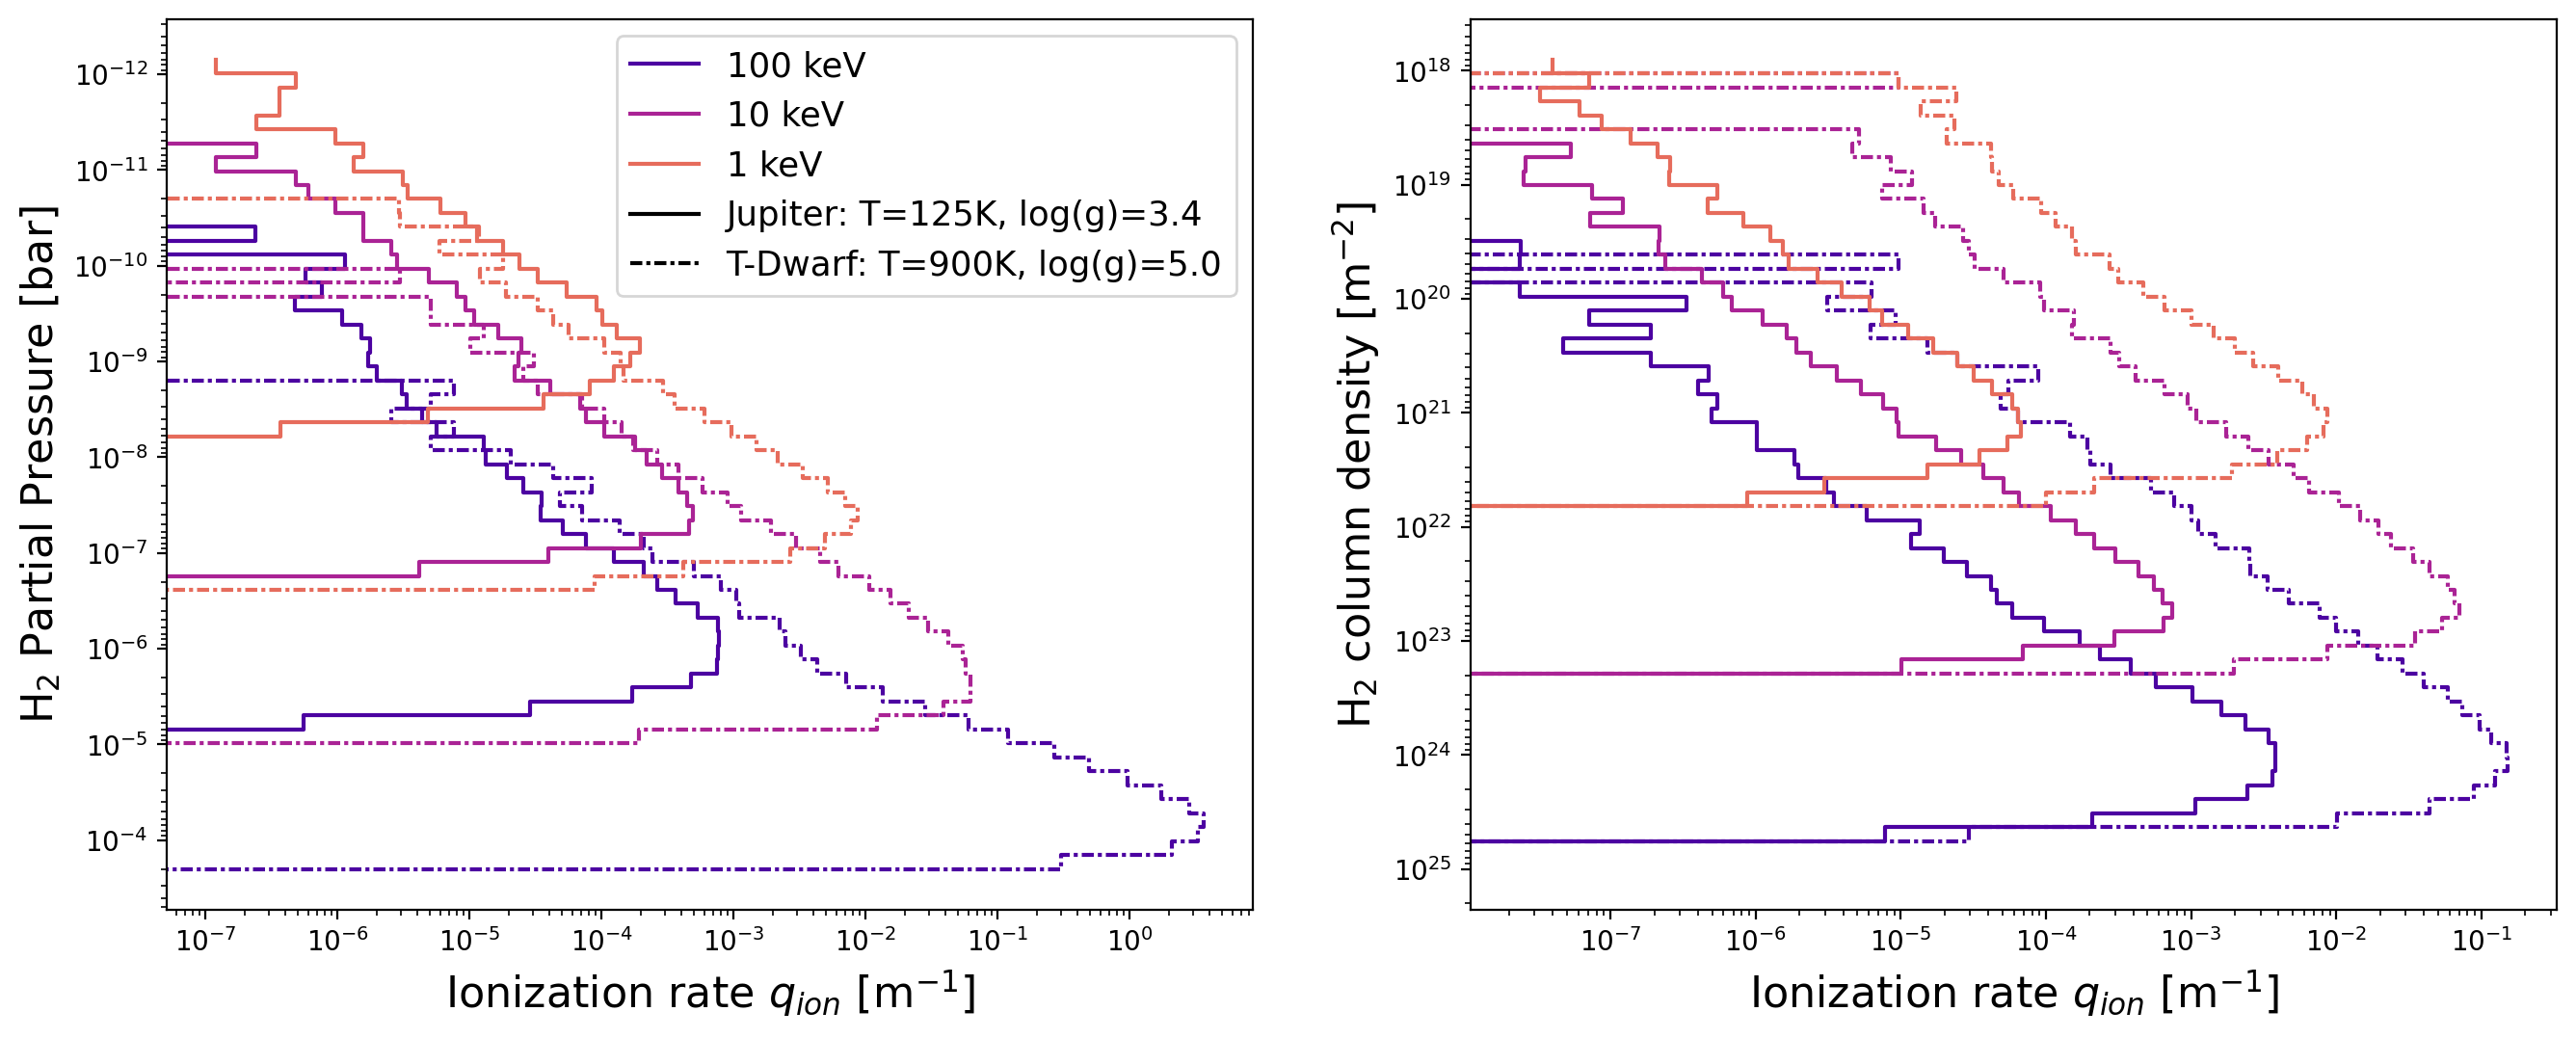

In [9]:
plt.figure(figsize= [16,6], dpi = 200)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
z_min_Jupiter = 150e3
z_max_Jupiter = 2200e3
z_min_900K_g5 = 10e3
z_max_900K_g5 = 30e3
P_min = 5e-13
P_max = 2e-4
N_min = 6e17#9.7e17
N_max = 1e25
nbins = 60
Ne = 1000
mH2 = 3.347649043E-27 # H2 mass [kg]
sonora_filepath = './Sonora_data'

get_n_H2_Jupiter, get_P_H2_Jupiter = utils.construct_profile_Jupiter('Jupiter', z_max_Jupiter, sonora_filepath)
get_n_H2_900K_g5, get_P_H2_900K_g5 = utils.construct_profiles('T900_g5.0', z_max_900K_g5, sonora_filepath)
z_grid_Jupiter = np.linspace(z_min_Jupiter, z_max_Jupiter, 1000)
P_grid_Jupiter = get_P_H2_Jupiter(z_grid_Jupiter) / 1e5
z_of_P_spline_Jupiter = spline(P_grid_Jupiter[::-1], z_grid_Jupiter[::-1], k=1)
z_grid_900K_g5 = np.linspace(z_min_900K_g5, z_max_900K_g5, 1000)
P_grid_900K_g5 = get_P_H2_900K_g5(z_grid_900K_g5) / 1e5
z_of_P_spline_900K_g5 = spline(P_grid_900K_g5[::-1], z_grid_900K_g5[::-1], k=1)

plt.subplot(121)
for i in range(len(energies)):
    if energies[i] in [1, 10, 100]:
        P_ions = get_P_H2_Jupiter(z_ions_Jup[i]) / 1e5 # then convert to bars
        bins_arr_P = np.logspace(np.log10(P_min), np.log10(P_max), nbins)
        counts, bins = np.histogram(P_ions, bins = bins_arr_P) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        bins_arr_z = z_of_P_spline_Jupiter(bins_arr_P)[::-1] # convert P bins to z for normalizing by binwidth
        binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1]
        q = counts/binwidths_z
        plt.step(q, bins_arr_P[1:], color = colors[i], label = str(energies[i]) + ' keV')       
        P_ions = get_P_H2_900K_g5(z_ions_900K_g5[i]) / 1e5 # then convert to bars
        bins_arr_P = np.logspace(np.log10(P_min), np.log10(P_max), nbins)
        counts, bins = np.histogram(P_ions, bins = bins_arr_P) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        bins_arr_z = z_of_P_spline_900K_g5(bins_arr_P)[::-1] # convert P bins to z for normalizing by binwidth
        binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1]
        q = counts/binwidths_z
        plt.step(q, bins_arr_P[1:], color = colors[i], ls = (0, (3, 1, 1, 1)))# (0, (1, 1))) #abel = str(energies[i]) + ' keV')
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax1.invert_yaxis()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
ax1.semilogy()
ax1.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax1.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
ax1.minorticks_on()
plt.plot([],[], ls = 'solid', color = 'k', label = 'Jupiter: T=125K, log(g)=3.4')
plt.plot([],[], ls =  (0, (3, 1, 1, 1)), color = 'k', label = 'T-Dwarf: T=900K, log(g)=5.0')
ax1.legend(fontsize = 0.8*fs) 

get_n_H2_Jupiter, get_P_H2_Jupiter = utils.construct_profile_Jupiter('Jupiter', z_max_Jupiter, sonora_filepath)
get_n_H2_900K_g5, get_P_H2_900K_g5 = utils.construct_profiles('T900_g5.0', z_max_900K_g5, sonora_filepath)
z_grid_Jupiter = np.linspace(0,z_max_Jupiter,100)
N_grid_Jupiter = utils.construct_R_grid(z_grid_Jupiter, z_min_Jupiter, z_max_Jupiter, get_n_H2_Jupiter)
z_grid_900K_g5 = np.linspace(0,z_max_900K_g5,100)
N_grid_900K_g5 = utils.construct_R_grid(z_grid_900K_g5, z_min_900K_g5, z_max_900K_g5, get_n_H2_900K_g5)

plt.subplot(122)
for i in range(len(energies)):
    if energies[i] in [1, 10, 100]:
        N_ions = utils.get_column_density(z_ions_Jup[i], z_grid_Jupiter, N_grid_Jupiter)/mH2
        bins_arr_N = np.logspace(np.log10(N_min), np.log10(N_max), nbins)
        bins_arr_z = utils.get_z_from_column_density(bins_arr_N*mH2, z_grid_Jupiter, N_grid_Jupiter)[::-1] # convert R bins to z for normalizing by binwidth
        counts, bins = np.histogram(N_ions, bins = bins_arr_N) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1] #bins_z[1:] - bins_z[:-1]
        q = counts/binwidths_z[::-1]  # this is raw counts / Ntot / binwidth [m]
        plt.step(q, bins_arr_N[1:], color = colors[i], label = str(energies[i]) + ' keV')
        N_ions = utils.get_column_density(z_ions_900K_g5[i], z_grid_900K_g5, N_grid_900K_g5)/mH2
        bins_arr_N = np.logspace(np.log10(N_min), np.log10(N_max), nbins)
        bins_arr_z = utils.get_z_from_column_density(bins_arr_N*mH2, z_grid_900K_g5, N_grid_900K_g5)[::-1] # convert R bins to z for normalizing by binwidth
        counts, bins = np.histogram(N_ions, bins = bins_arr_N) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        binwidths_z = bins_arr_z[1:]-bins_arr_z[:-1] #bins_z[1:] - bins_z[:-1]
        q = counts/binwidths_z[::-1]  # this is raw counts / Ntot / binwidth [m]
        plt.step(q, bins_arr_N[1:], color = colors[i], ls = (0, (3, 1, 1, 1)))#, label = str(energies[i]) + ' keV')
        
plt.semilogy()
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel(r'H$_2$ column density [m$^{-2}$]', fontsize = fs)
ax1.invert_yaxis()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
plt.plot([],[], ls = 'solid', color = 'k', label = 'Jupiter: T=125K, log(g)=3.4')
plt.plot([],[], ls = (0, (3, 1, 1, 1)), color = 'k', label = 'T-Dwarf: T=900K, log(g)=5.0')
#ax1.legend(fontsize = 0.7*fs) 


plt.savefig('./paper_plots/Jupiter_Tdwarf_comparison_v4.pdf', format = 'pdf', bbox_inches="tight")

### q with paramterization overplotted

/tmp/ipykernel_83406/3337254028.py:34: RuntimeWarning: divide by zero encountered in log10
  pdf = stats.moyal.pdf(-np.log10(N.value), mu, sigma)*(N*np.log(10))**(-1)
/projects/anzu2965/software/anaconda/envs/pymc_env/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in reciprocal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/projects/anzu2965/software/anaconda/envs/pymc_env/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


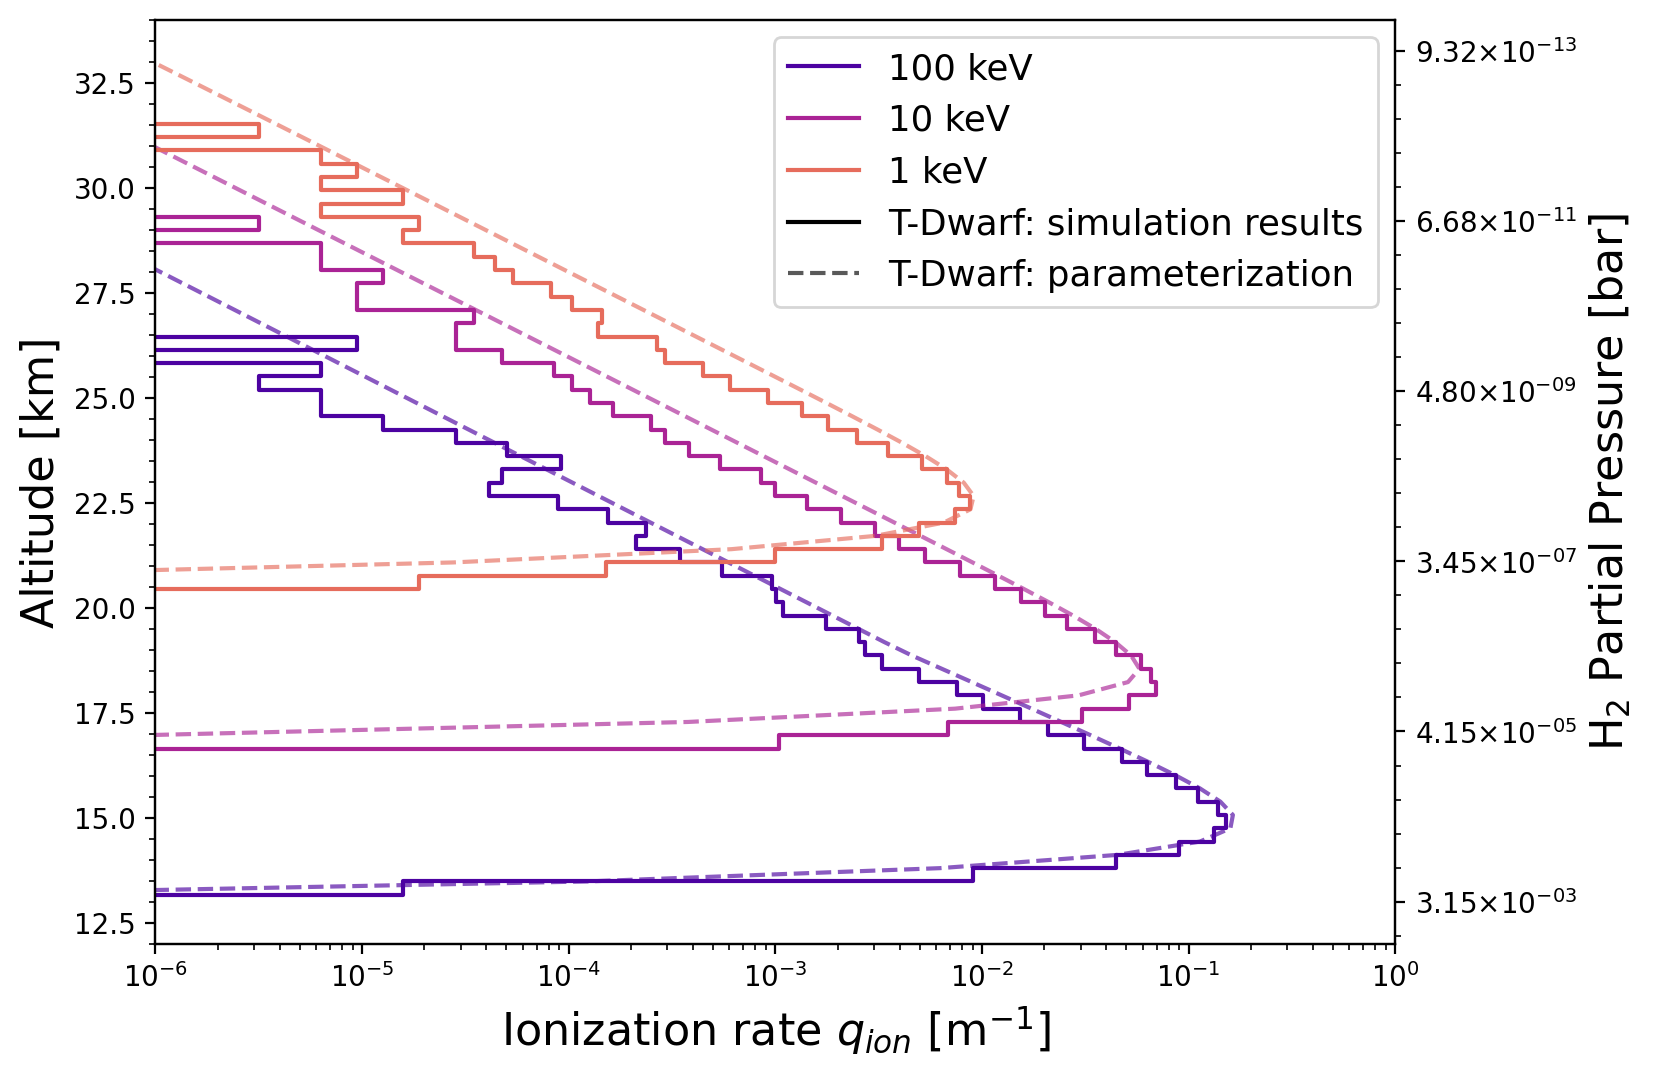

In [9]:
# NOTE: see notebook qion_and_Qion.ipynb for errorbars

plt.figure(figsize = [8,6], dpi = 200)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
z_min = 10e3
z_max = 35e3
nbins = 80
Ne = 1000
sonora_filepath = './Sonora_data'

z_ions = z_ions_900K_g5
atm_type = 'T900_g5.0'
get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
alpha = 0.65
for i in range(len(energies)):
    if energies[i] in [1,10,100]:
        bins_arr = np.linspace(z_min, z_max, nbins)
        binwidth = bins_arr[1] - bins_arr[0]
        counts, bins = np.histogram(z_ions[i], bins = bins_arr) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        binwidth = (bins[1]-bins[0])
        bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
        q = counts/binwidth
        plt.step(q, bins[:-1]/1000, color = colors[i], label = str(energies[i]) + ' keV', where = 'post')
        Nion_over_Ne = Nion_over_Ne_fit(energies[i])
        plt.plot(calc_q_ion(bins[1:], energies[i]*u.keV, z_min, z_max, Nion_over_Ne, get_n_H2), bins[1:]/1e3, ls = 'dashed', alpha = alpha, color = cmap[i])
    
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel('Altitude [km]', fontsize = fs)
ytick_locs = ax1.get_yticks() # returns locs in data coords
P = get_P_H2(ytick_locs*1000) / 1e5 # then convert to bars
ax2 = ax1.twinx()
ax2.set_yticks(ytick_locs)
formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
formatted_P = formatting_function(P)
label_P = [P.replace('E',r'$\times 10^{')+'}$' for P in formatted_P]
ax2.set_yticklabels(label_P)
ax2.set_ybound(ax1.get_ybound())
ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax2.minorticks_on()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
ax1.plot([],[], ls = 'solid', color = 'k', label = 'T-Dwarf: simulation results')
ax1.plot([],[], ls = 'dashed', alpha = alpha, color = 'k', label = 'T-Dwarf: parameterization')
ax1.legend(fontsize = 0.8*fs)
ax1.set_xlim([1e-6, 1e0])
ax1.set_ylim([12,34])
plt.savefig('./paper_plots/900K_g5_q_with_parameterization_v2.pdf', format = 'pdf', bbox_inches="tight")

### KDE error regions vs parameterization, T dwarf

In [29]:
atm_type = 'T900_g5.0'
results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
energies = np.array([500, 100, 50, 10, 5, 1, 0.5, 0.1])
sonora_filepath = './Sonora_data'
z_max = 37.612e3 * 1.2
z_min = 10e3
get_n_H2, get_pressure = utils.construct_profiles(atm_type, z_max, sonora_filepath)
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.01.h5'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_900K_g5 = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

In [10]:
importlib.reload(utils)

/projects/anzu2965/SPI/beam_sim/utils.py:2990: SyntaxWarning: invalid escape sequence '\s'
  elif atm_type == 'T1400_g4.0':
/projects/anzu2965/SPI/beam_sim/utils.py:2997: SyntaxWarning: invalid escape sequence '\s'
  elif atm_type == 'T900_g4.0':
/projects/anzu2965/SPI/beam_sim/utils.py:3004: SyntaxWarning: invalid escape sequence '\s'
  elif atm_type == 'T1400_g5.0':
/projects/anzu2965/SPI/beam_sim/utils.py:3011: SyntaxWarning: invalid escape sequence '\s'
  elif atm_type == 'T482_g4.7':
/projects/anzu2965/SPI/beam_sim/utils.py:3032: SyntaxWarning: invalid escape sequence '\s'
  else:


<module 'utils' from '/projects/anzu2965/SPI/beam_sim/utils.py'>

In [30]:
z_list = z_ions_900K_g5#[z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]
Ne = 1000
z = np.linspace(z_min, z_max-1, 1000) # m
nbins = 100
bins_arr = np.linspace(z_min, z_max, nbins)
binwidth = bins_arr[1] - bins_arr[0]
get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
kde_peak_locs = []
kde_peak_vals = []
kde_peak_locs_sd = []
kde_peak_vals_sd = []
parameterization_peak_locs = []
parameterization_peak_vals = []
bins_sd_list = []
kde_curve_medians = []
kde_curve_sds = []
npoints = 500

for i in range(len(energies)): 
    print(str(energies[i]) + ' keV: ')
    nfolds = 100
    Ntot = len(z_list[i])
    min_val = z_min
    max_val = z_max 
    bins_sd, peak_loc_sd, peak_loc_mean, peak_val_sd, peak_val_mean, kde_curve_median, kde_curve_sd = utils.get_uncertainties_general(z_list[i], nfolds, bins_arr, Ntot, atm_type, min_val, max_val, get_n_H2, str(energies[i]) + '_' + atm_type, make_plot = False, make_subset_plot = False, return_kde_curve_median_and_sd = True, plot_each_kde = False, npoints = npoints)
    bins_err = 3*bins_sd/binwidth
#     plt.step(q_ion, binedges[:-1]/1e3, label = str(energies[i]) + ' keV', color = cmap[i], where = 'post') 
#     plt.fill_betweenx((bincenters - binwidth/2)/1e3, q_ion-bins_err, q_ion+bins_err, step = 'pre', alpha = 0.3, color = cmap[i], linewidth = 0.0)#, label = 'kde bin error (3*sd)')    
#     plt.plot(q_ion_calculated_fit_Nion_list[i], z/1e3, ls = 'dashed', alpha = alpha, markersize = 7, color = cmap[i])#, label = 'parameterization')  
#     q_ion_calculated_bins = np.interp(bincenters, z, q_ion_calculated_fit_Nion_list[i])
#     err = np.mean(np.abs((q_ion - q_ion_calculated_bins.value)/q_ion)[q_ion>0])

    #kde_histogram_val = peak_val_mean * len(z_list[i]) * binwidth 
    #kde_qion_val = 

    bins_sd_list += [bins_sd]
    kde_peak_locs += [peak_loc_mean]
    kde_peak_vals += [peak_val_mean*Ntot/Ne]
    kde_peak_locs_sd += [peak_loc_sd]
    kde_peak_vals_sd += [peak_val_sd*Ntot/Ne]
    kde_curve_medians += [kde_curve_median*Ntot/Ne]
    kde_curve_sds += [kde_curve_sd*Ntot/Ne]
#     parameterization_peak_locs += [z[q_ion_calculated_fit_Nion_list[i] == np.max(q_ion_calculated_fit_Nion_list[i])][0]]
#     parameterization_peak_vals += [np.max(q_ion_calculated_fit_Nion_list[i]).value]    
    
#    plt.xlim([1e-6,1e0])
#    xlims = plt.gca().get_xlim()

500.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  3892  per fold, of 389265  total interactions.
100.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  3098  per fold, of 309860  total interactions.
50.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  2454  per fold, of 245432  total interactions.
10.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  1470  per fold, of 147027  total interactions.
5.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  845  per fold, of 84511  total interactions.
1.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  182  per fold, of 18253  total interactions.
0.5 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  100  per fold, of 10007  total interactions.
0.1 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  20  per fold, of 2086  total interactions.


/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: divide by zero encountered in log10
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)
/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: divide by zero encountered in reciprocal
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)
/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: invalid value encountered in multiply
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)


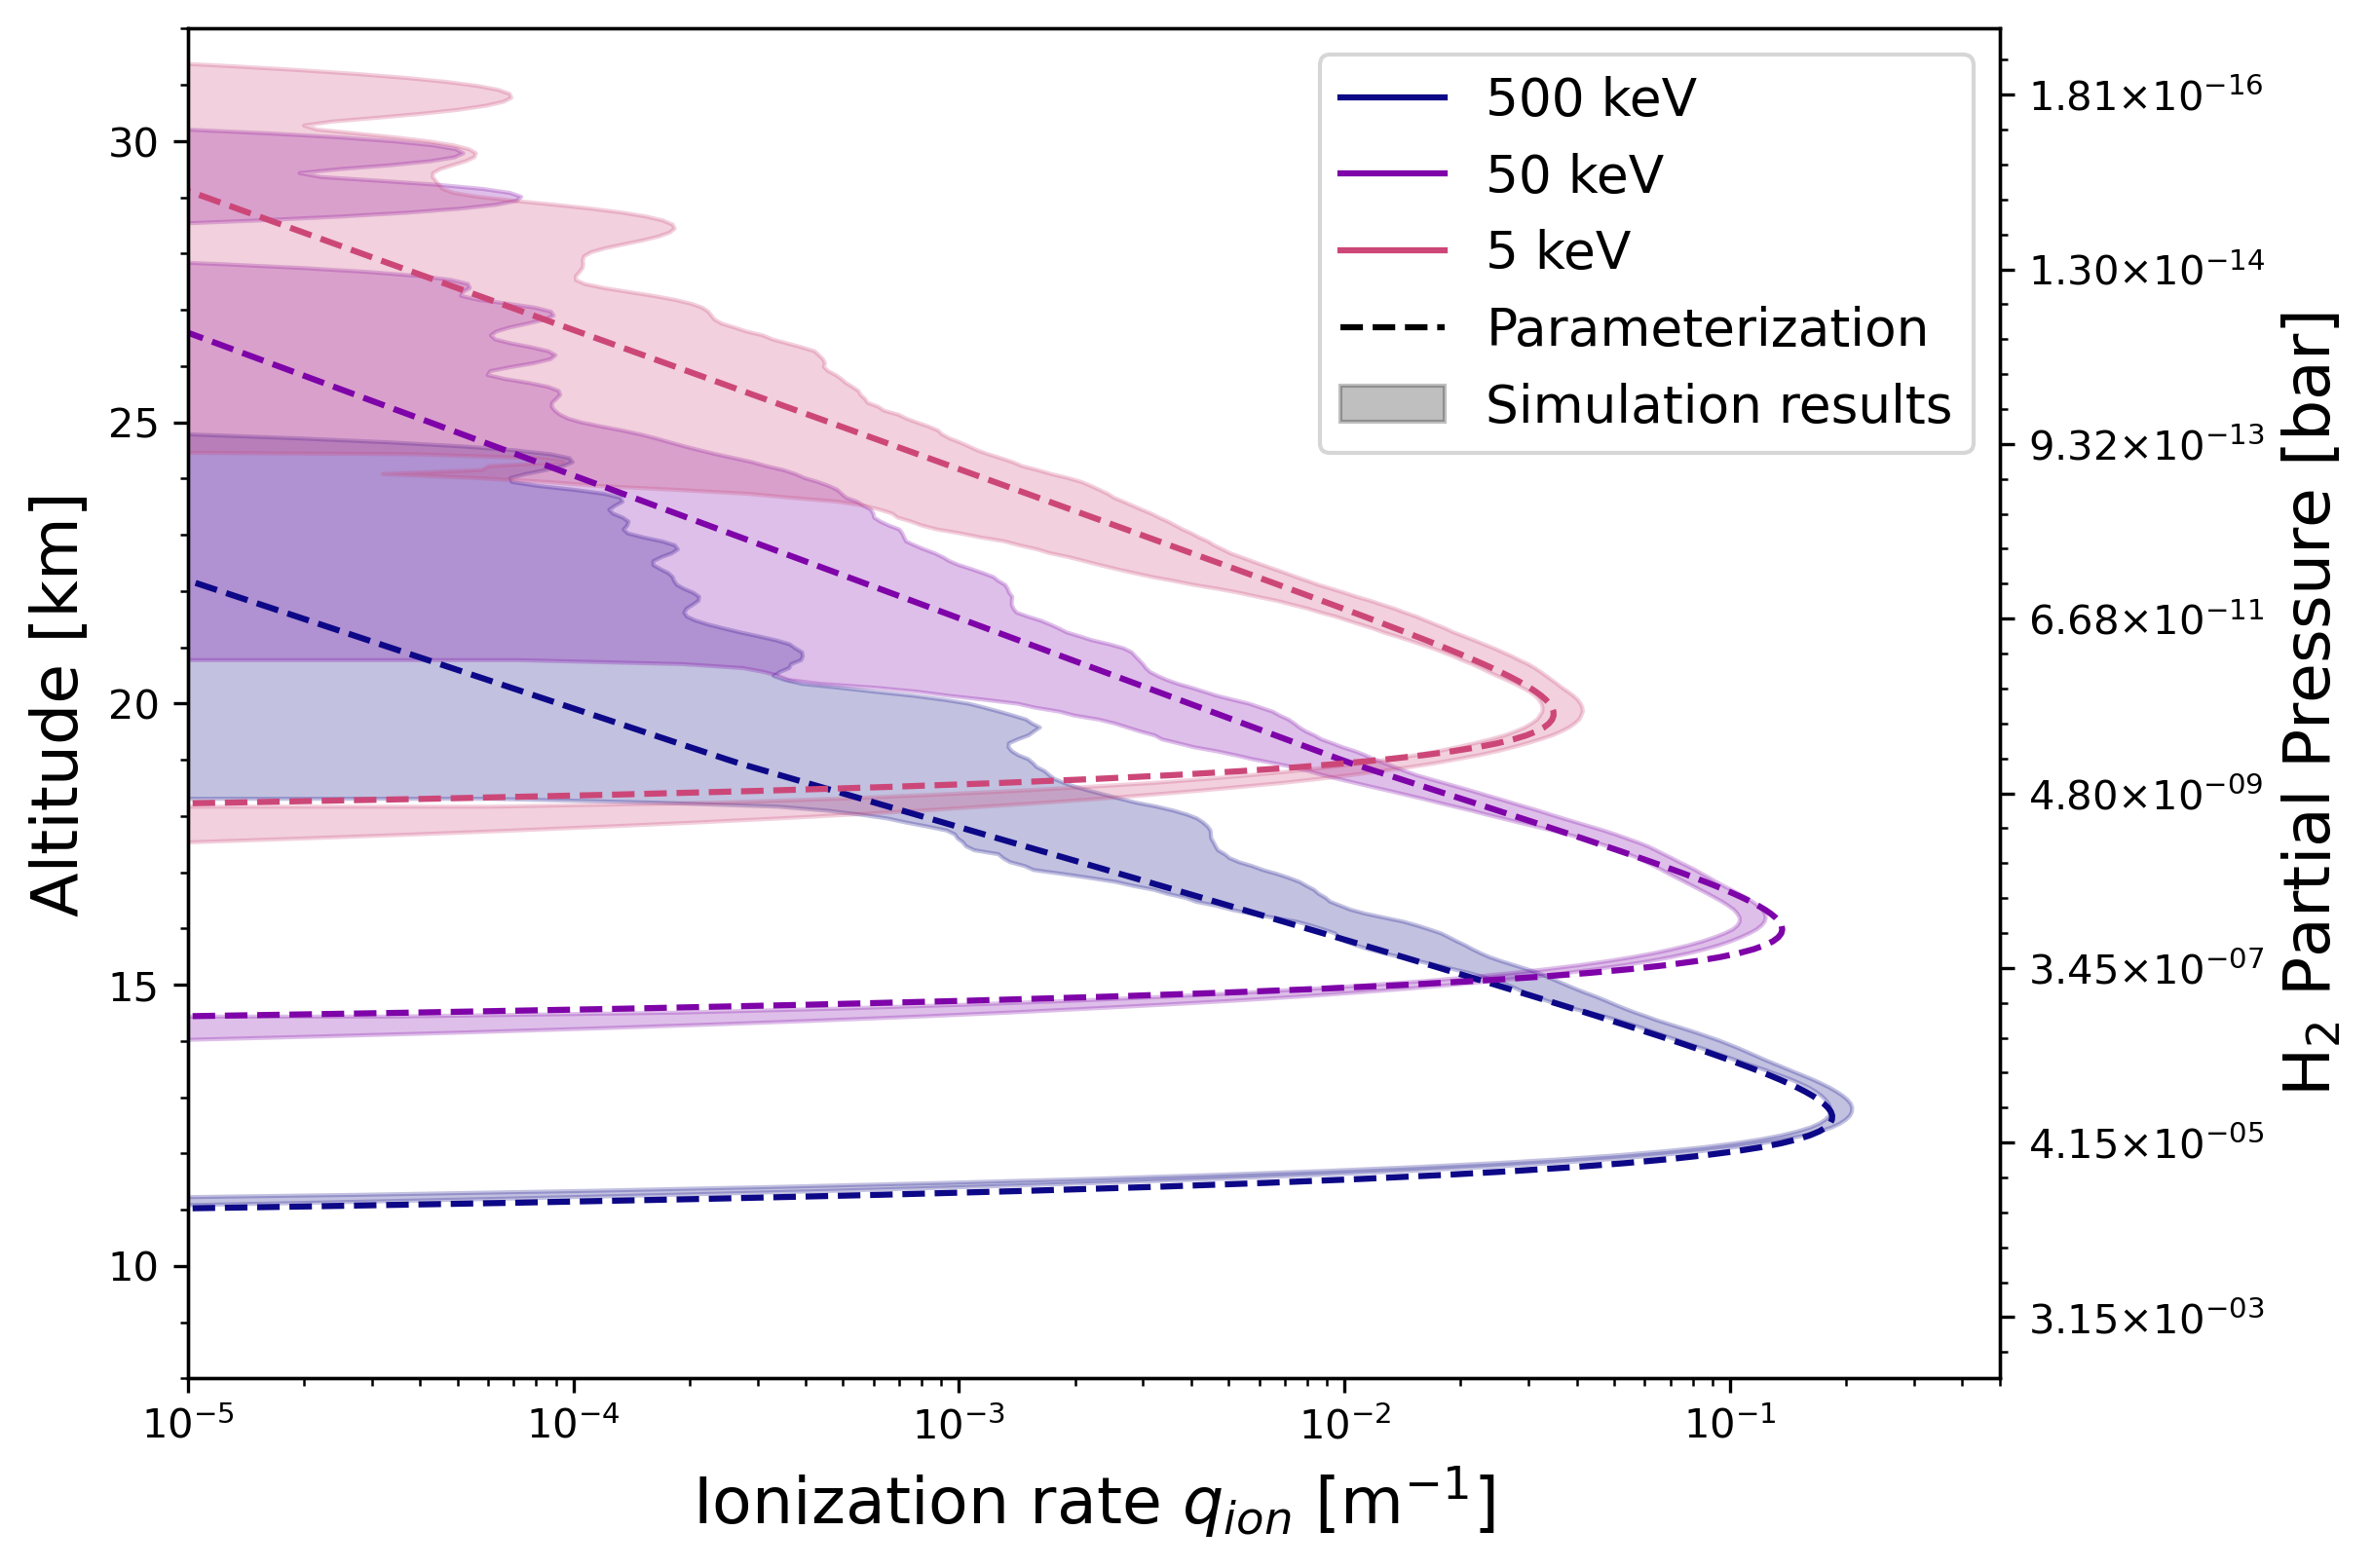

In [31]:
plt.figure(figsize = [8,6], dpi = 300)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
npoints = len(kde_curve_medians[0])
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
#z_min = 10e3
#z_max = 35e3
nbins = 80
Ne = 1000
#n_points = 100 # currenlty hardcoded in utils...
kde_z = np.linspace(z_min, z_max, npoints)
param_z = np.linspace(z_min, z_max, 500)
sonora_filepath = './Sonora_data'

z_ions = z_ions_900K_g5
atm_type = 'T900_g5.0'
get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
alpha = 0.65
for i in range(len(energies)):
    if energies[i] in [5,50,500]:
        bins_arr = np.linspace(z_min, z_max, nbins)
        binwidth = bins_arr[1] - bins_arr[0]
        counts, bins = np.histogram(z_ions[i], bins = bins_arr) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        binwidth = (bins[1]-bins[0])
        bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
        q = counts/binwidth
        #plt.step(q, bins[:-1]/1000, color = colors[i], label = str(energies[i]) + ' keV', where = 'post') # really should be correct
        #plt.step(q, bins[1:]/1000, color = colors[i], label = str(energies[i]) + ' keV', where = 'post')
        plt.step([], [], color = colors[i], label = str(energies[i]) + ' keV', where = 'post')

        Nion_over_Ne = Nion_over_Ne_fit(energies[i])
        #plt.plot(calc_q_ion(bins[1:], energies[i]*u.keV, z_min, z_max, Nion_over_Ne, get_n_H2), bins[1:]/1e3, ls = 'dashed', alpha = 1.0, color = cmap[i])
        plt.plot(utils.calc_q(param_z, energies[i], z_min, z_max, get_n_H2, 'Ionization heights [m]'), param_z/1e3, ls = 'dashed', alpha = 1.0, color = cmap[i])
        #         utils.calc_q(z, E_keV, z_min, z_max, get_n_H2, 'Ionization heights [m]')
        #plt.plot(kde_curve_medians[i]-kde_curve_sds[i], kde_z/1e3, color = cmap[i])
        #plt.plot(kde_curve_medians[i]+kde_curve_sds[i], kde_z/1e3, color = cmap[i])
        #plt.plot(kde_curve_medians[i], kde_z/1e3, color = cmap[i])
        plt.fill_betweenx(kde_z/1e3, kde_curve_medians[i]-3*kde_curve_sds[i], kde_curve_medians[i]+3*kde_curve_sds[i], color = cmap[i], alpha = 0.25)
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel('Altitude [km]', fontsize = fs)
ytick_locs = ax1.get_yticks() # returns locs in data coords
P = get_P_H2(ytick_locs*1000) / 1e5 # then convert to bars
ax2 = ax1.twinx()
ax2.set_yticks(ytick_locs)
formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
formatted_P = formatting_function(P)
label_P = [P.replace('E',r'$\times 10^{')+'}$' for P in formatted_P]
ax2.set_yticklabels(label_P)
ax2.set_ybound(ax1.get_ybound())
ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax2.minorticks_on()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
#ax1.plot([],[], ls = 'solid', color = 'k', label = 'T-Dwarf: simulation results')
ax1.plot([],[], ls = 'dashed', color = 'k', label = 'Parameterization')
ax1.fill_betweenx([],[], ls = 'solid', color = 'k', alpha = 0.25, label = 'Simulation results')
#ax1.fillbetweenx([],[],[], alpha = 0.5, color = 'k', label = r'Smoothed simulation results, \')

ax1.legend(fontsize = 0.8*fs)
ax1.set_xlim([1e-5, 0.5e0])
ax1.set_ylim([8,32])
plt.savefig('./paper_plots/900K_g5_q_kde_vs_parameterization_v4.png')#, format = 'pdf', bbox_inches="tight")

### KDE error regions vs parameterization, Jupiter Galileo

In [32]:
results_dir = '/projects/anzu2965/SPI/beam_sim/Run_Outputs/Jupiter_Galileo' 
atm_type = 'Jupiter'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.37.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_Jup = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]
energies = np.array([500, 100, 50, 10, 5, 1, 0.5, 0.1])
sonora_filepath = './Sonora_data'
z_min = 150e3
z_max = 2200e3

In [33]:
z = np.linspace(z_min, z_max-1, 1000) # m
nbins = 100
Ne = 1000
atm_type = 'Jupiter'
bins_arr = np.linspace(z_min, z_max, nbins)
binwidth = bins_arr[1] - bins_arr[0]
get_n_H2, get_P_H2 = utils.construct_profile_Jupiter(atm_type, z_max, sonora_filepath) # with Galileo
kde_peak_locs = []
kde_peak_vals = []
kde_peak_locs_sd = []
kde_peak_vals_sd = []
parameterization_peak_locs = []
parameterization_peak_vals = []
bins_sd_list = []
kde_curve_medians = []
kde_curve_sds = []
npoints = 500

for i in range(len(energies)): 
    print(str(energies[i]) + ' keV: ')
    nfolds = 100
    Ntot = len(z_ions[i])
    min_val = z_min
    max_val = z_max 
    bins_sd, peak_loc_sd, peak_loc_mean, peak_val_sd, peak_val_mean, kde_curve_median, kde_curve_sd = utils.get_uncertainties_general(z_ions_Jup[i], nfolds, bins_arr, Ntot, atm_type, min_val, max_val, get_n_H2, str(energies[i]) + '_' + atm_type, make_plot = False, make_subset_plot = False, return_kde_curve_median_and_sd = True, plot_each_kde = False, npoints = npoints)
    bins_err = 3*bins_sd/binwidth
    bins_sd_list += [bins_sd]
    kde_peak_locs += [peak_loc_mean]
    kde_peak_vals += [peak_val_mean*Ntot/Ne]
    kde_peak_locs_sd += [peak_loc_sd]
    kde_peak_vals_sd += [peak_val_sd*Ntot/Ne]
    kde_curve_medians += [kde_curve_median*Ntot/Ne]
    kde_curve_sds += [kde_curve_sd*Ntot/Ne]


500.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  3541  per fold, of 354102  total interactions.
100.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  2881  per fold, of 288114  total interactions.
50.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  2438  per fold, of 243897  total interactions.
10.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  1436  per fold, of 143665  total interactions.
5.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  831  per fold, of 83198  total interactions.
1.0 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  192  per fold, of 19204  total interactions.
0.5 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  99  per fold, of 9951  total interactions.
0.1 keV: 
calculating uncertainties in histogram bins with:
     100  folds,  22  per fold, of 2217  total interactions.


/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: divide by zero encountered in log10
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)
/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: divide by zero encountered in reciprocal
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)
/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: invalid value encountered in multiply
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)


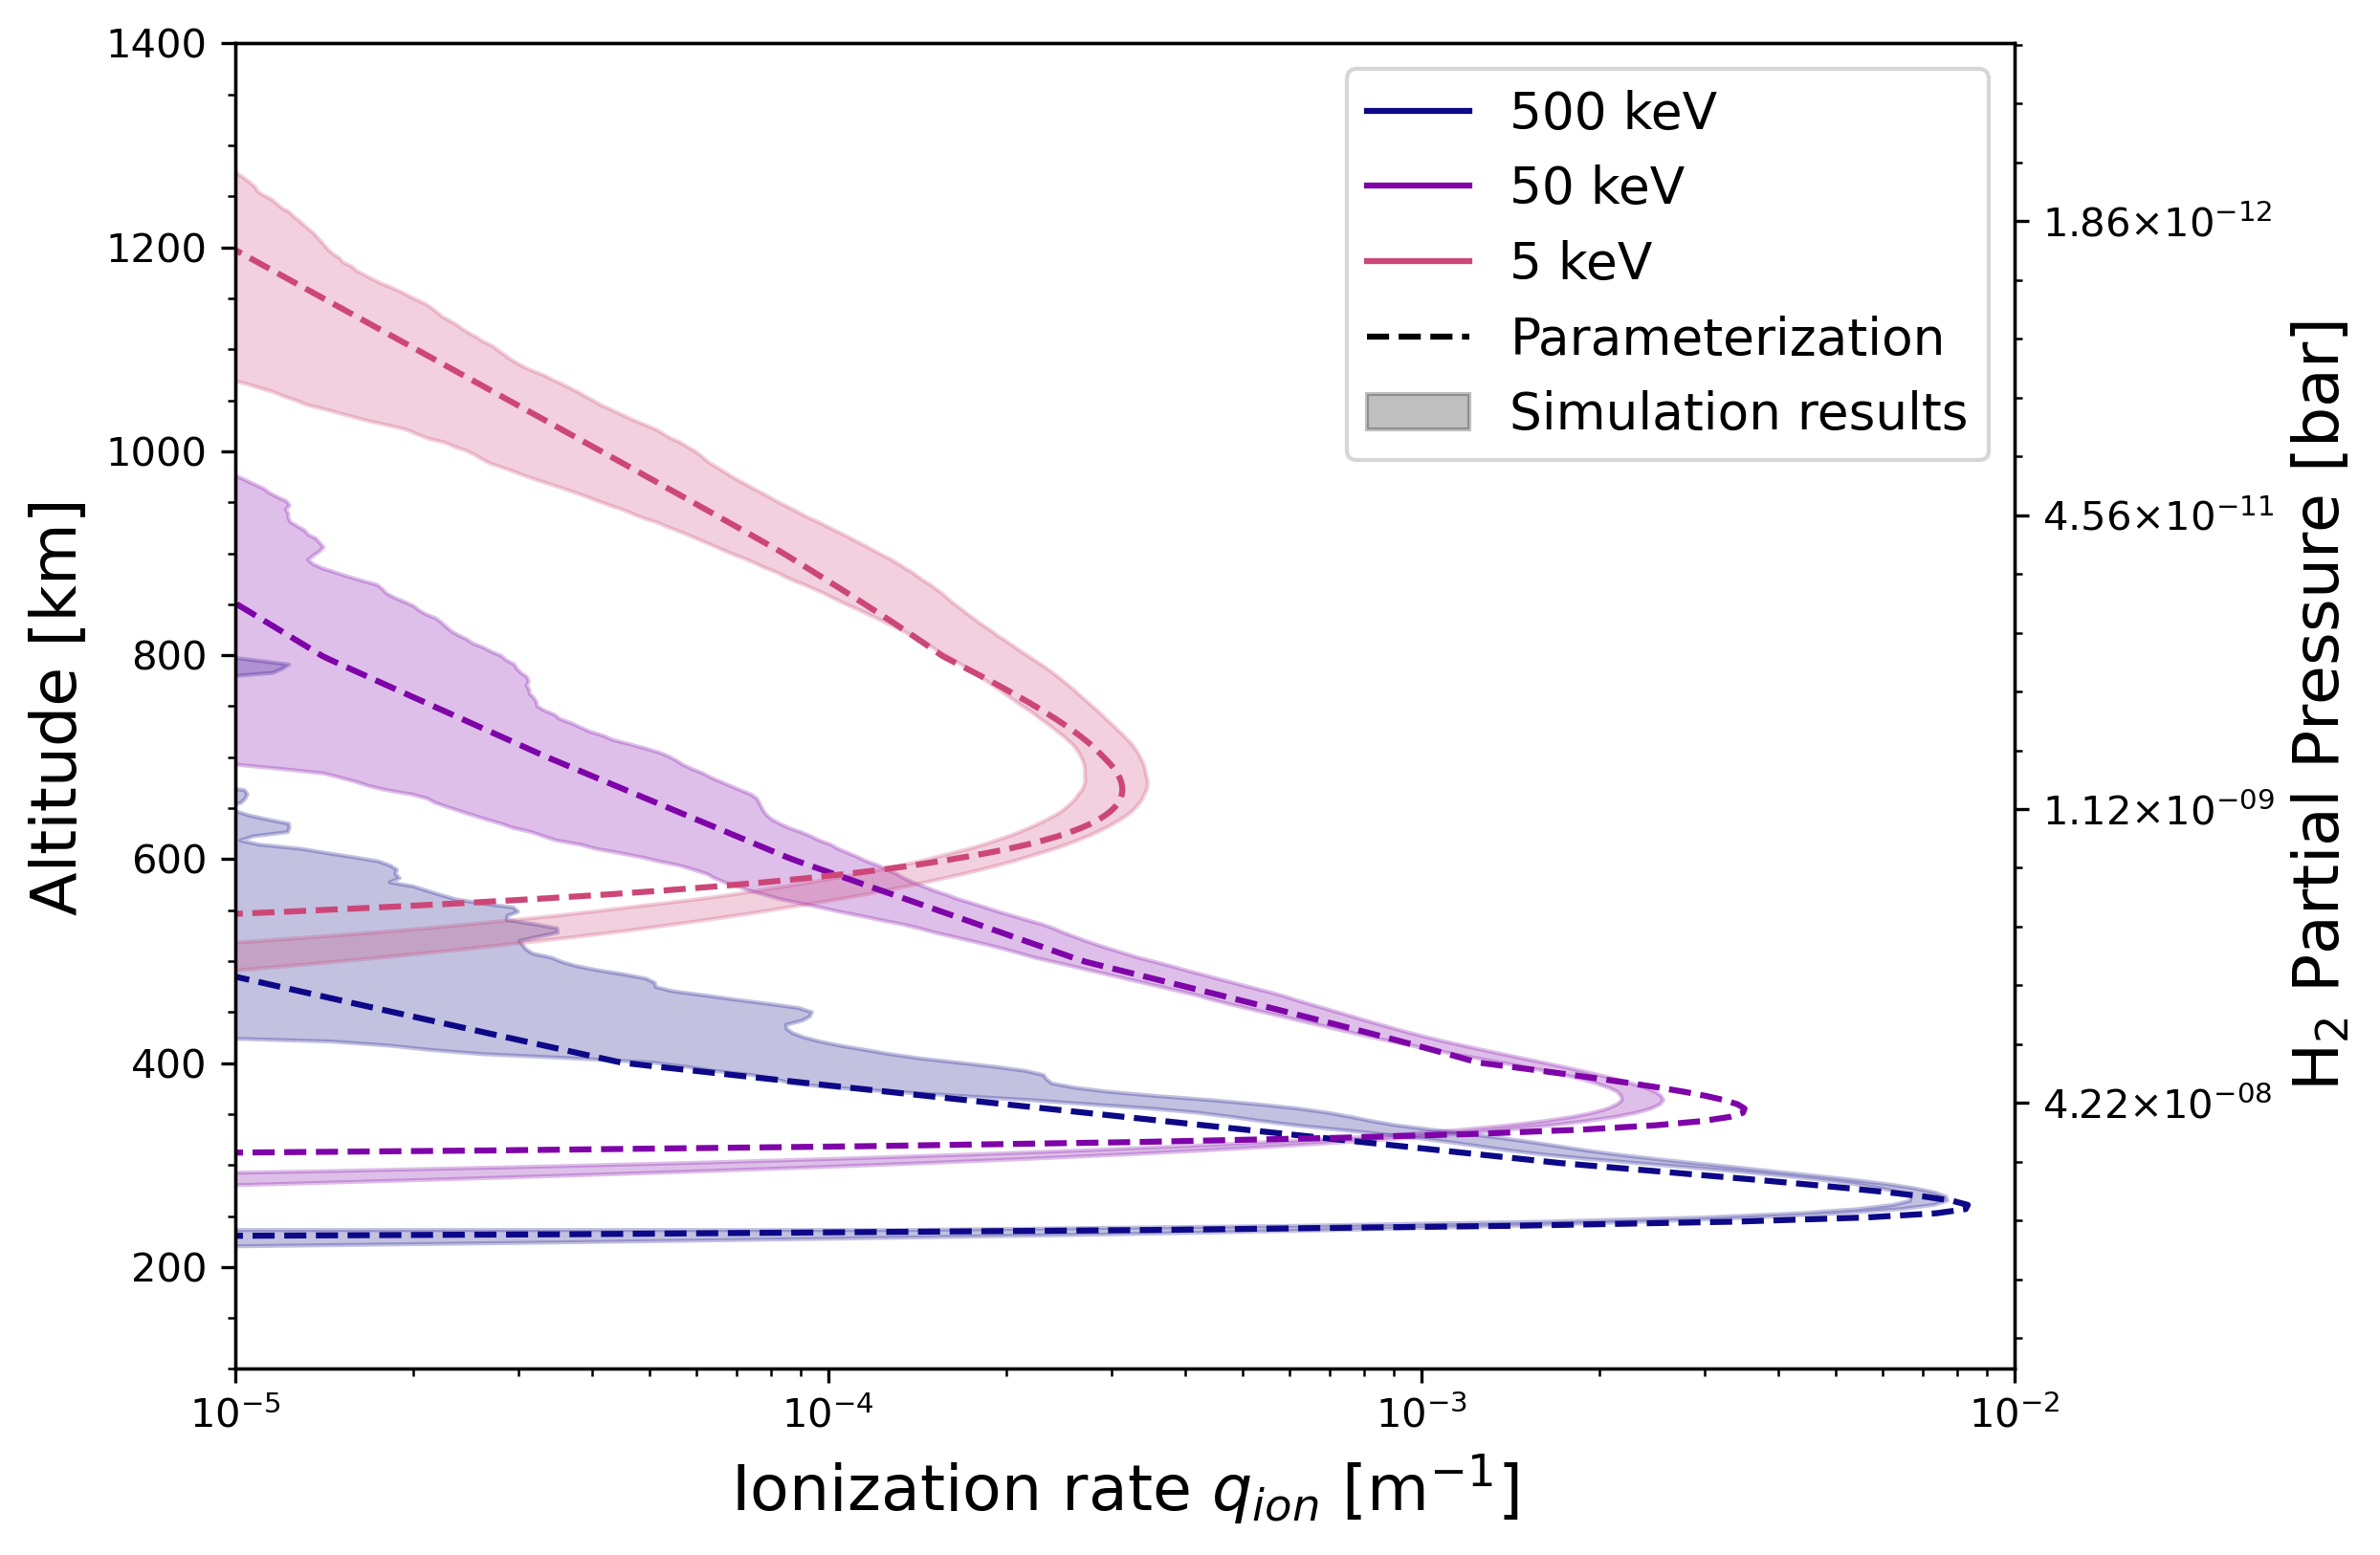

In [34]:
plt.figure(figsize = [8,6], dpi = 300)
fs = 16
energies = [500, 100, 50, 10, 5, 1, 0.5, 0.1]
npoints = len(kde_curve_medians[0])
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
#z_min = 10e3
#z_max = 35e3
nbins = 80
#n_points = 100 # currenlty hardcoded in utils...
kde_z = np.linspace(z_min, z_max, npoints)
param_z = np.linspace(z_min, z_max, 500)
sonora_filepath = './Sonora_data'

alpha = 0.65
for i in range(len(energies)):
    if energies[i] in [5,50,500]:
        bins_arr = np.linspace(z_min, z_max, nbins)
        binwidth = bins_arr[1] - bins_arr[0]
        counts, bins = np.histogram(z_ions_Jup[i], bins = bins_arr) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
        counts = counts / Ne
        binwidth = (bins[1]-bins[0])
        bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
        q = counts/binwidth
        #plt.step(q, bins[:-1]/1000, color = colors[i], label = str(energies[i]) + ' keV', where = 'post') # really should be correct
        #plt.step(q, bins[1:]/1000, color = colors[i], label = str(energies[i]) + ' keV', where = 'post')
        plt.step([], [], color = colors[i], label = str(energies[i]) + ' keV', where = 'post')

        Nion_over_Ne = Nion_over_Ne_fit(energies[i])
        #plt.plot(calc_q_ion(bins[1:], energies[i]*u.keV, z_min, z_max, Nion_over_Ne, get_n_H2), bins[1:]/1e3, ls = 'dashed', alpha = 1.0, color = cmap[i])
        plt.plot(utils.calc_q(param_z, energies[i], z_min, z_max, get_n_H2, 'Ionization heights [m]'), param_z/1e3, ls = 'dashed', alpha = 1.0, color = cmap[i])
        #         utils.calc_q(z, E_keV, z_min, z_max, get_n_H2, 'Ionization heights [m]')
        #plt.plot(kde_curve_medians[i]-kde_curve_sds[i], kde_z/1e3, color = cmap[i])
        #plt.plot(kde_curve_medians[i]+kde_curve_sds[i], kde_z/1e3, color = cmap[i])
        #plt.plot(kde_curve_medians[i], kde_z/1e3, color = cmap[i])
        plt.fill_betweenx(kde_z/1e3, kde_curve_medians[i]-3*kde_curve_sds[i], kde_curve_medians[i]+3*kde_curve_sds[i], color = cmap[i], alpha = 0.25)
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel('Altitude [km]', fontsize = fs)
ytick_locs = ax1.get_yticks() # returns locs in data coords
P = get_P_H2(ytick_locs*1000) / 1e5 # then convert to bars
ax2 = ax1.twinx()
ax2.set_yticks(ytick_locs)
formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
formatted_P = formatting_function(P)
label_P = [P.replace('E',r'$\times 10^{')+'}$' for P in formatted_P]
ax2.set_yticklabels(label_P)
ax2.set_ybound(ax1.get_ybound())
ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax2.minorticks_on()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
#ax1.plot([],[], ls = 'solid', color = 'k', label = 'T-Dwarf: simulation results')
ax1.plot([],[], ls = 'dashed', color = 'k', label = 'Parameterization')
ax1.fill_betweenx([],[], ls = 'solid', color = 'k', alpha = 0.25, label = 'Simulation results')
#ax1.fillbetweenx([],[],[], alpha = 0.5, color = 'k', label = r'Smoothed simulation results, \')

ax1.legend(fontsize = 0.8*fs)
ax1.set_xlim([1e-5, 1e-2])
ax1.set_ylim([100,1400])
plt.savefig('./paper_plots/Jup_q_kde_vs_parameterization_v4.png')#, format = 'pdf', bbox_inches="tight")

###  Compare events Jupiter

In [13]:
importlib.reload(utils)

/projects/anzu2965/SPI/beam_sim/utils.py:2951: SyntaxWarning: invalid escape sequence '\s'
  filename = atm_type+'_nc_moist_0.0metal_NR_smart.atm'
/projects/anzu2965/SPI/beam_sim/utils.py:2958: SyntaxWarning: invalid escape sequence '\s'
  filename = atm_type+'_nc_moist_0.0metal_NR_smart.atm'
/projects/anzu2965/SPI/beam_sim/utils.py:2965: SyntaxWarning: invalid escape sequence '\s'
  filename = atm_type+'_nc_moist_0.0metal_NR_smart.atm'
/projects/anzu2965/SPI/beam_sim/utils.py:2972: SyntaxWarning: invalid escape sequence '\s'
  filename = atm_type+'_nc_moist_0.0metal_NR_smart.atm'
/projects/anzu2965/SPI/beam_sim/utils.py:2993: SyntaxWarning: invalid escape sequence '\s'
  filename = atm_type+'_nc_moist_0.0metal_NR_smart.atm'


<module 'utils' from '/projects/anzu2965/SPI/beam_sim/utils.py'>

In [10]:
results_dir = '/projects/anzu2965/SPI/beam_sim/Run_Outputs/Jupiter_Galileo' 
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
df_10 = pd.read_hdf(results_file_10, 'results')#.loc['Ionization heights [m]'].dropna()

(250.0, 1900.0)

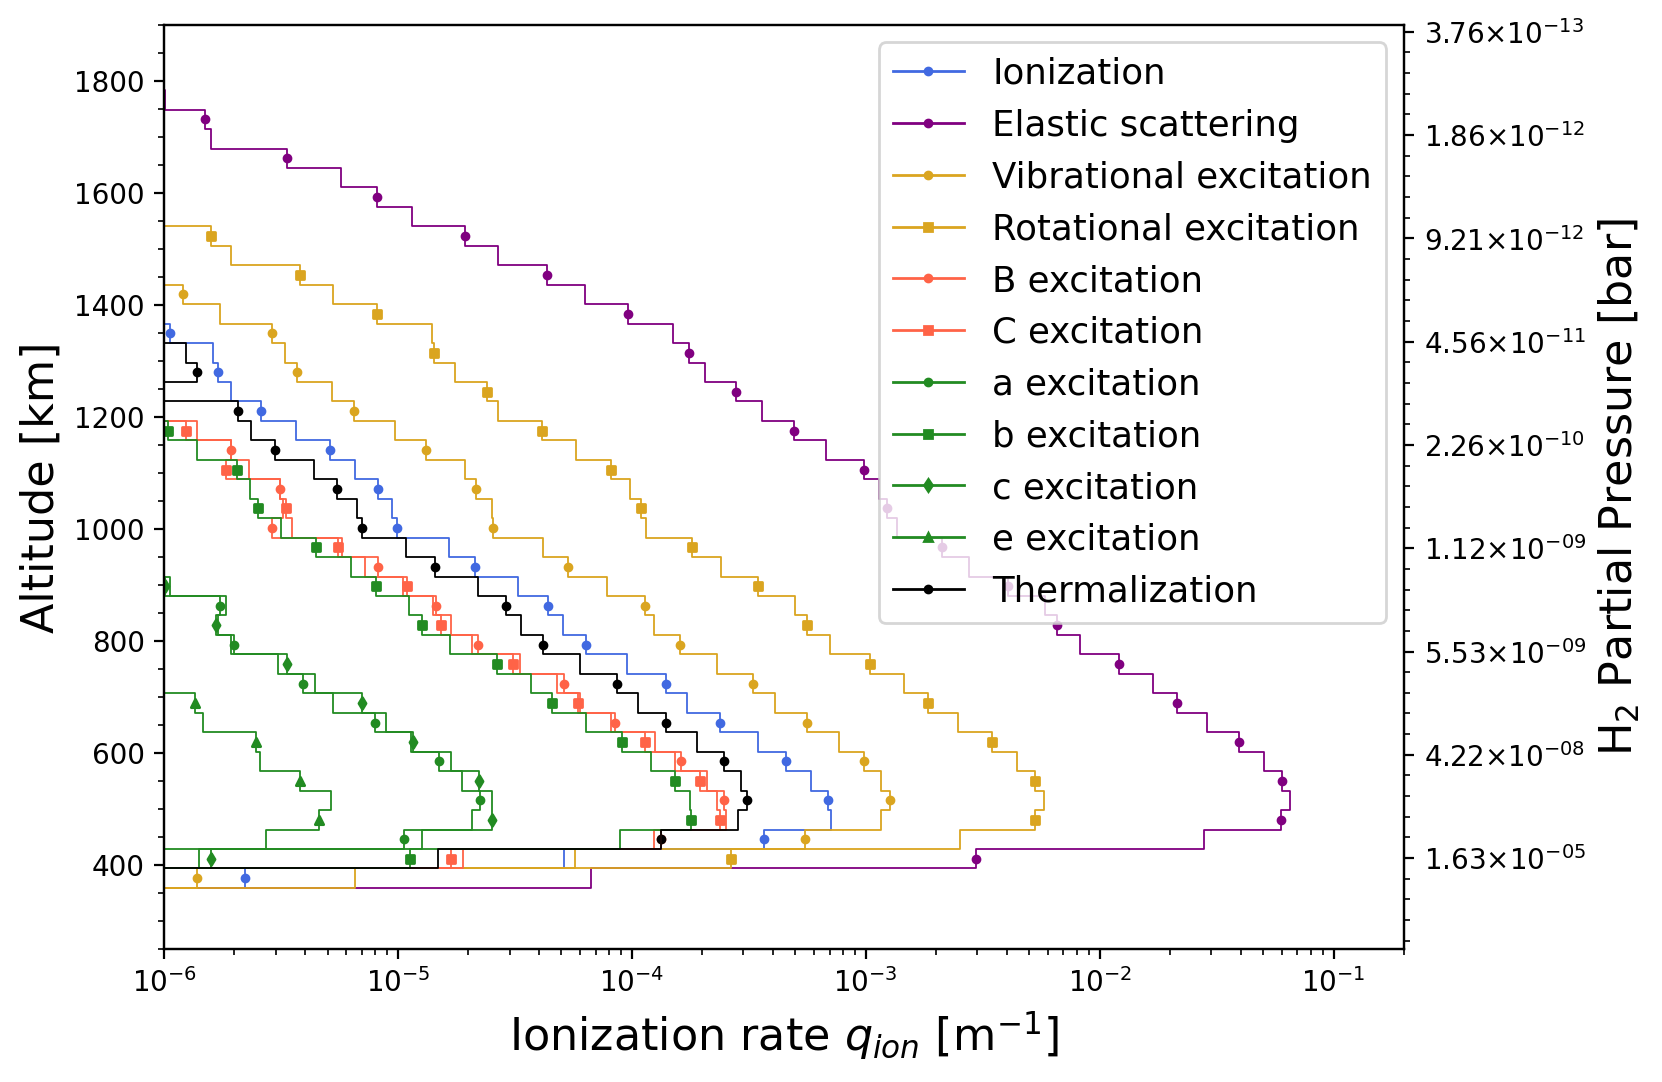

In [11]:
int_types = ['Ionization heights [m]', 'Elastic scattering heights [m]', 'Vibrational excitation heights [m]', 'Rotational excitation heights [m]', 'B excitation heights [m]', 'C excitation heights [m]', 'a excitation heights [m]', 'b excitation heights [m]', 'c excitation heights [m]', 'e excitation heights [m]', 'Exit (energy) heights [m]']
labels = ['Ionization', 'Elastic scattering', 'Vibrational excitation', 'Rotational excitation', 'B excitation', 'C excitation', 'a excitation', 'b excitation', 'c excitation', 'e excitation', 'Thermalization']
plt.figure(figsize = [8,6], dpi = 200)
fs = 16
cmap = mcp.gen_color(cmap="plasma",n=9)
colors = cmap #[cmap[2], cmap[4], cmap[6]]
z_min = 150e3
z_max = 2200e3
nbins = 60
Ne = 1000
sonora_filepath = './Sonora_data'

atm_type = 'Jupiter'
get_n_H2, get_P_H2 = utils.construct_profile_Jupiter(atm_type, z_max, sonora_filepath)
alpha = 0.65
E = 10 # keV

#colors = ['C0','C1','C2','C3','C4','C6','C7','C8','C9','C10','C11','C12']
colors = ['royalblue', 'purple', 'goldenrod', 'goldenrod', 'tomato', 'tomato', 'forestgreen', 'forestgreen', 'forestgreen', 'forestgreen', 'k']
alphas = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]#[1, 1, 1, 0.8, 1, 0.8, 1, 0.8, 0.6, 0.4, 0.8 ]
markers = ['.', '.', '.', 's', '.', 's', '.', 's', 'd', '^','.']
switch = [1,2,1,2,1,2,1,2,2,2,1]
ms = np.array([5, 5, 5, 3, 5, 3, 5, 3, 3, 3, 5])# * 0.8
lw = 0.65
for i in range(len(int_types)):
   # if int_types[i] == 'Ionization heights [m]':
    int_type = int_types[i]
    z_events = df_10.loc[int_type].dropna()
    bins_arr = np.linspace(z_min, z_max, nbins)
    binwidth = bins_arr[1] - bins_arr[0]
    counts, bins = np.histogram(z_events, bins = bins_arr) # = np.histogram(df.loc[rows[j]], bins = nbins)#, density = norm) 
    counts = counts / Ne
    binwidth = (bins[1]-bins[0])
    bincenters = 0.5*(bins[1:]+bins[:-1]) - binwidth  
    q = counts/binwidth
    plt.step(q, bins[:-1]/1000, where = 'post', color = colors[i], alpha = alphas[i], lw = lw)#, marker = markers[i], markersize = ms[i])
    marker_idxs = (np.abs((np.arange(0,len(bincenters)) % 2 == 0) - (switch[i] % 2))).astype(bool)
    plt.scatter(q[marker_idxs], bincenters[marker_idxs]/1000, color = colors[i], alpha = alphas[i], marker = markers[i], s = ms[i]**2) 
    plt.plot([],[],color = colors[i], alpha = alphas[i], marker = markers[i], markersize = ms[i], label = labels[i], lw = 1)
    #Nion_over_Ne = utils.calc_Nevent_over_Ne(energies[i], in_type)
    #q_param = utils.calc_q(bins[1:], E, z_min, z_max, get_n_H2, int_type)
    #calc_q_ion(bins[1:], energies[i]*u.keV, z_min, z_max, Nion_over_Ne, get_n_H2)
#    plt.plot(q_param, bins[1:]/1e3, ls = 'dashed', alpha = alpha, color = colors[i], alpha = alphas[i])
        
    
ax1 = plt.gca()
ax1.set_xscale('log')
ax1.set_ylabel('Altitude [km]', fontsize = fs)
ytick_locs = ax1.get_yticks() # returns locs in data coords
P = get_P_H2(ytick_locs*1000) / 1e5 # then convert to bars
ax2 = ax1.twinx()
ax2.set_yticks(ytick_locs)
formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
formatted_P = formatting_function(P)
label_P = [P.replace('E',r'$\times 10^{')+'}$' for P in formatted_P]
ax2.set_yticklabels(label_P)
ax2.set_ybound(ax1.get_ybound())
ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax2.minorticks_on()
ax1.set_xlabel(r'Ionization rate $q_{ion}$ [m$^{-1}$]', fontsize = fs)
ax1.minorticks_on()
#ax1.plot([],[], ls = 'solid', color = 'k', label = 'Simulation')
#ax1.plot([],[], ls = 'dashed', alpha = alpha, color = 'k', label = 'Parameterization')
ax1.legend(fontsize = 0.8*fs)#, ncol = 2)
ax1.set_xlim([1e-6, 2e-1])
ax1.set_ylim([250,1900])

#plt.savefig('./paper_plots/compare_events_Jupiter_v3.pdf', format = 'pdf', bbox_inches="tight")    


### Peak as a function of energy

In [13]:
# NO NEED TO RUN THIS CELL AGAIN!!

atm_types = []

results_dir = '/projects/anzu2965/SPI/beam_sim/Run_Outputs/Jupiter_Galileo' 
atm_type = 'Jupiter'
atm_types += [atm_type]
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.37.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_Jupiter_v18_02.27.2025.23.36.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_Jup = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

atm_type = 'T1400_g4.0'
results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_T1400_g4.0_v18_12.16.2024.14.36.h5'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_T1400_g4.0_v18_12.16.2024.14.11.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_T1400_g4.0_v18_12.16.2024.13.28.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_T1400_g4.0_v18_12.16.2024.13.14.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_T1400_g4.0_v18_12.16.2024.13.05.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_T1400_g4.0_v18_12.16.2024.13.02.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_T1400_g4.0_v18_12.16.2024.13.01.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_T1400_g4.0_v18_12.16.2024.13.00.h5'
atm_types += [atm_type]
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1400K_g4 = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

atm_type = 'T900_g4.0'
atm_types += [atm_type]
results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_T900_g4.0_v18_12.18.2024.12.40.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_T900_g4.0_v18_12.18.2024.12.43.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_T900_g4.0_v18_12.18.2024.12.41.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_T900_g4.0_v18_12.18.2024.12.40.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_T900_g4.0_v18_12.18.2024.12.48.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_T900_g4.0_v18_12.18.2024.12.41.h5'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_T900_g4.0_v18_12.18.2024.12.55.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_T900_g4.0_v18_12.18.2024.13.22.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_900K_g4 = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

atm_type = 'T482_g4.7'
atm_types += [atm_type]
results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_T482_g4.7_v18_12.18.2024.10.26.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_T482_g4.7_v18_12.18.2024.10.35.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_T482_g4.7_v18_12.18.2024.10.29.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_T482_g4.7_v18_12.18.2024.10.26.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_T482_g4.7_v18_12.18.2024.10.47.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_T482_g4.7_v18_12.18.2024.10.28.h5'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_T482_g4.7_v18_12.18.2024.11.41.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_T482_g4.7_v18_12.18.2024.11.41.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_T482_g4point7 = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

atm_type = 'T2000_g5.0'
results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_T2000_g5.0_v18_12.18.2024.14.31.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_T2000_g5.0_v18_12.18.2024.14.38.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_T2000_g5.0_v18_12.18.2024.14.35.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_T2000_g5.0_v18_12.18.2024.14.32.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_T2000_g5.0_v18_12.18.2024.15.31.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_T2000_g5.0_v18_12.18.2024.14.33.h5'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_T2000_g5.0_v18_12.18.2024.15.31.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_T2000_g5.0_v18_12.18.2024.15.31.h5'
atm_types += [atm_type]
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_2000K_g5 = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

atm_type = 'T1400_g5.0'
results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_T1400_g5.0_v18_12.18.2024.13.54.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_T1400_g5.0_v18_12.18.2024.14.04.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_T1400_g5.0_v18_12.18.2024.13.57.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_T1400_g5.0_v18_12.18.2024.13.54.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_T1400_g5.0_v18_12.18.2024.14.21.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_T1400_g5.0_v18_12.18.2024.13.55.h5'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_T1400_g5.0_v18_12.18.2024.15.31.h5'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_T1400_g5.0_v18_12.18.2024.15.31.h5'
atm_types += [atm_type]
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1400K_g5 = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]


atm_type = 'T900_g5.0'
atm_types += [atm_type]
results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
results_file_500 = results_dir + '/500.0keV/results_Nsteps=20000Ne=1000E0=500.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.01.h5'
results_file_100 = results_dir + '/100.0keV/results_Nsteps=20000Ne=1000E0=100.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_50 = results_dir + '/50.0keV/results_Nsteps=20000Ne=1000E0=50.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_10 = results_dir + '/10.0keV/results_Nsteps=20000Ne=1000E0=10.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_5 = results_dir + '/5.0keV/results_Nsteps=20000Ne=1000E0=5.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_1 = results_dir + '/1.0keV/results_Nsteps=20000Ne=1000E0=1.0cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_05 = results_dir + '/0.5keV/results_Nsteps=20000Ne=1000E0=0.5cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
results_file_01 = results_dir + '/0.1keV/results_Nsteps=20000Ne=1000E0=0.1cos(theta)=1.0_T900_g5.0_v18_12.13.2024.09.00.h5'
z_ions_500 = pd.read_hdf(results_file_500, 'results').loc['Ionization heights [m]'].dropna()
z_ions_100 = pd.read_hdf(results_file_100, 'results').loc['Ionization heights [m]'].dropna()
z_ions_50 = pd.read_hdf(results_file_50, 'results').loc['Ionization heights [m]'].dropna()
z_ions_10 = pd.read_hdf(results_file_10, 'results').loc['Ionization heights [m]'].dropna()
z_ions_5 = pd.read_hdf(results_file_5, 'results').loc['Ionization heights [m]'].dropna()
z_ions_1 = pd.read_hdf(results_file_1, 'results').loc['Ionization heights [m]'].dropna()
z_ions_05 = pd.read_hdf(results_file_05, 'results').loc['Ionization heights [m]'].dropna()
z_ions_01 = pd.read_hdf(results_file_01, 'results').loc['Ionization heights [m]'].dropna()
z_ions_900K_g5 = [z_ions_500, z_ions_100, z_ions_50, z_ions_10, z_ions_5, z_ions_1, z_ions_05, z_ions_01]

In [17]:
# ------------------------------------------#
# NO NEED TO RUN THIS CELL AGAIN!!
# ------------------------------------------#

# size = [18,6]
# fs = 14
# ms = 6
# cs = 0#6
Nsigma = 3#1
# fig = plt.figure(figsize = size, dpi = 300) # peak height vs e0
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122)
sonora_filepath = './Sonora_data'
stop_height_pcntle = 0.99 # not used, just to get function to work

energies = [500.0, 100.0, 50.0, 10.0, 5.0, 1.0, 0.5, 0.1]
Ntot = 1000
n_energies = len(energies)
z_ions_list = [z_ions_Jup, z_ions_1400K_g4, z_ions_900K_g4, z_ions_T482_g4point7, z_ions_2000K_g5, z_ions_1400K_g5, z_ions_900K_g5]
labels = ['Jupiter', 'T=1400K, log(g)=4.0', 'T=900K, log(g)=4.0', 'T=482K, log(g)=4.7', 'T=2000K, log(g)=5.0', 'T=1400K, log(g)=5.0', 'T=900K, log(g)=5.0']
n_atm_types = len(atm_types)
z_peak_err_arr_lists = []
z_peak_mean_arr_lists = []
P_peak_err_arr_lists = []
P_peak_mean_arr_lists = []        
N_peak_err_arr_lists = []
N_peak_mean_arr_lists = []

for i in [1]:#range(n_atm_types):
    atm_type = atm_types[i]
    print()
    print(atm_type, ':')

    if atm_type == 'Jupiter':
        z_max = 2000e3
        z_min = 100e3
        RoverR0_min = 1e-6
        RoverR0_max = 5e0
        get_n_H2, get_P_H2 = utils.construct_profile_Jupiter(atm_type, z_max, sonora_filepath)
        g = 24.79 # m/s^2
#     elif atm_type == 'T1400_g4.0':
#         z_max = 486.71e3
#         z_min = 100e3
#         get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
#         g = 100 # m/s^2
#     elif atm_type == 'T900_g5.0':
#         z_max = 23.75e3
#         z_min = 11.5e3
#         get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
#         RoverR0_min = 1e-6
#         RoverR0_max = 5e0
#         g = 1000 # m/s^2
    elif atm_type == 'T1400_g4.0':
        z_max = 755.560e3
        z_min = 250e3
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
        plot_zmin = 250e3
        RoverR0_min = 1e-6
        RoverR0_max = 1e0
    elif atm_type == 'T900_g5.0':
        z_max = 37.612e3
        z_min = 10e3
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
        plot_zmin = 10e3
        RoverR0_min = 1e-6
        RoverR0_max = 1e0
    elif atm_type == 'T1400_g5.0':
        z_max = 71.970e3
        z_min = 15e3 
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
        plot_zmin = z_min
        RoverR0_min = 1e-6
        RoverR0_max = 1e0
    elif atm_type == 'T900_g4.0':
        z_max = 398.090e3
        z_min = 140e3 
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
        plot_zmin = z_min
        RoverR0_min = 1e-6
        RoverR0_max = 1e0
    elif atm_type == 'T482_g4.7':
        z_max = 38.942e3 * 1.2
        z_min =  10e3 #???
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
        plot_zmin = z_min
        RoverR0_min = 1e-6
        RoverR0_max = 1e0
    elif atm_type == 'T2000_g5.0':
        z_max = 92.236e3
        z_min =  25e3 
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
        plot_zmin = z_min
        RoverR0_min = 1e-6
        RoverR0_max = 1e0
    else:
         raise ValueError('atm_type must be one of implemented profiles.')
    nbins = 80
    bins_arr = np.linspace(z_min, z_max, nbins)
    n_energies = len(energies)
    #energies = np.zeros([n_energies])*np.nan
    z_peak_err_arr = np.zeros([n_energies])*np.nan
    z_peak_mean_arr = np.zeros([n_energies])*np.nan
    P_peak_err_arr = np.zeros([n_energies])*np.nan
    P_peak_mean_arr = np.zeros([n_energies])*np.nan        
    N_peak_err_arr = np.zeros([n_energies])*np.nan
    N_peak_mean_arr = np.zeros([n_energies])*np.nan
    for k in range(len(energies)):
        print(' ' + str(energies[k]) + ' keV')
        #try:
        #df = pd.read_hdf(file_path + '/' + filenames[k], 'results') 
        z_ions = z_ions_list[i][k] # i --> object, k --> energy #df.loc['Ionization heights [m]'].dropna()
        nfolds = 100
        bins_sd, z_peak_sd, z_peak_mean, P_peak_sd, P_peak_mean, RoverR0_peak_sd, RoverR0_peak_mean, R_peak_sd, R_peak_mean, R0_sd, R0_mean, stopping_P_sd, stopping_P_mean = utils.get_uncertainties(z_ions, nfolds, bins_arr, Ntot, stop_height_pcntle, get_n_H2, get_P_H2, z_max, atm_type, z_min, z_max)
        z_peak_err = z_peak_sd*Nsigma # use N sigma error bars
        P_peak_err = P_peak_sd*Nsigma # use N sigma error bars
        R_peak_err = R_peak_sd*Nsigma # use N sigma error bars
        z_peak_err_arr[k] = z_peak_err
        z_peak_mean_arr[k] = z_peak_mean
        P_peak_err_arr[k] = P_peak_err
        P_peak_mean_arr[k] = P_peak_mean
        N_peak_err_arr[k] = R_peak_err/mH2
        N_peak_mean_arr[k] = R_peak_mean/mH2
    
    z_peak_err_arr_lists += [z_peak_err_arr]
    z_peak_mean_arr_lists += [z_peak_mean_arr]
    P_peak_err_arr_lists += [P_peak_err_arr]
    P_peak_mean_arr_lists += [P_peak_mean_arr]    
    N_peak_err_arr_lists += [N_peak_err_arr]
    N_peak_mean_arr_lists += [N_peak_mean_arr]   
   

#     # plot peak location height vs e0 for this body
#     ax1.errorbar(energies, z_peak_mean_arr/1000, yerr = z_peak_err_arr/1000, fmt = '.', linewidth = 1, elinewidth = 2, capsize = cs*1.15, markersize = ms*1.15, label = labels[i] + r' peak location, '+str(Nsigma)+r'$\sigma$ errorbars')     

#     # plot peak location pressure/g vs e0 for this body
#     ax2.errorbar(energies, P_peak_mean_arr/1e5/g, yerr = P_peak_err_arr/1e5/g, fmt = '.', linewidth = 1, elinewidth = 2, capsize = cs, markersize = ms, label = labels[i] + r' peak location, '+str(Nsigma)+r'$\sigma$ errorbars') 

                   
# ax1.set_xlabel('Incident electron energy [keV]', fontsize = fs)
# ax1.set_ylabel('Peak height [km]', fontsize = fs)
# ax1.semilogx()
# ax1.semilogy()  
# ax1.legend(framealpha = 1)  
# ax1.minorticks_on()
                   
# ax2.set_xlabel('Incident electron energy [keV]', fontsize = fs)
# ax2.set_ylabel(r'Peak height / g [m$^-2]', fontsize = fs)
# ax2.semilogx()
# ax2.semilogy()  
# ax2.legend(framealpha = 1)  
# ax2.minorticks_on()

 


T1400_g4.0 :
 500.0 keV
calculating uncertainties in histogram bins with:
     100  folds,  3963  per fold, of 396369  total interactions.


/projects/anzu2965/SPI/beam_sim/utils.py:2506: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N0, err = quad(get_n_H2, stopping_height, z_max)
/projects/anzu2965/SPI/beam_sim/utils.py:2506: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  N0, err = quad(get_n_H2, stopping_height, z_max)


 100.0 keV
calculating uncertainties in histogram bins with:
     100  folds,  3099  per fold, of 309908  total interactions.
 50.0 keV
calculating uncertainties in histogram bins with:
     100  folds,  2643  per fold, of 264365  total interactions.
 10.0 keV
calculating uncertainties in histogram bins with:
     100  folds,  1380  per fold, of 138063  total interactions.
 5.0 keV
calculating uncertainties in histogram bins with:
     100  folds,  813  per fold, of 81309  total interactions.
 1.0 keV
calculating uncertainties in histogram bins with:
     100  folds,  184  per fold, of 18428  total interactions.
 0.5 keV
calculating uncertainties in histogram bins with:
     100  folds,  100  per fold, of 10050  total interactions.
 0.1 keV
calculating uncertainties in histogram bins with:
     100  folds,  21  per fold, of 2175  total interactions.


In [7]:
z_peak_err_arr_lists = [np.array([  2099.9386692 ,   3041.66414346,   2737.46098851,  12463.85548477,
        18588.31601176,  57455.31994948,  59211.08438969, 129555.89438334]), np.array([ 2041.85771731,  7720.56464473,  3191.35618666,  3680.72389712,
        8454.07618432,  8097.17245211, 11100.68983971, 23983.30927124]), np.array([ 947.04274141, 1880.31759905, 2250.79823403, 2500.57049827,
       2414.49477142, 4191.57349214, 7360.04328104, 9980.11210816]), np.array([109.21807298, 172.40005886, 232.8600555 , 219.43484244,
       162.51461297, 484.08355809, 555.1752374 , 935.62146415]), np.array([ 302.32713951,  431.43784995,  500.289895  ,  331.42631157,
        398.12224012,  924.50177287, 1622.50252814, 2716.38175026]), np.array([ 299.1864298 ,  279.23120915,  200.30226845,  305.81928451,
        521.29599628,  834.99940437, 1496.24522671, 1841.16687592]), np.array([ 133.02594409,  138.35243534,  115.56403536,  184.16975716,
        198.79459216,  433.08636288,  544.8350842 , 1289.10300992])] #np.array([137.81316829, 141.69042382, 113.432888  , 175.85433079, 238.74865017, 335.71388117,  68.20296858,   0.        ])]
z_peak_mean_arr_lists = [np.array([ 266929.7929793 ,  334386.53865387,  364924.49244924,
        539069.30693069,  679366.03660366, 1062341.73417342,
       1202402.84028403, 1450168.61686169]), np.array([313284.74587459, 363068.17293729, 378582.8330033 , 431703.28976898,
       460350.67854785, 515856.60594059, 539007.50231023, 577270.08712871]), np.array([187031.54014401, 210686.82181218, 220499.61062106, 244959.43927393,
       257905.7540354 , 285102.38463846, 295311.38121812, 313837.12736274]), np.array([13385.37547115, 15668.76547415, 16654.19372737, 19251.62332393,
       20493.96968657, 23546.24058006, 24607.19408821, 26593.40543734]), np.array([29658.50869487, 35551.59380738, 37923.98436244, 43938.37534953,
       47340.5209841 , 54785.63541554, 57442.93339334, 62609.25914191]), np.array([22074.50144014, 26798.58442844, 28614.74176418, 33209.77479748,
       36028.41953195, 42086.24662466, 44397.69369937, 48071.94248425]), np.array([12791.74192619, 15264.47812781, 16177.44975698, 18554.7769577 ,
       19883.15744374, 22891.04010801, 23943.96334833, 25991.12846085])] #np.array([12781.77217722, 15256.65441544, 16181.27887789, 18545.66731673,19894.759976  , 22919.78347835, 23742.26947695, 23750.        ])]
N_peak_err_arr_lists = [np.array([1.35905132e+25, 1.13907888e+25, 1.07864494e+25, 2.65143786e+25,
       2.30409967e+25, 4.72521685e+25, 6.20755036e+25, 1.04826523e+26]), np.array([1.46358737e+25, 3.82251181e+25, 1.91457901e+25, 2.47331685e+25,
       4.27223581e+25, 5.06513898e+25, 6.38599626e+25, 1.29008062e+26]), np.array([1.32694080e+25, 2.07029936e+25, 2.36531886e+25, 2.63670659e+25,
       2.56415347e+25, 4.68525217e+25, 7.04314519e+25, 1.05309564e+26]), np.array([1.75462311e+25, 2.00694546e+25, 2.41970782e+25, 2.23579584e+25,
       2.68232305e+25, 4.58888734e+25, 6.67392221e+25, 1.17307282e+26]), np.array([1.72712272e+25, 1.94441821e+25, 2.24013286e+25, 1.94235920e+25,
       1.86676085e+25, 5.55635790e+25, 6.86272222e+25, 1.21269277e+26]), np.array([2.08237803e+25, 1.64559818e+25, 1.36291815e+25, 1.86097849e+25,
       2.99688094e+25, 4.37981666e+25, 6.88628227e+25, 1.15064023e+26]), np.array([1.85074773e+25, 1.40360499e+25, 1.36223073e+25, 2.40583105e+25,
       2.73429437e+25, 4.50228620e+25, 6.16758173e+25, 1.22953636e+26])]#np.array([1.87563708e+25, 1.54011126e+25, 1.45504190e+25, 2.27251269e+25,2.85277066e+25, 4.18909181e+25, 1.09276605e+25, 0.00000000e+00])]
N_peak_mean_arr_lists = [np.array([1.36990992e+26, 1.02660026e+26, 1.18363333e+26, 1.31877084e+26,
       1.09985471e+26, 1.02672613e+26, 1.01154807e+26, 1.04352154e+26]), np.array([1.49459714e+26, 9.97571219e+25, 1.19923860e+26, 1.15410838e+26,
       1.08413976e+26, 1.13583117e+26, 9.56205951e+25, 1.16470125e+26]), np.array([1.41519384e+26, 1.08362736e+26, 1.06585409e+26, 1.09966349e+26,
       1.09389806e+26, 1.01489903e+26, 9.95935893e+25, 1.10590984e+26]), np.array([1.51932360e+26, 1.14009053e+26, 1.10240076e+26, 9.64215381e+25,
       1.07810711e+26, 9.69237523e+25, 1.03865953e+26, 1.09671234e+26]), np.array([1.44685844e+26, 1.08005175e+26, 1.08523598e+26, 1.12157207e+26,
       1.10678345e+26, 1.10648501e+26, 1.08501502e+26, 1.05373908e+26]), np.array([1.50683482e+26, 1.05952338e+26, 1.03954419e+26, 1.10248481e+26,
       1.09401889e+26, 9.01204956e+25, 9.12230914e+25, 1.13773572e+26]), np.array([1.47962993e+26, 1.01184782e+26, 1.05155421e+26, 1.11742920e+26,
       1.12266209e+26, 1.02232060e+26, 1.00294840e+26, 1.02085707e+26])] #np.array([1.49260244e+26, 1.01743604e+26, 1.04000173e+26, 1.11244833e+26,1.08973317e+26, 6.16325893e+25, 1.21330640e+24, 0.00000000e+00])]
P_peak_err_arr_lists  = [np.array([6.92065006e-02, 6.91382935e-03, 1.87996068e-03, 3.30280162e-04,
       1.35334777e-04, 2.72719552e-05, 1.12375794e-05, 4.88564019e-06]), np.array([3.14941141e-01, 1.20375596e-01, 2.10788771e-02, 1.95979068e-03,
       1.29988344e-03, 1.13045837e-04, 5.51694471e-05, 2.03995969e-05]), np.array([2.64661862e-01, 5.90869331e-02, 2.70998150e-02, 2.70789330e-03,
       7.86796635e-04, 1.15163390e-04, 7.73545589e-05, 1.85346512e-05]), np.array([1.80624896e+00, 2.87315853e-01, 1.45885897e-01, 1.01092932e-02,
       2.58893641e-03, 6.04446903e-04, 2.73711395e-04, 9.26915006e-05]), np.array([3.52993932e+00, 5.84314090e-01, 2.58943792e-01, 1.63734496e-02,
       5.03531390e-03, 9.53398319e-04, 6.64430203e-04, 1.98176567e-04]), np.array([4.58092116e+00, 4.70867090e-01, 1.32798298e-01, 1.93431237e-02,
       8.01902056e-03, 1.04487690e-03, 6.95200723e-04, 1.68848216e-04]), np.array([3.80543498e+00, 4.25205311e-01, 1.50484992e-01, 2.25169264e-02,
       6.47763458e-03, 1.05707382e-03, 5.36911640e-04, 2.21663437e-04])]#np.array([3.96019255e+00, 4.44106501e-01, 1.46422322e-01, 2.20563100e-02,7.51781609e-03, 7.85462858e-04, 8.44340312e-05, 1.30104261e-18])]
P_peak_mean_arr_lists = [np.array([8.20257842e-01, 7.13250456e-02, 3.11678807e-02, 2.98062652e-03,
       9.15327197e-04, 7.55260062e-05, 3.08384192e-05, 6.49639226e-06]), np.array([3.32804381e+00, 2.98729897e-01, 1.35074989e-01, 1.23462235e-02,
       3.57400712e-03, 3.20570787e-04, 1.18085919e-04, 2.33986256e-05]), np.array([3.07134531e+00, 3.21692395e-01, 1.20759811e-01, 1.16944395e-02,
       3.58072532e-03, 3.00162132e-04, 1.20100741e-04, 2.25472504e-05]), np.array([1.64520559e+01, 1.70599195e+00, 6.49879364e-01, 5.46299182e-02,
       1.92092553e-02, 1.48872218e-03, 6.11856986e-04, 1.17843395e-04]), np.array([3.17132797e+01, 3.40323956e+00, 1.34523176e+00, 1.25237016e-01,
       3.74645858e-02, 3.05434225e-03, 1.26004445e-03, 2.27020542e-04]), np.array([3.31686954e+01, 3.28778303e+00, 1.30411285e+00, 1.27426980e-01,
       3.69558609e-02, 2.89964029e-03, 1.11259451e-03, 2.39243643e-04]), np. array([3.22029865e+01, 3.22336445e+00, 1.32600249e+00, 1.26280061e-01,
       3.81306792e-02, 2.93169017e-03, 1.19696791e-03, 2.18835340e-04])]#np.array([3.24899193e+01, 3.24797376e+00, 1.32100356e+00, 1.27414341e-01,3.77796055e-02, 2.85193189e-03, 1.40591351e-03, 1.39638489e-03])]

In [18]:
print(z_peak_err_arr_lists)
print(z_peak_mean_arr_lists)
print(P_peak_err_arr_lists)
print(P_peak_mean_arr_lists)         
print(N_peak_err_arr_lists)
print(N_peak_mean_arr_lists)

[array([ 2041.85771731,  7720.56464473,  3191.35618666,  3680.72389712,
        8454.07618432,  8097.17245211, 11100.68983971, 23983.30927124])]
[array([313284.74587459, 363068.17293729, 378582.8330033 , 431703.28976898,
       460350.67854785, 515856.60594059, 539007.50231023, 577270.08712871])]
[array([3.14941141e-01, 1.20375596e-01, 2.10788771e-02, 1.95979068e-03,
       1.29988344e-03, 1.13045837e-04, 5.51694471e-05, 2.03995969e-05])]
[array([3.32804381e+00, 2.98729897e-01, 1.35074989e-01, 1.23462235e-02,
       3.57400712e-03, 3.20570787e-04, 1.18085919e-04, 2.33986256e-05])]
[array([1.46358737e+25, 3.82251181e+25, 1.91457901e+25, 2.47331685e+25,
       4.27223581e+25, 5.06513898e+25, 6.38599626e+25, 1.29008062e+26])]
[array([1.49459714e+26, 9.97571219e+25, 1.19923860e+26, 1.15410838e+26,
       1.08413976e+26, 1.13583117e+26, 9.56205951e+25, 1.16470125e+26])]


/tmp/ipykernel_3737079/2763991677.py:70: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax1.errorbar(energies, z_peak_mean_arr/1000, yerr = z_peak_err_arr/1000, fmt = '.', linewidth = 1, elinewidth = 1, capsize = cs*1.15, markersize = markersize[i]*1.15, label = labels[i], color = colors[i], marker = markers[i])#+ r' peak location, '+str(Nsigma)+r'$\sigma$ errorbars')
/tmp/ipykernel_3737079/2763991677.py:77: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax2.errorbar(energies, N_peak, yerr = N_err, fmt = '.', linewidth = 1, elinewidth = 1, capsize = cs, markersize = markersize[i], label = labels[i], color = colors[i], marker = markers[i])#+ r' peak location, '+str(Nsigma)+r'$\sigma$ errorbars')
/tmp/ipykernel_3737079/2763991677.py:70: UserWarning: marker is redu

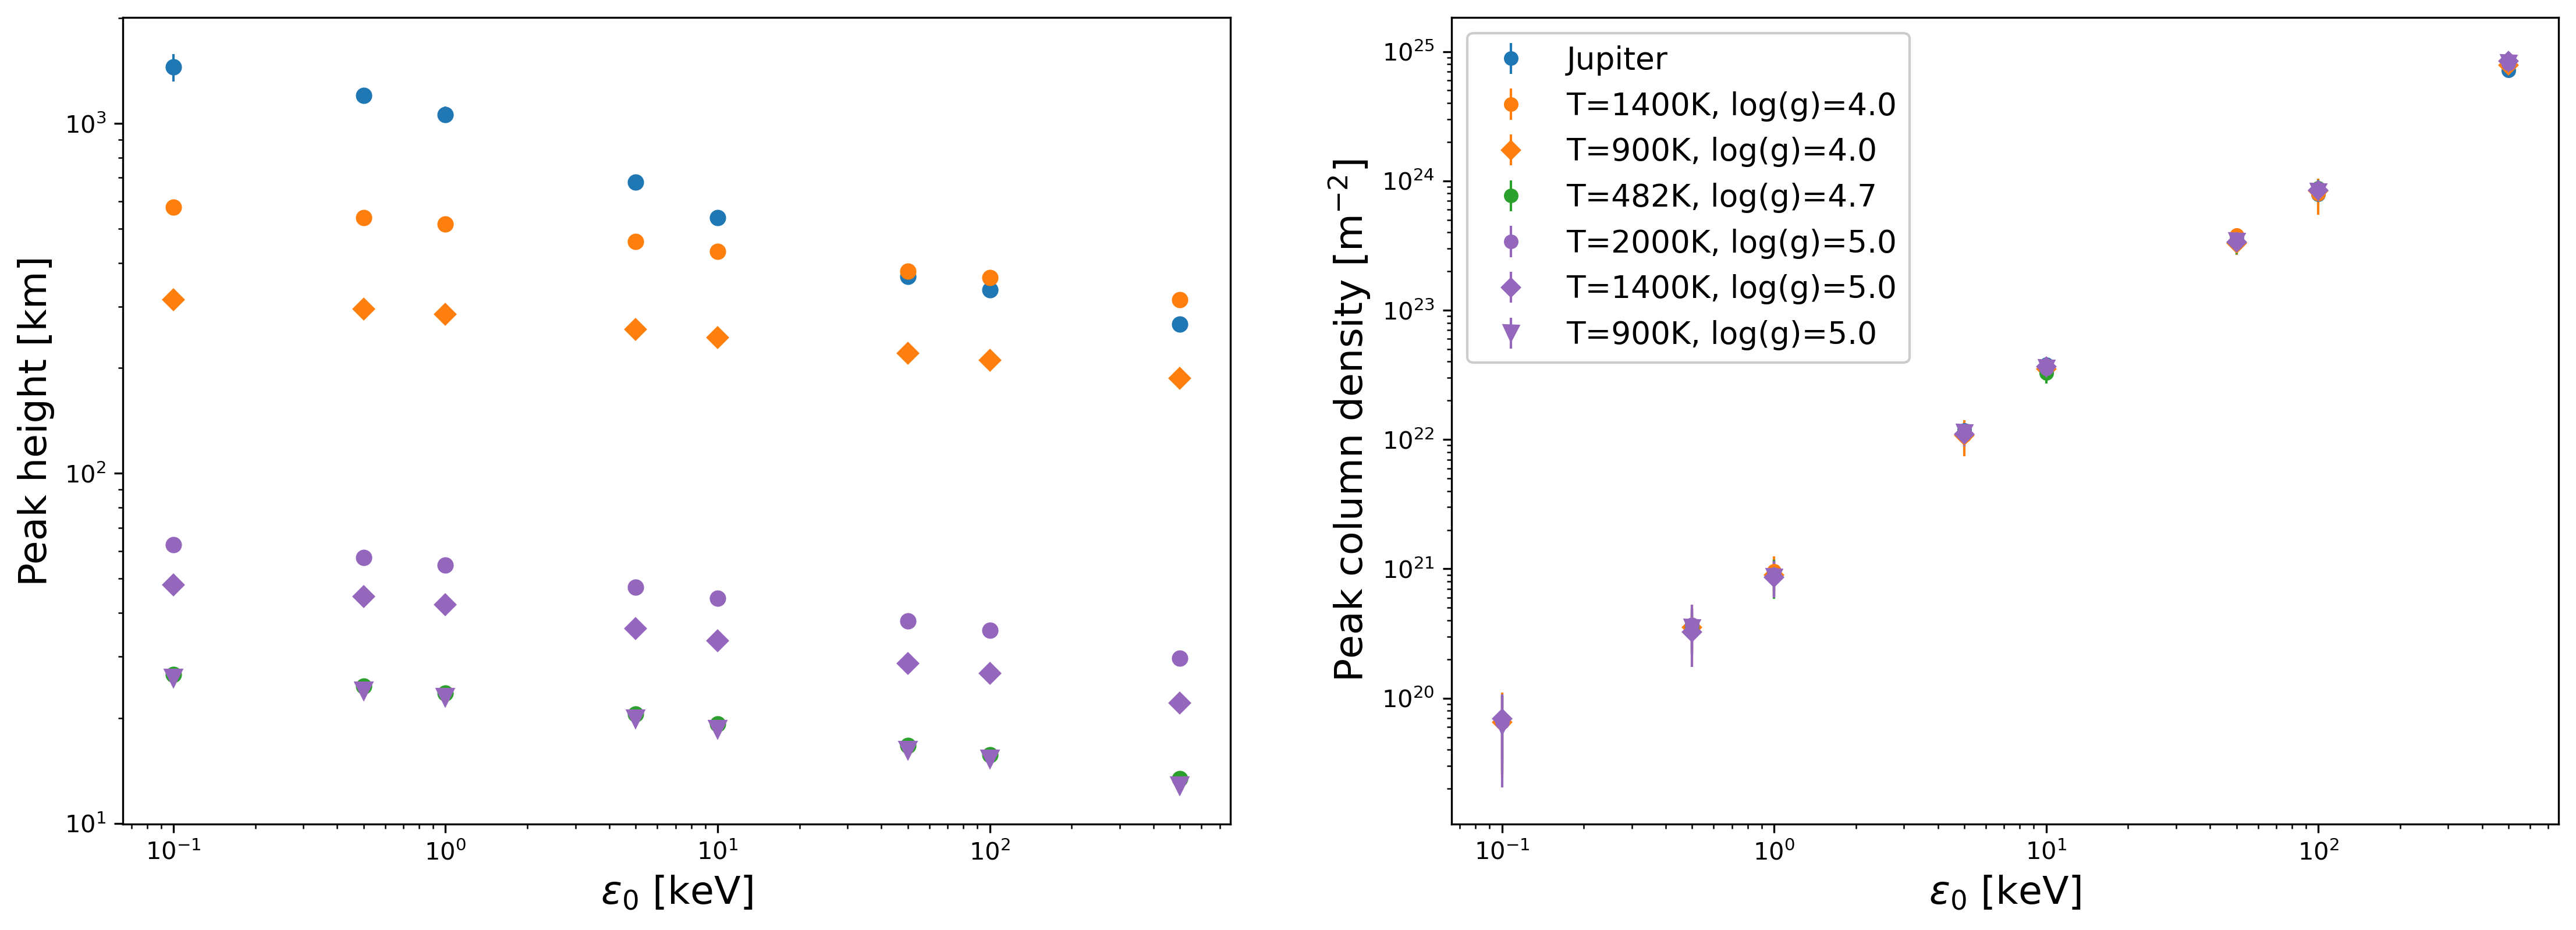

In [49]:
size = [18,6]
fs = 16
ms = 10
cs = 0#6
Nsigma = 3#1
fig = plt.figure(figsize = size, dpi = 300) # peak height vs e0
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
g = [3.4, 4.0, 4.0, 4.7, 5.0, 5.0, 5.0]
atm_types = ['Jupiter', 'T1400_g4.0', 'T900_g4.0', 'T482_g4.7', 'T2000_g5.0', 'T1400_g5.0', 'T900_g5.0']
n_atm_types = len(atm_types)
energies = [500.0, 100.0, 50.0, 10.0, 5.0, 1.0, 0.5, 0.1]
Ntot = 1000
n_energies = len(energies)
#z_ions_list = [z_ions_Jup, z_ions_1400K_g4, z_ions_900K_g4, z_ions_T482_g4point7, z_ions_2000K_g5, z_ions_1400K_g5, z_ions_900K_g5]
labels = ['Jupiter', 'T=1400K, log(g)=4.0', 'T=900K, log(g)=4.0', 'T=482K, log(g)=4.7', 'T=2000K, log(g)=5.0', 'T=1400K, log(g)=5.0', 'T=900K, log(g)=5.0']
colors = ['C0', 'C1', 'C1', 'C2', 'C4', 'C4', 'C4']
markers = ['.', '.', 'D',  '.', '.', 'D', 'v']#, 'h']
markersize = [ms, ms, 0.5*ms, ms, ms, 0.5*ms,0.6*ms]

sonora_filepath = './Sonora_data'
for i in range(n_atm_types):
    atm_type = atm_types[i]
    if atm_type == 'Jupiter':
        z_max = 2000e3
        z_min = 100e3
        get_n_H2, get_P_H2 = utils.construct_profile_Jupiter(atm_type, z_max, sonora_filepath)
#     elif atm_type == 'T1400_g4.0':
#         z_max = 486.71e3
#         z_min = 100e3
#         get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
#     elif atm_type == 'T900_g5.0':
#         z_max = 23.75e3
#         z_min = 11.5e3
#         get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
    elif atm_type == 'T1400_g4.0':
        z_max = 755.560e3
        z_min = 250e3
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
    elif atm_type == 'T900_g5.0':
        z_max = 37.612e3
        z_min = 10e3
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
    elif atm_type == 'T1400_g5.0':
        z_max = 71.970e3
        z_min = 15e3 
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
    elif atm_type == 'T900_g4.0':
        z_max = 398.090e3
        z_min = 140e3 
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
    elif atm_type == 'T482_g4.7':
        z_max = 38.942e3 * 1.2
        z_min =  10e3 #???
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
    elif atm_type == 'T2000_g5.0':
        z_max = 92.236e3
        z_min =  25e3 
        get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
    else:
         raise ValueError('atm_type must be one of implemented profiles.')
    #for k in range(len(energies)):
    z_peak_mean_arr = z_peak_mean_arr_lists[i]
    z_peak_err_arr = z_peak_err_arr_lists[i]
    P_peak_mean_arr = P_peak_mean_arr_lists[i]
    P_peak_err_arr = P_peak_err_arr_lists[i]
    N_peak_mean_arr = N_peak_mean_arr_lists[i]
    N_peak_err_arr = N_peak_err_arr_lists[i]
    # plot peak location height vs e0 for this body
    ax1.errorbar(energies, z_peak_mean_arr/1000, yerr = z_peak_err_arr/1000, fmt = '.', linewidth = 1, elinewidth = 1, capsize = cs*1.15, markersize = markersize[i]*1.15, label = labels[i], color = colors[i], marker = markers[i])#+ r' peak location, '+str(Nsigma)+r'$\sigma$ errorbars')     

    # plot peak location pressure/g vs e0 for this body
    z_grid = np.linspace(0,z_max,10000)
    R_grid = utils.construct_R_grid(z_grid, z_min, z_max, get_n_H2)
    N_peak = utils.get_column_density(z_peak_mean_arr, z_grid, R_grid)/mH2
    N_err = utils.get_column_density(z_peak_mean_arr, z_grid, R_grid)/mH2 - utils.get_column_density(z_peak_mean_arr+z_peak_err_arr, z_grid, R_grid)/mH2 
    ax2.errorbar(energies, N_peak, yerr = N_err, fmt = '.', linewidth = 1, elinewidth = 1, capsize = cs, markersize = markersize[i], label = labels[i], color = colors[i], marker = markers[i])#+ r' peak location, '+str(Nsigma)+r'$\sigma$ errorbars') 
    #ax2.errorbar(energies, N_peak_mean_arr, yerr = N_peak_err_arr, fmt = '.', linewidth = 1, elinewidth = 1, capsize = cs, markersize = ms, label = labels[i])#+ r' peak location, '+str(Nsigma)+r'$\sigma$ errorbars') 
    #ax2.errorbar(energies, P_peak_mean_arr/1e5/g[i], yerr = P_peak_err_arr/1e5/g[i], fmt = '.', linewidth = 1, elinewidth = 1, capsize = cs, markersize = ms, label = labels[i])#+ r' peak location, '+str(Nsigma)+r'$\sigma$ errorbars') 

                   
ax1.set_xlabel(r'$\varepsilon_0$ [keV]', fontsize = fs)
ax1.set_ylabel('Peak height [km]', fontsize = fs)
ax1.semilogx()
ax1.semilogy()  
#ax1.legend(framealpha = 1)  
ax1.minorticks_on()
                   
ax2.set_xlabel(r'$\varepsilon_0$ [keV]', fontsize = fs)
#ax2.set_ylabel(r'Peak height / g [m$^{-2}$]', fontsize = fs)
ax2.set_ylabel(r'Peak column density [m$^{-2}$]', fontsize = fs)
ax2.semilogx()
ax2.semilogy()  
ax2.legend(framealpha = 1, fontsize = 0.8*fs)  
ax2.minorticks_on()

plt.savefig('./paper_plots/peak_z_and_N_v4.pdf', format = 'pdf', bbox_inches="tight")

### Residuals in peak loc and value, parameterization to simulation

In [48]:
importlib.reload(utils)

/projects/anzu2965/SPI/beam_sim/utils.py:2951: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', sep='\s+', skiprows = 0)
/projects/anzu2965/SPI/beam_sim/utils.py:2958: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', sep='\s+', skiprows = 0)
/projects/anzu2965/SPI/beam_sim/utils.py:2965: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', sep='\s+', skiprows = 0)
/projects/anzu2965/SPI/beam_sim/utils.py:2972: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', sep='\s+', skiprows = 0)
/projects/anzu2965/SPI/beam_sim/utils.py:2993: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', 

<module 'utils' from '/projects/anzu2965/SPI/beam_sim/utils.py'>

In [41]:
# try to calculate paramterization values of peak loc and val over more energies for smoother curve
sonora_filepath = './Sonora_data'
E = np.logspace(-1,3,50)
param_peak_locs = np.zeros(len(E))*np.nan
param_peak_vals = np.zeros(len(E))*np.nan
z_max = 37.612e3
z_min = 10e3
atm_type = 'T900_g5.0'
get_n_H2, get_P_H2 = utils.construct_profiles(atm_type, z_max, sonora_filepath)
for i in range(len(E)):
    z = np.linspace(z_min, z_max, 500)
    #q_param = utils.calc_q(z, E[i], z_min, z_max, get_n_H2, 'Ionization heights [m]')
    Nion_over_Ne = Nion_over_Ne_fit(E[i])
    q_param = calc_q_ion(z, E[i]*u.keV, z_min, z_max, Nion_over_Ne, get_n_H2).value
    param_peak_locs[i] = z[q_param == np.nanmax(q_param)][0]
    param_peak_vals[i] = np.nanmax(q_param)
 

/tmp/ipykernel_3737079/3337254028.py:34: RuntimeWarning: divide by zero encountered in log10
  pdf = stats.moyal.pdf(-np.log10(N.value), mu, sigma)*(N*np.log(10))**(-1)
/projects/anzu2965/software/anaconda/envs/pymc_env/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in reciprocal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/projects/anzu2965/software/anaconda/envs/pymc_env/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[]

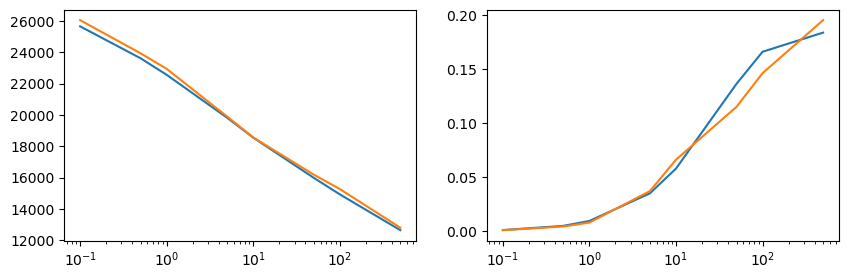

In [16]:
plt.figure(figsize = [10,3])
plt.subplot(121)
#plt.plot(E, param_peak_locs) 
plt.plot(energies, parameterization_peak_locs); plt.plot(energies, kde_peak_locs); plt.semilogx()
plt.subplot(122)
#plt.plot(E, param_peak_vals)
plt.plot(energies, parameterization_peak_vals); plt.plot(energies, kde_peak_vals);  plt.semilogx()#; plt.semilogy()

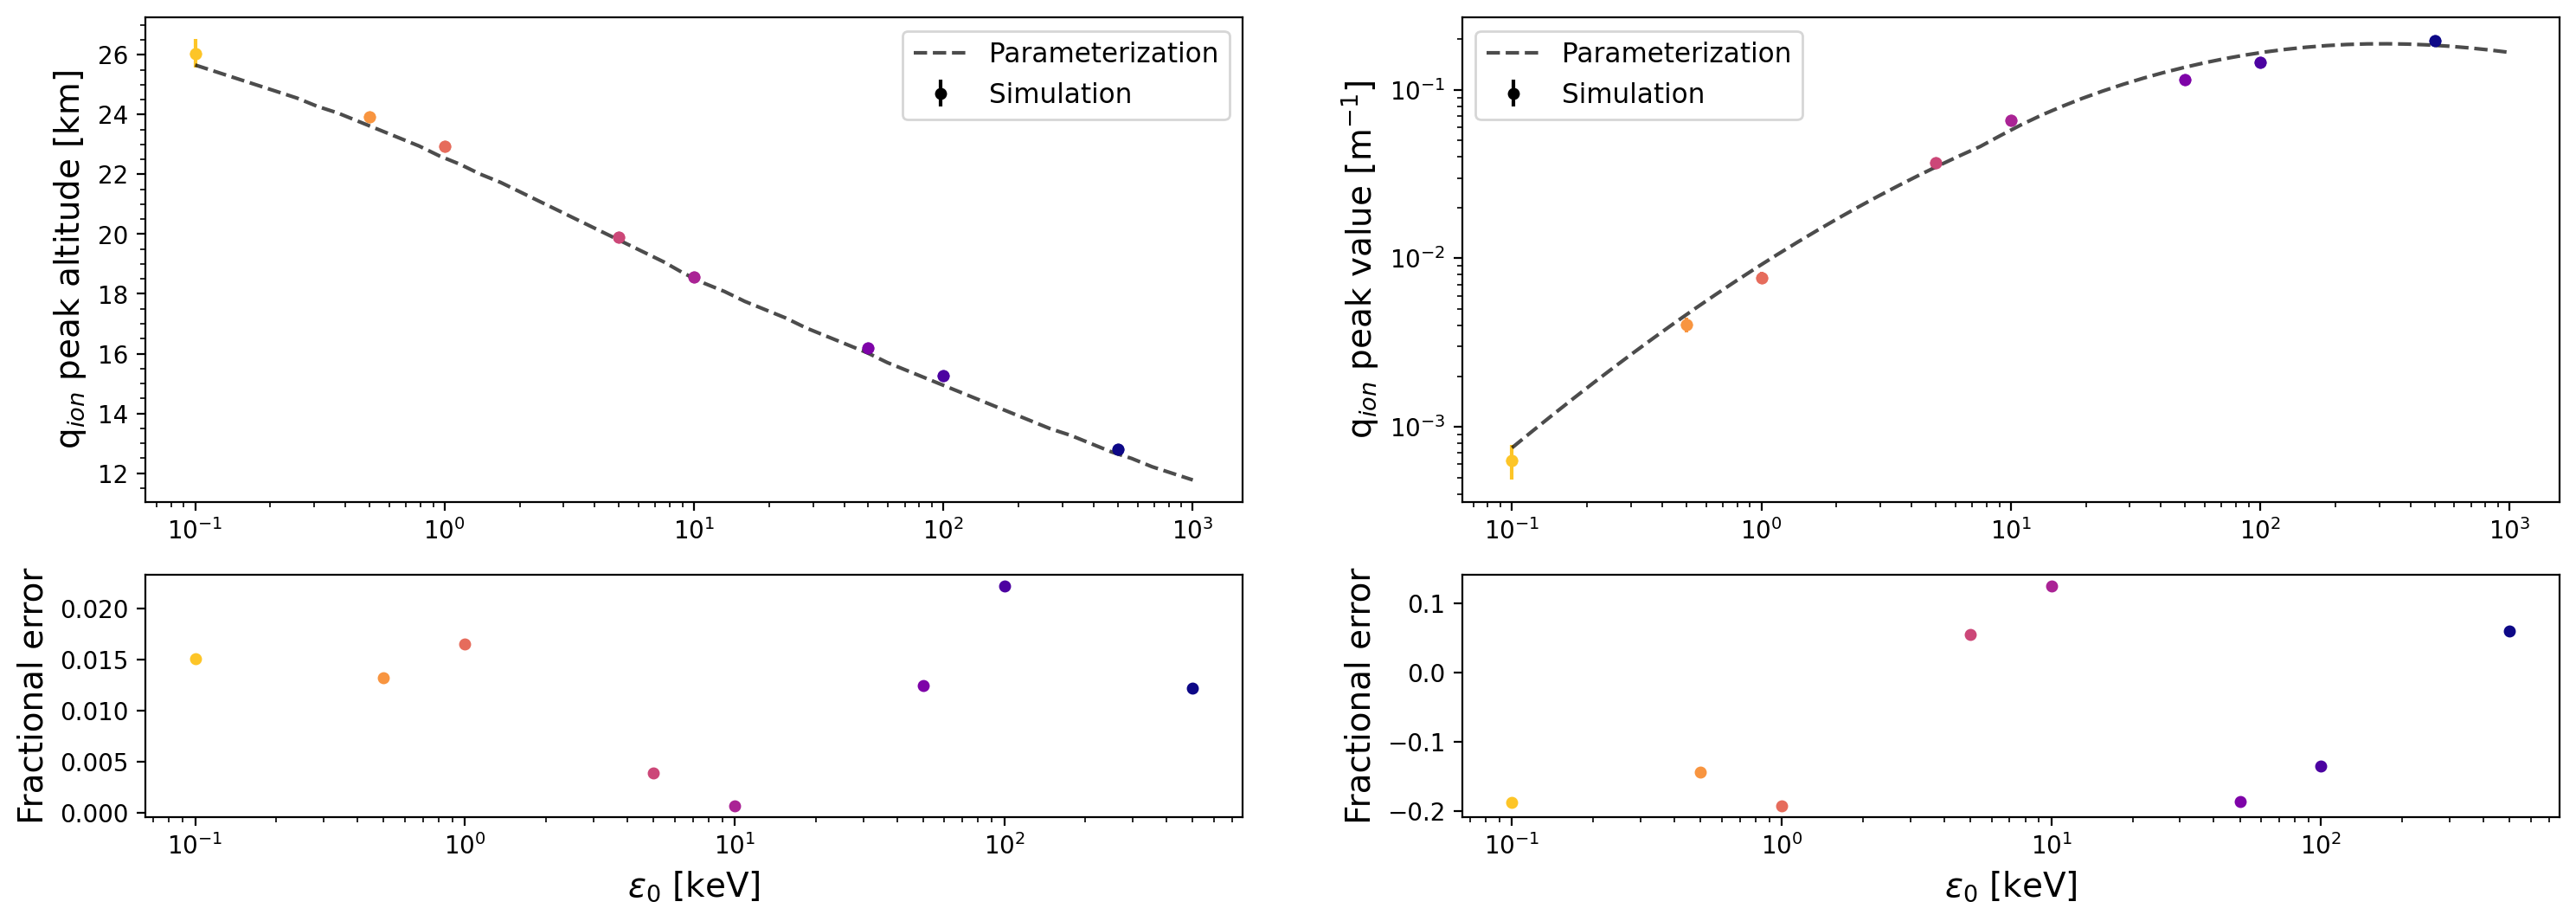

In [43]:
# plot residuals in peak locations
# values from qion and Qion notebook
kde_peak_locs = np.array([12793.99121512151, 15263.097279327932, 16180.653622162215, 18557.59293849385, 19888.511699169918, 22935.14451445144, 23926.279648764885, 26043.620058005803])
kde_peak_vals = np.array([0.19547931995328144, 0.14634745359641343, 0.11506193702538993, 0.06602103907820409, 0.03688094000406436, 0.007704879016145401, 0.0040525682670531265, 0.0006323671857246399])
parameterization_peak_locs = np.array([12637.642642642642, 14923.599599599598, 15978.656656656656, 18545.962162162163, 19812.03063063063, 22555.178978978976, 23610.236036036036, 25650.013013013013])
parameterization_peak_vals = np.array([0.18394058487655754, 0.1661853717903246, 0.1364202934985215, 0.05777576939248651, 0.03484910860186318, 0.00918988747347039, 0.004633081466262057, 0.000751248331805831])
kde_peak_locs_sd = np.array([44.98339200323692, 47.27702818276139, 41.20997239604101, 53.41400946395809, 68.02499552329695, 130.06903353940993, 173.29846312513038, 476.86495741815503])
kde_peak_vals_sd = np.array([0.004103210115056479, 0.0034923193788706885, 0.0030186836637223, 0.0018879372910954016, 0.00152397719500087, 0.0005691121045141118, 0.0004186636602392091, 0.0001484902535496595])

energies = np.array([500, 100, 50, 10, 5, 1, 0.5, 0.1])
E = np.logspace(-1,3,50)

fs = 14
#plt.figure(figsize = [18,6], dpi = 200)
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 0.5]},figsize = [18,6], dpi = 200)
colors = ['k', 'k']
symbols = ['.', 's']
markersizes = [8,3]
alpha = 1.0
cmap = mcp.gen_color(cmap="plasma",n=9)
#fig.tight_layout()

plt.subplot(221)
for i in range(len(energies)):
    plt.plot(energies[i], np.array(kde_peak_locs)[i]/1e3, markersize = markersizes[0],  marker = symbols[0], color =  cmap[i], linestyle = 'none')#, label = 'Simulation') 
    plt.errorbar(energies[i], np.array(kde_peak_locs)[i]/1e3, yerr = np.array(kde_peak_locs_sd)[i]/1e3, markersize = markersizes[0],  marker = symbols[0], color =  cmap[i], alpha = alpha, linestyle = 'none')#, label = 'Simulation') 
#plt.plot(energies, np.array(parameterization_peak_locs)/1e3, symbols[1], markersize = markersizes[1], color = colors[1], label = 'Parameterization')
plt.plot(E, param_peak_locs/1e3, ls ='dashed', alpha = 0.7, color = colors[1], label = 'Parameterization')
plt.semilogx()
#plt.xlabel('Energy [keV]',fontsize = fs)
plt.ylabel(r'q$_{ion}$ peak altitude [km]',fontsize = fs)
plt.errorbar([], [], yerr = [], markersize = markersizes[0],  marker = symbols[0], color = colors[0], linestyle = 'none', label = 'Simulation') 
plt.legend(fontsize = 0.8*fs)
plt.gca().minorticks_on()

plt.subplot(222)
for i in range(len(energies)):
    plt.plot(energies[i], np.array(kde_peak_vals)[i], markersize = markersizes[0],  marker = symbols[0], color = cmap[i], linestyle = 'none')#, label = 'Simulation') 
    plt.errorbar(energies[i], np.array(kde_peak_vals)[i], yerr = np.array(kde_peak_vals_sd)[i], markersize = markersizes[0], marker = symbols[0], color = cmap[i], alpha = alpha, linestyle = 'none')#, label = 'Simulation') 
#plt.plot(energies, np.array(parameterization_peak_vals), symbols[1], markersize = markersizes[1], color = colors[1], label = 'Parameterization')
plt.plot(E, param_peak_vals, ls ='dashed', alpha = 0.7, color = colors[1], label = 'Parameterization')
plt.semilogx()
plt.semilogy()
#plt.xlabel('Energy [keV]',fontsize = fs)
plt.ylabel(r'q$_{ion}$ peak value [m$^{-1}$]',fontsize = fs)
plt.errorbar([], [], yerr = [], markersize = markersizes[0],  marker = symbols[0], color = colors[0], linestyle = 'none', label = 'Simulation') 
plt.legend(fontsize = 0.8*fs)

plt.subplot(223)
for i in range(len(energies)):
    plt.plot(energies[i], (np.array(kde_peak_locs)[i] - parameterization_peak_locs[i])/np.array(kde_peak_locs)[i], markersize = markersizes[0],  marker = symbols[0], color =  cmap[i], linestyle = 'none')#, label = 'Simulation') 
#plt.plot(energies, np.array(parameterization_peak_locs)/1e3, symbols[1], markersize = markersizes[1], color = colors[1], label = 'Parameterization')
plt.semilogx()
plt.xlabel(r'$\varepsilon_0$ [keV]',fontsize = fs)
plt.ylabel('Fractional error',fontsize = fs)

plt.subplot(224)
for i in range(len(energies)):
    plt.plot(energies[i], (np.array(kde_peak_vals)[i] - parameterization_peak_vals[i])/np.array(kde_peak_vals)[i], markersize = markersizes[0],  marker = symbols[0], color =  cmap[i], linestyle = 'none')#, label = 'Simulation') 
#plt.plot(energies, np.array(parameterization_peak_locs)/1e3, symbols[1], markersize = markersizes[1], color = colors[1], label = 'Parameterization')
plt.semilogx()
plt.xlabel(r'$\varepsilon_0$ [keV]',fontsize = fs)
plt.ylabel('Fractional error',fontsize = fs)

plt.savefig('./paper_plots/900K_g5_peak_vals_and_locs_residuals_v2.pdf', format = 'pdf', bbox_inches="tight")

# plt.figure(figsize = [15,5], dpi = 150)
# plt.subplot(121)
# plt.scatter(np.array(kde_peak_locs)/1e3, (np.array(kde_peak_locs) - np.array(parameterization_peak_locs))/np.array(kde_peak_locs), c = np.log10(energies))
# plt.xlabel('qion peak location from KDE [km]')
# plt.ylabel('Fractional error KDE to parameterization peak location')
# plt.colorbar(label = 'log10(Energy [keV])')
# plt.subplot(122)
# plt.scatter(np.array(kde_peak_vals), (np.array(kde_peak_vals) - np.array(parameterization_peak_vals))/np.array(kde_peak_vals), c = np.log10(energies))
# plt.xlabel('qion peak value from KDE [#/m/incident e-]')
# plt.ylabel('Fractional error KDE to parameterization peak value')
# plt.colorbar(label = 'log10(Energy [keV])')

# plt.figure(figsize = [15,5], dpi = 150)
# plt.subplot(121)
# plt.scatter(np.array(kde_peak_locs)/1e3,  np.array(parameterization_peak_locs)/1e3, c = np.log10(energies))
# plt.plot(np.array(kde_peak_locs)/1e3, np.array(kde_peak_locs)/1e3, ls='dashed', color='k', alpha = 0.5)
# plt.xlabel('qion peak location from KDE [km]')
# plt.ylabel('qion peak loation from parameterization')
# plt.colorbar(label = 'log10(Energy [keV])')
# plt.subplot(122)
# plt.scatter(np.array(kde_peak_vals),  np.array(parameterization_peak_vals), c = np.log10(energies))
# plt.plot(np.array(kde_peak_vals), np.array(kde_peak_vals), ls='dashed', color='k', alpha = 0.5)
# plt.xlabel('qion peak value from KDE [#/m/incident e-]')
# plt.ylabel('qion peak value from parameterization [#/m/incident e-]')
# plt.colorbar(label = 'log10(Energy [keV])')



### Qion and energy depositon rate Tdwarf

In [4]:
# atm_type = 'T900_g5.0'
# # results_dir = '/scratch/alpine/anzu2965/'+atm_type+'_isothermally_extended_new_density'
# # energies = np.array([500, 100, 50, 10, 5, 1, 0.5, 0.1])
# sonora_filepath = './Sonora_data'
# z_max = 37.612e3 * 1.2
# z_min = 10e3
# get_n_H2, get_pressure = utils.construct_profiles(atm_type, z_max, sonora_filepath)

# def calc_Q(calc_Fe, zi, E_keV, get_n_H2, event_type):
#     # q_ion function [/m]
#     # Fe function [e-/m^2/s/keV]
#     # zi [m]
#     # get_n_H2 [/m^3]
#     # q = calc_q_ion(zi, E_eV, z_min, z_max, Nion_over_Ne, get_n_H2).to(u.cm**-1)
#     q = utils.calc_q(zi, E_keV, z_min, z_max, get_n_H2, event_type) # events/m
#     F = calc_Fe(E_keV) # with functions as below, returns electrons/m^2/keV/s
#     return trapezoid(q*F, E_keV).value # events/m^3/s

# def F_high_energy(E_keV, A = 1e10 * (u.cm**(-2)/u.s), e0 = (100*u.keV).to(u.eV)):
#     E_eV = ((E_keV * 1e3) * u.eV).value
#     e0 = e0.value
#     F = A*E_eV/e0**2 * np.exp(-E_eV/e0) # electrons/cm^2/s/eV
#     F_SI_keV = F * 1e4 * 1e3 # cm^-2 --> m^-2, and eV^-2 --> keV for consistancy with other functions
#     return F_SI_keV

# def F_power_law(E_keV):
#     E_eV = (E_keV * 1e3) * u.eV
#     A = 1e9 * (u.cm**(-2)/u.s)
#     B = 0.5
#     e1 = 100 * u.eV 
#     e2 = (200 * u.keV).to(u.eV)
#     scale = B * e1**B * e2**B/(e2**B - e1**B)
#     idxs = (E_eV < e1) | (E_eV > e2)
#     F = A*E_eV**(-B) * (scale/E_eV)
#     F[idxs] = 0
#     F = F.to((u.cm**(-2)/ (u.s * u.eV)))
#     F_SI_keV = F * 1e4 * 1e3 # cm^-2 --> m^-2, and eV^-2 --> keV for consistancy with other functions
#     return F_SI_keV
 
# def F_triple_maxwellian(E_keV):
#     E_eV = (E_keV * 1e3) * u.eV
#     e1 = (0.1*u.keV).to(u.eV)
#     e2 = (3*u.keV).to(u.eV)
#     e3 = (22*u.keV).to(u.eV)
#     A1 = ((0.5 * u.erg/ (u.cm**2 * u.s))/e1).value
#     A2 = ((10 * u.erg/ (u.cm**2 * u.s))/e2).value
#     A3 = ((100 * u.erg/ (u.cm**2 * u.s))/e3).value
#     F =  (A1*F_high_energy(E_eV, 1, e1) + A2*F_high_energy(E_eV, 1, e2) + A3*F_high_energy(E_eV, 1, e3)).to((u.cm**(-2)/ (u.s * u.eV)))
#     F_SI_keV = F * 1e4 * 1e3 # cm^-2 --> m^-2, and eV^-2 --> keV for consistancy with other functions
#     return F_SI_keV

In [2]:
# def calc_Q(calc_Fe, zi, E_eV, get_n_H2, event_type):
#     # q_ion and Fe are functions
#     #E_eV = np.logspace(1, 6.4, 1000)*u.eV # eV
#    # E = E_eV.to(u.keV).value
#     q = calc_q_ion(zi, E_eV*u.eV, z_min, z_max, Nion_over_Ne, get_n_H2).to(u.cm**-1)
#     #q = utils.calc_q(zi, E_keV, z_min, z_max, get_n_H2, event_type) * u.m**-1
#     F = calc_Fe(E_eV*u.eV)
#     return trapezoid(q*F, E_eV*u.eV) #* (u.cm**-3 * u.s**-1) # e-/cm^2/s
# def calc_q_ion(z, E, z_min, z_max, Nion_over_Ne, get_n_H2):
#     # z in m
#     # E in eV
#     E = E.to(u.keV)
#     mu =  -0.59175*np.log(E.value) + -0.031*np.log(E.value)**2 + 0.004*np.log(E.value)**3 + -21.06433
#     sigma = -0.00563*np.log(E.value) + 0.00375*np.log(E.value)**2 + -0.00053*np.log(E.value)**3 + 0.20097
#     z_grid = np.linspace(z_min,z_max,10000) * u.m
#     R_grid = utils.construct_R_grid(z_grid.value, z_min, z_max, get_n_H2)
#     N = utils.get_column_density(z, z_grid.value, R_grid)/mH2 * (u.m)**(-2) # #/m^2
#     pdf = stats.moyal.pdf(-np.log10(N.value), mu, sigma)*(N*np.log(10))**(-1) 
#     nH2 = get_n_H2(z) * (u.m**-3)
#     q_ion = pdf*nH2 * (Nion_over_Ne)
#    # print(q_ion)
#     return q_ion# * (u.m**-1) 

# def Nion_over_Ne_fit(E_keV):
#     # E in keV
#     a = 0.913336
#     b = -0.05016688
#     c = -0.00357498
#     d = 3.02340139
#     logE = np.log(E_keV)
#     return np.exp(a*logE + + b*logE**2 + c*logE**3 + d) 

atm_type = 'T900_g5.0'
sonora_filepath = './Sonora_data'
z_max = 37.612e3 * 1.2
z_min = 10e3
get_n_H2, get_pressure = utils.construct_profiles(atm_type, z_max, sonora_filepath)

def calc_Q_ion(calc_Fe, zi, E_eV, get_n_H2):
    # q_ion and Fe are functions
    # Fe function gives a astropy quantity in # e- / m^2 / s / eV
    # E_eV just a float, not quanitty, in untis of eV
    #E_eV = np.logspace(1, 6.4, 1000)*u.eV # eV
   # E = E_eV.to(u.keV).value
#    q = calc_q_ion(zi, E_eV, z_min, z_max, Nion_over_Ne, get_n_H2).to(u.cm**-1)
    q = (utils.calc_q(zi, E_eV/1e3, z_min, z_max, get_n_H2, 'Ionization heights [m]') * u.m**-1)#.to(u.cm**-1)
    #print(q)
    F = calc_Fe(E_eV * u.eV) #* (u.eV**-1 * u.s**-1 * u.m**-2)
    #print(F)
    return trapezoid(q*F, E_eV * u.eV) #* (u.cm**-3 * u.s**-1) # e-/m^3/s

def F_high_energy(E_eV, A = 1e10 * (u.cm**(-2)/u.s), e0 = (100*u.keV).to(u.eV)):
    #A = 1e10 * (u.cm**(-2)/u.s)
    #e0 = (100*u.keV).to(u.eV) 
    F =  A*E_eV/e0**2 * np.exp(-E_eV/e0)
    return F#.to(u.eV**-1 * u.s**-1 * u.m**-2).value # e- / cm^2 / s / eV

def F_power_law(E_eV):
    A = 1e9 * (u.cm**(-2)/u.s)
    B = 0.5
    e1 = 100 * u.eV
    e2 = (200 * u.keV).to(u.eV)
    scale = B * e1**B * e2**B/(e2**B - e1**B)
    idxs = (E_eV < e1) | (E_eV > e2)
    F = A*E_eV**(-B) * (scale/E_eV)
    F[idxs] = 0
    F = F.to((u.cm**(-2)/ (u.s * u.eV)))
    return F#.to(u.eV**-1 * u.s**-1 * u.m**-2).value # e- / cm^2 / s / eV
 
def F_triple_maxwellian(E_eV):
#     A1 = 1e7
#     A2 = 10**5.5
#     A3 = 1e5
    e1 = (0.1*u.keV).to(u.eV)
    e2 = (3*u.keV).to(u.eV)
    e3 = (22*u.keV).to(u.eV)
    A1 = (0.5 * u.erg/ (u.cm**2 * u.s))/e1
    A2 = (10 * u.erg/ (u.cm**2 * u.s))/e2
    A3 = (100 * u.erg/ (u.cm**2 * u.s))/e3
    F =  (A1*F_high_energy(E_eV, 1, e1) + A2*F_high_energy(E_eV, 1, e2) + A3*F_high_energy(E_eV, 1, e3)).to((u.cm**(-2)/ (u.s * u.eV)))
    return F#.to(u.eV**-1 * u.s**-1 * u.m**-2).value # e- / m^2 / s / eV
    #return A1*E_eV/e1 * np.exp(-E_eV/e1) + A2*E_eV/e2 * np.exp(-E_eV/e2) + A3*E_eV/e3 * np.exp(-E_eV/e3)

In [27]:
importlib.reload(utils)

/projects/anzu2965/SPI/beam_sim/utils.py:2990: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', sep='\s+', skiprows = 0)
/projects/anzu2965/SPI/beam_sim/utils.py:2997: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', sep='\s+', skiprows = 0)
/projects/anzu2965/SPI/beam_sim/utils.py:3004: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', sep='\s+', skiprows = 0)
/projects/anzu2965/SPI/beam_sim/utils.py:3011: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', sep='\s+', skiprows = 0)
/projects/anzu2965/SPI/beam_sim/utils.py:3032: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(sonora_filepath + '/' + atm_type + '_nc_moist_0.0metal_NR_smart.atm', 

<module 'utils' from '/projects/anzu2965/SPI/beam_sim/utils.py'>

In [3]:
atm_type = 'T900_g5.0'
sonora_filepath = './Sonora_data'
z_max = 37.612e3 * 1.2
z_min = 10e3
get_n_H2, get_pressure = utils.construct_profiles(atm_type, z_max, sonora_filepath)

event_type = 'Ionization heights [m]'
Q_ion_high_energy_test = []
Q_ion_power_law_test = []
Q_ion_triple_maxwellian_test = []
z_arr = np.linspace(0, z_max, 100) # FOR NOW 
E_eV = np.logspace(-1, 6.5, 1000) # eV 
E_keV = E_eV / 1e3
for i in range(len(z_arr)):
    zi = z_arr[i]
#     Q_ion_high_energy += [calc_Q(calc_q_ion, calc_Fe, zi, E_eV, get_n_H2, event_type)]
#     Q_ion_power_law += [calc_Q_ion(calc_q_ion, F_power_law, zi, E_eV, Nion_over_Ne_fit(E_eV.to(u.keV).value), get_n_H2).to((u.cm**-3/u.s)).value]
#     Q_ion_triple_maxwellian += [calc_Q_ion(calc_q_ion, F_triple_maxwellian, zi, E_eV, Nion_over_Ne_fit(E_eV.to(u.keV).value), get_n_H2).to((u.cm**-3/u.s)).value]
#    Q_ion_high_energy_test += [calc_Q_ion(F_high_energy, zi, E_eV, get_n_H2).to((u.cm**-3/u.s)).value]
#    Q_ion_power_law_test += [calc_Q_ion(F_power_law, zi, E_eV, get_n_H2).to((u.cm**-3/u.s)).value]
#    Q_ion_triple_maxwellian_test += [calc_Q_ion(F_triple_maxwellian, zi, E_eV, get_n_H2).to((u.cm**-3/u.s)).value] calc_Q_ion(calc_Fe, zi, E_eV, get_n_H2, event_type)
    Q_ion_high_energy_test += [utils.calc_Q(F_high_energy, zi, E_eV, z_min, z_max, get_n_H2, event_type).to((u.cm**-3/u.s)).value]
    Q_ion_power_law_test += [utils.calc_Q(F_power_law, zi, E_eV, z_min, z_max, get_n_H2, event_type).to((u.cm**-3/u.s)).value]
    Q_ion_triple_maxwellian_test += [utils.calc_Q(F_triple_maxwellian, zi, E_eV, z_min, z_max, get_n_H2, event_type).to((u.cm**-3/u.s)).value]
  
#     Q_ion_high_energy += [calc_Q(F_high_energy, zi, E_keV, get_n_H2, event_type).to((u.cm**-3/u.s)).value] # events/m^3/s
#     Q_ion_power_law += [calc_Q(F_power_law, zi, E_keV, get_n_H2, event_type).to((u.cm**-3/u.s)).value]
#     Q_ion_triple_maxwellian += [calc_Q(F_triple_maxwellian, zi, E_keV, get_n_H2, event_type).to((u.cm**-3/u.s)).value]


/projects/anzu2965/SPI/beam_sim/utils.py:3203: RuntimeWarning: divide by zero encountered in log10
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1) # pdf(N)
/projects/anzu2965/SPI/beam_sim/utils.py:3203: RuntimeWarning: divide by zero encountered in scalar power
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1) # pdf(N)
/projects/anzu2965/SPI/beam_sim/utils.py:3203: RuntimeWarning: invalid value encountered in multiply
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1) # pdf(N)


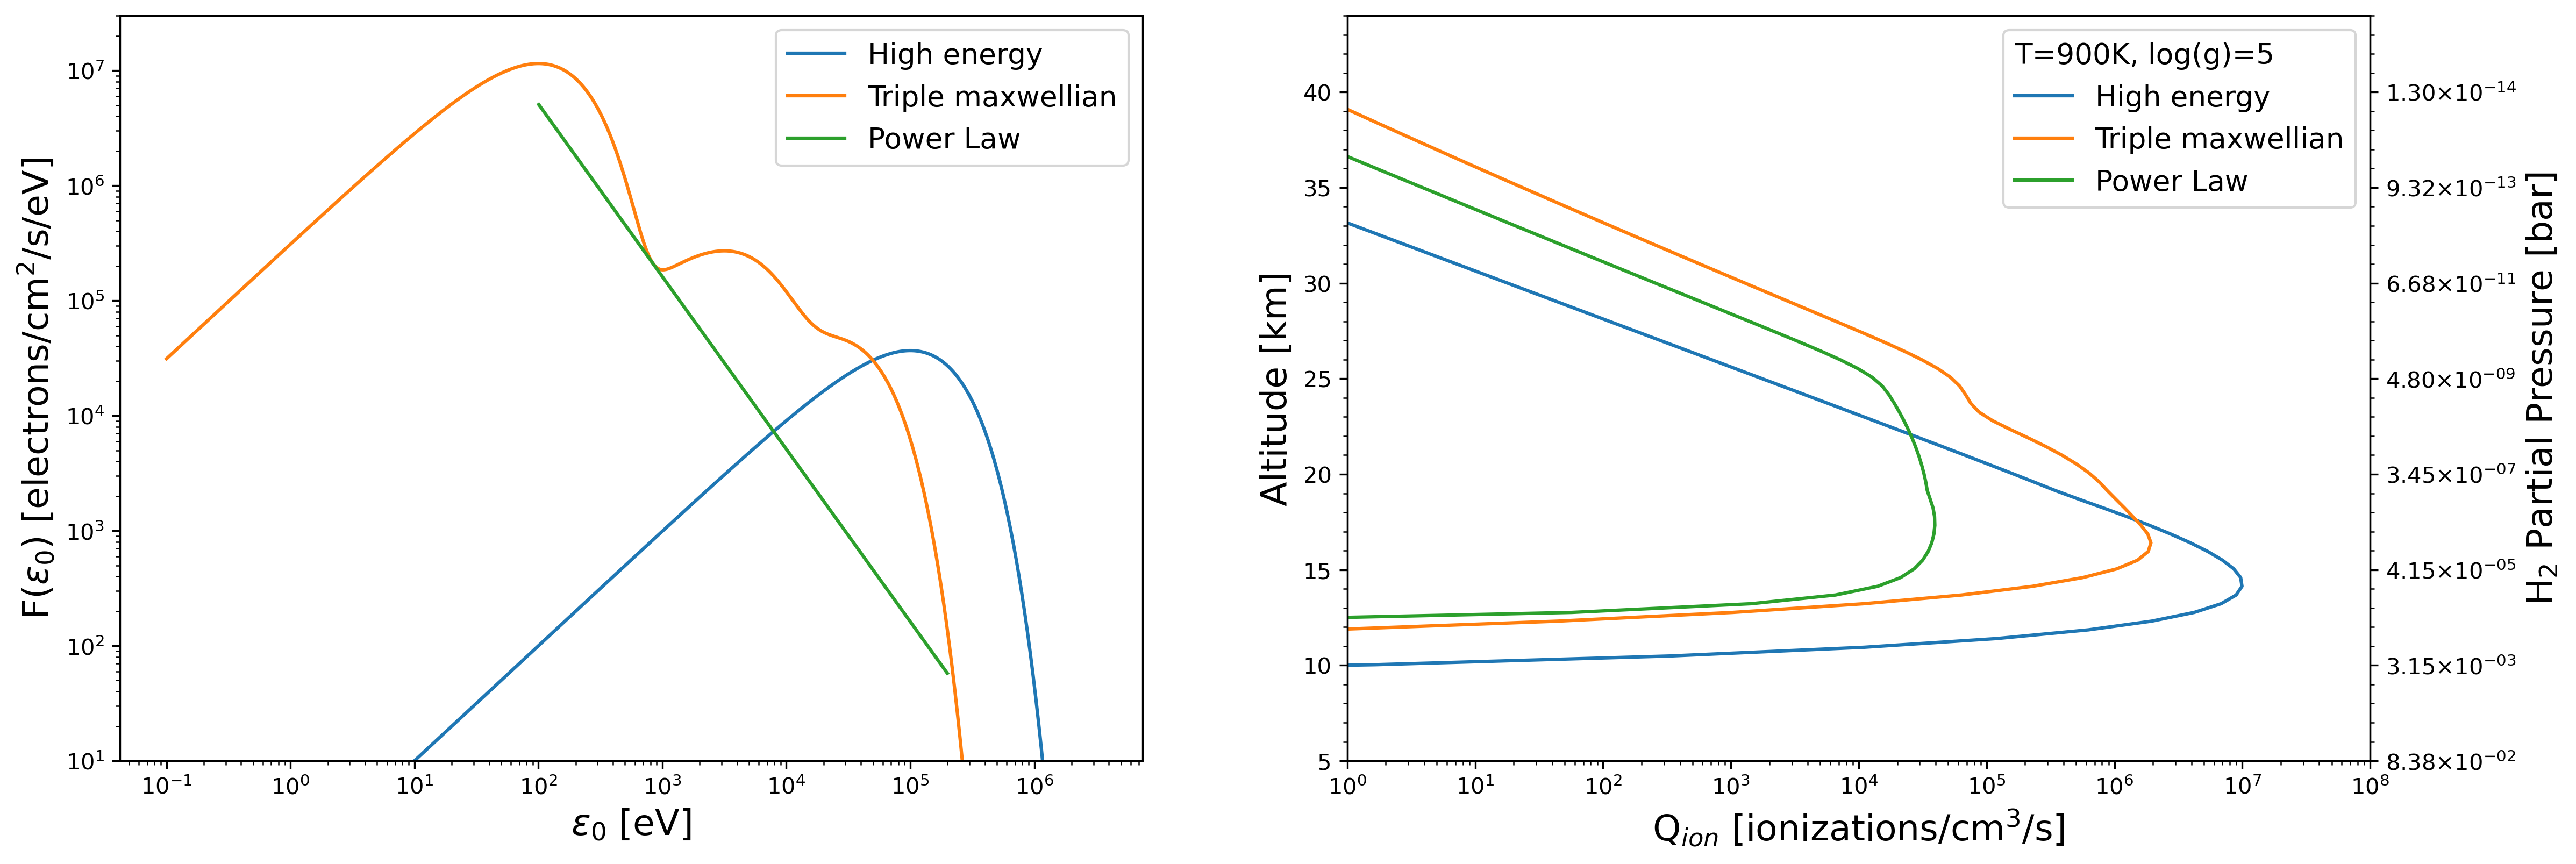

In [5]:
fs = 16

# plot energy spectra
plt.figure(figsize = [18,6], dpi = 300)
plt.subplot(121)
#E = E_eV.to(u.keV)
plt.plot(E_eV, F_high_energy(E_eV*u.eV), label = 'High energy')
#E = E_eV.to(u.keV)
plt.plot(E_eV, F_triple_maxwellian(E_eV*u.eV), label = 'Triple maxwellian')
#E = E_eV.to(u.keV)
plt.plot(E_eV[F_power_law(E_eV*u.eV)>0], F_power_law(E_eV*u.eV)[F_power_law(E_eV*u.eV)>0], label = 'Power Law')
plt.ylabel(r'F($\varepsilon_0$) [electrons/cm$^2$/s/eV]', fontsize = fs)
plt.xlabel(r'$\varepsilon_0$ [eV]', fontsize = fs)
plt.legend(fontsize = 0.8*fs)
plt.semilogx()
plt.semilogy()
plt.ylim([10,3e7])
ax = plt.gca()
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.subplot(122)
# plt.plot(Q_ion_high_energy, z_arr/1e3, color = 'C0', ls = 'solid', label = 'High energy')#, sim, results w/ interpolated #ions')
# plt.plot(Q_ion_triple_maxwellian, z_arr/1e3, color = 'C1', ls = 'solid', label = 'Triple maxwellian')#, sim, results w/ interpolated #ions')
# plt.plot(Q_ion_power_law, z_arr/1e3, color = 'C2', ls = 'solid', label = 'Power Law')#, sim, results w/ interpolated #ions')
plt.plot(Q_ion_high_energy_test, z_arr/1e3, color = 'C0', ls = 'solid', label = 'High energy')#, sim, results w/ interpolated #ions')
plt.plot(Q_ion_triple_maxwellian_test, z_arr/1e3, color = 'C1', ls = 'solid', label = 'Triple maxwellian')#, sim, results w/ interpolated #ions')
plt.plot(Q_ion_power_law_test, z_arr/1e3, color = 'C2', ls = 'solid', label = 'Power Law')#, sim, results w/ interpolated #ions')

plt.ylabel('Altitude [km]', fontsize = fs)
plt.xlabel(r'Q$_{ion}$ [ionizations/cm$^3$/s]', fontsize = fs)
leg = plt.legend(title = 'T=900K, log(g)=5', fontsize = 0.8*fs, title_fontsize= 0.8*fs)
leg._legend_box.align = "left"
plt.semilogx()
plt.ylim([5,44])
plt.xlim([1e0,1e8])
ax1 = plt.gca()
ax1.set_ylabel('Altitude [km]', fontsize = fs)
ytick_locs = ax1.get_yticks() # returns locs in data coords
P = get_pressure(ytick_locs*1000) / 1e5 # then convert to bars
ax2 = ax1.twinx()
ax2.set_yticks(ytick_locs)
formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
formatted_P = formatting_function(P)
label_P = [P.replace('E',r'$\times 10^{')+'}$' for P in formatted_P]
ax2.set_yticklabels(label_P)
ax2.set_ybound(ax1.get_ybound())
ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax2.minorticks_on()
ax1.minorticks_on()

plt.savefig('./paper_plots/Qion_'+atm_type+'_v5.pdf', format = 'pdf', bbox_inches="tight")

### Qion and energy depositon rate Ydwarf

In [34]:
atm_type = 'T482_g4.7'
sonora_filepath = './Sonora_data'
z_max = 37.942e3 * 1.2
z_min =  10e3
get_n_H2, get_pressure = utils.construct_profiles(atm_type, z_max, sonora_filepath)

event_type = 'Ionization heights [m]'
Q_ion_high_energy = []
Q_ion_power_law = []
Q_ion_triple_maxwellian = []
z_arr = np.linspace(0, z_max, 50) # FOR NOW 
E_eV = np.logspace(-1, 6.5, 1000) # eV 
E_keV = E_eV / 1e3
for i in range(len(z_arr)):
    zi = z_arr[i]
    Q_ion_high_energy += [utils.calc_Q(F_high_energy, zi, E_eV, z_min, z_max, get_n_H2, event_type).to((u.cm**-3/u.s)).value]
    Q_ion_power_law += [utils.calc_Q(F_power_law, zi, E_eV, z_min, z_max, get_n_H2, event_type).to((u.cm**-3/u.s)).value]
    Q_ion_triple_maxwellian += [utils.calc_Q(F_triple_maxwellian, zi, E_eV, z_min, z_max, get_n_H2, event_type).to((u.cm**-3/u.s)).value]


/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: divide by zero encountered in log10
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)
/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: divide by zero encountered in scalar power
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)
/projects/anzu2965/SPI/beam_sim/utils.py:3200: RuntimeWarning: invalid value encountered in multiply
  pdf = stats.moyal.pdf(-np.log10(N), mu, sigma)*(N*np.log(10))**(-1)


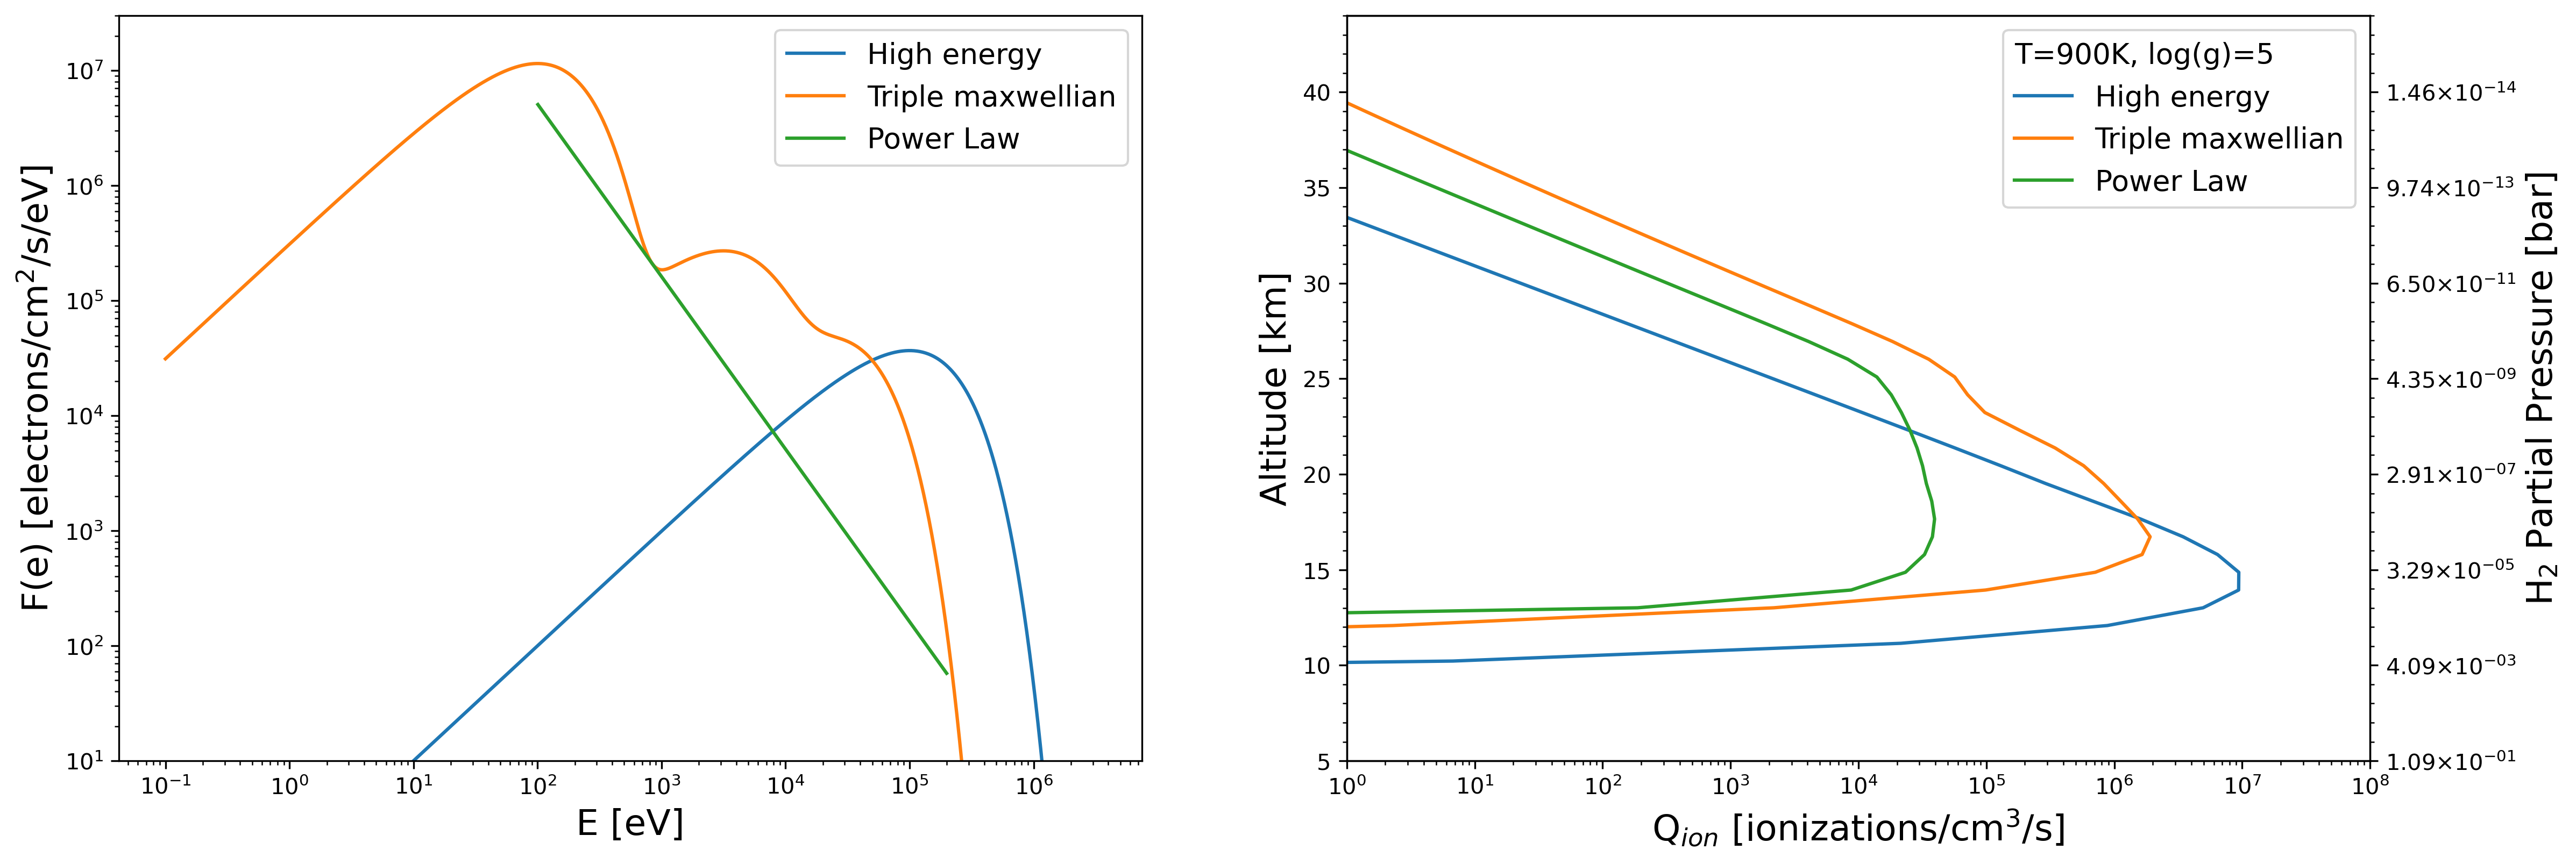

In [35]:
fs = 16

# plot energy spectra
plt.figure(figsize = [18,6], dpi = 300)
plt.subplot(121)
plt.plot(E_eV, F_high_energy(E_eV*u.eV), label = 'High energy')
plt.plot(E_eV, F_triple_maxwellian(E_eV*u.eV), label = 'Triple maxwellian')
plt.plot(E_eV[F_power_law(E_eV*u.eV)>0], F_power_law(E_eV*u.eV)[F_power_law(E_eV*u.eV)>0], label = 'Power Law')
plt.ylabel(r'F($\varepsilon_0$) [electrons/cm$^2$/s/eV]', fontsize = fs)
plt.xlabel('E [eV]', fontsize = fs)
plt.legend(fontsize = 0.8*fs)
plt.semilogx()
plt.semilogy()
plt.ylim([10,3e7])
ax = plt.gca()
ax.yaxis.set_major_locator(mticker.LogLocator(numticks=999))
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.subplot(122)
plt.plot(Q_ion_high_energy_test, z_arr/1e3, color = 'C0', ls = 'solid', label = 'High energy')#, sim, results w/ interpolated #ions')
plt.plot(Q_ion_triple_maxwellian_test, z_arr/1e3, color = 'C1', ls = 'solid', label = 'Triple maxwellian')#, sim, results w/ interpolated #ions')
plt.plot(Q_ion_power_law_test, z_arr/1e3, color = 'C2', ls = 'solid', label = 'Power Law')#, sim, results w/ interpolated #ions')

plt.ylabel('Altitude [km]', fontsize = fs)
plt.xlabel(r'Q$_{ion}$ [ionizations/cm$^3$/s]', fontsize = fs)
leg = plt.legend(title = 'T=482K, log(g)=4.7', fontsize = 0.8*fs, title_fontsize= 0.8*fs)
leg._legend_box.align = "left"
plt.semilogx()
plt.ylim([5,44])
plt.xlim([1e0,1e8])
ax1 = plt.gca()
ax1.set_ylabel('Altitude [km]', fontsize = fs)
ytick_locs = ax1.get_yticks() # returns locs in data coords
P = get_pressure(ytick_locs*1000) / 1e5 # then convert to bars
ax2 = ax1.twinx()
ax2.set_yticks(ytick_locs)
formatting_function = np.vectorize(lambda f: format(f, '6.2E'))
formatted_P = formatting_function(P)
label_P = [P.replace('E',r'$\times 10^{')+'}$' for P in formatted_P]
ax2.set_yticklabels(label_P)
ax2.set_ybound(ax1.get_ybound())
ax2.set_ylabel(r'H$_2$ Partial Pressure [bar]', fontsize = fs)
ax2.minorticks_on()
ax1.minorticks_on()

plt.savefig('./paper_plots/Qion_'+atm_type+'_v1.pdf', format = 'pdf', bbox_inches="tight")

In [1]:
# energy depostiion rate:

# Scratch area

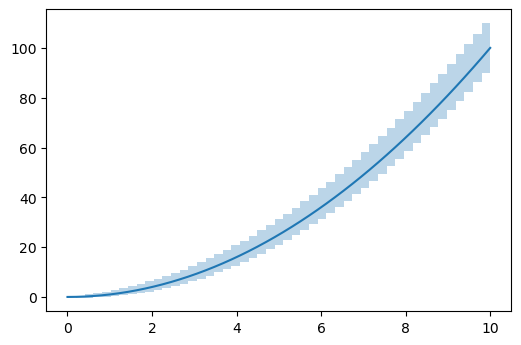

In [17]:
plt.figure(dpi = 100)
x = np.linspace(0,10,50)
y = x**2
err = np.sqrt(y)
plt.plot(x,y)
color = plt.gca().lines[-1].get_color()
plt.fill_between(x, y+err, y-err, step='pre', alpha = 0.3, color = color , linewidth = 0.0)
